# Mount Notebook to Google Drive
Upload the data, pretrianed model, figures, etc to your Google Drive, then mount this notebook to Google Drive. After that, you can access the resources freely.

Instruction: https://colab.research.google.com/notebooks/io.ipynb

Example: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q

Video: https://www.youtube.com/watch?v=zc8g8lGcwQU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Introduction

*   Background of the problem
  <!-- * what type of problem: disease/readmission/mortality prediction,  feature engineeing, data processing, etc
  * what is the importance/meaning of solving the problem
  * what is the difficulty of the problem
  * the state of the art methods and effectiveness. -->
  * The management of hospital beds, particularly in the Intensive Care Unit (ICU), is a critical challenge due to budget constraints and increasing patient demand.
  * Efficient resource allocation in the ICU is crucial because it involves life-support services for critically ill patients.
  * Predicting the length of stay (LoS) of patients in the ICU is vital to optimize these resources.
  * However, this prediction task is complex due to the high variability among patients and the dynamic nature of clinical environments.
  * State-of-the-art methods for LoS prediction primarily include machine learning models that utilize Electronic Health Records (EHR), such as Long Short-Term Memory (LSTM) networks and Transformer models.
  * These methods focus on overcoming challenges related to the irregularity and missingness of EHR data, yet they struggle with issues like data skewness and the necessity for frequent updates based on new incoming data.

*   Paper explanation
  <!-- * what did the paper propose
  * what is the innovations of the method
  * how well the proposed method work (in its own metrics)
  * what is the contribution to the reasearch regime (referring the Background above, how important the paper is to the problem). -->
  * The paper introduced a novel deep learning model named Temporal Pointwise Convolution (TPC), designed to enhance the prediction of ICU stay lengths by addressing specific challenges inherent in EHR data. TPC integrates temporal convolution to handle dependencies across time and pointwise convolution to extract high-level feature interactions.
  * The innovation in TPC lies in its dual approach, combining temporal and pointwise convolutions. This design allows it to effectively handle the skewness and irregular sampling inherent in EHR data, providing a more robust framework for feature extraction compared to existing methods.
  * The proposed TPC model demonstrates substantial improvements in prediction accuracy over traditional models like LSTM and Transformer. It achieved a mean absolute deviation in LoS predictions significantly lower than these benchmarks, illustrating its effectiveness in real-world settings.
  * The TPC model contributes significantly to the ICU resource management field by providing a more accurate and reliable method for predicting patient LoS. By improving prediction accuracy, the model aids in better resource allocation and operational planning in hospitals, addressing the critical need outlined in the paper's background. This advancement is particularly important given the increasing pressure on ICU resources and the potential impact of accurate predictions on patient outcomes and hospital efficiency.


## LICENSE

Code has been derived and modified from the authors' github: https://github.com/EmmaRocheteau/TPC-LoS-prediction/tree/master

LICENSE:
MIT License

Copyright (c) 2020 Emma Rocheteau

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

All models were trained locally, and data was pre-processed locally as well. Models were loaded in from a local runtime running Python 3.6. Other library requirements are listed in the Github: https://github.com/Ponyokatsu/cs598DLH-tpc-LoS/tree/main

# Scope of Reproducibility:

We encountered numerous package dependency issues because most of the code on the original GitHub repo is compatible with Python 3.6, while the Python version available in Colab is 3.10.6. Therefore, we used a local runtime where we have Python 3.6 and the corresponding dependencies set up. Consequently, we spent a lot of time resolving these package issues and securing the necessary computing resources to run the preprocessing required to prepare the eICU and MIMIC datasets for use with the models discussed later.

List hypotheses from the paper you will test and the corresponding experiments you will run.


1.   Hypothesis 1: The TPC model will exhibit superior performance in predicting ICU patients' remaining LoS compared to traditional models, including LSTMs and Transformers, by effectively handling EHR data's inherent challenges.
2.   Hypothesis 2: Incorporating mortality prediction as an auxiliary task will further enhance the TPC model's accuracy in LoS predictions, leveraging the interrelated nature of mortality risk and extended hospital stays.



# Methodology

In [ ]:
# import  packages you need
import numpy as np
from google.colab import drive


##  Data
<!-- Data includes raw data (MIMIC III tables), descriptive statistics (our homework questions), and data processing (feature engineering).
  * Source of the data: where the data is collected from; if data is synthetic or self-generated, explain how. If possible, please provide a link to the raw datasets.
  * Statistics: include basic descriptive statistics of the dataset like size, cross validation split, label distribution, etc.
  * Data process: how do you munipulate the data, e.g., change the class labels, split the dataset to train/valid/test, refining the dataset.
  * Illustration: printing results, plotting figures for illustration.
  * You can upload your raw dataset to Google Drive and mount this Colab to the same directory. If your raw dataset is too large, you can upload the processed dataset and have a code to load the processed dataset. -->
* Source of the data
  * The data used in this study were collected from two extensive critical care databases: the eICU Collaborative Research Database and the MIMIC-IV Database. These databases contain detailed Electronic Health Records (EHR) from ICU patients, capturing a wide variety of clinical data points. Both of these datasets are obtained from the Physionet website after completing the required training. [License.](https://physionet.org/content/mimiciv/view-license/0.4/)

    * eICU Collaborative Research Database: This is a multi-center database gathered from over 200 hospitals across the United States, available via PhysioNet. [Link.](https://physionet.org/content/eicu-crd/2.0/)
    * MIMIC-IV Database: This database is a de-identified, publicly accessible dataset derived from Beth Israel Deaconess Medical Center and contains comprehensive data related to ICU stays. [Link.](https://physionet.org/content/mimiciv/0.4/)


* Statistics
  * eICU: The dataset includes 200,859 patient unit encounters for 139,367 unique patients admitted between 2014 and 2015.
  * MIMIC-IV: The dataset consists of 69,619 ICU stays from 50,048 patients admitted between 2008 and 2019.
  * Data was divided such that 70% was used for training, 15% for validation, and 15% for testing, ensuring no patient overlap between these sets.
  * Both datasets include labels for length of stay and in-hospital mortality, with the specifics of these distributions tailored to reflect the critical conditions and care requirements in ICUs.
* Data process

  * Data fields with high levels of missingness were either imputed or forward-filled based on the last known value to maintain the integrity of temporal patterns.
  * To refine the data, we selected a subset of features that demonstrated significant variability and relevance to the ICU length of stay, based on preliminary analysis and expert clinical knowledge.
  * Only features present in at least a certain percentage of patient stays were included. Variables from lab results, vital signs, and nurse charting inputs were among those analyzed.
  * Continuous variables were normalized to have zero mean and unit variance to aid model convergence and performance.

* Descriptive statistics using Illustrations
  * In the code cell below we analyse the training MIMIC-IV and eICU datasetS used by the author.
  * We first visualize the proportion of Male and Female patients in the training dataset.
  * The number of people belonging to all ethnicities is presented as a pie chart.
  * Finally we also present the number of people from each region in the eICU Training dataset.

* NOTE: Since all the visualization is performed on the processed data, running the below cells will not directly give the results. Due to the data being protected, the reader has to generate the visualizations themself. The output is given below.

DATA LICENSE:
The PhysioNet Credentialed Health Data License
Version 1.5.0

Copyright (c) 2024 MIT Laboratory for Computational Physiology

The MIT Laboratory for Computational Physiology (MIT-LCP) wishes to make data available for research and educational purposes to qualified requestors, but only if the data are used and protected in accordance with the terms and conditions stated in this License.

It is hereby agreed between the data requestor, hereinafter referred to as the "LICENSEE", and MIT-LCP, that:

    The LICENSEE will not attempt to identify any individual or institution referenced in PhysioNet restricted data.
    The LICENSEE will exercise all reasonable and prudent care to avoid disclosure of the identity of any individual or institution referenced in PhysioNet restricted data in any publication or other communication.
    The LICENSEE will not share access to PhysioNet restricted data with anyone else.
    The LICENSEE will exercise all reasonable and prudent care to maintain the physical and electronic security of PhysioNet restricted data.
    If the LICENSEE finds information within PhysioNet restricted data that he or she believes might permit identification of any individual or institution, the LICENSEE will report the location of this information promptly by email to PHI-report@physionet.org, citing the location of the specific information in question.
    The LICENSEE will use the data for the sole purpose of lawful use in scientific research and no other.
    The LICENSEE will be responsible for ensuring that he or she maintains up to date certification in human research subject protection and HIPAA regulations.
    The LICENSEE agrees to contribute code associated with publications arising from this data to a repository that is open to the research community.
    This agreement may be terminated by either party at any time, but the LICENSEE's obligations with respect to PhysioNet data shall continue after termination.  

THE DATA ARE PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE DATA OR THE USE OR OTHER DEALINGS IN THE DATA.

In [ ]:
# VISUALIZATION FOR THE NUMBER OF MALE VS FEMALE IN THE TRAINING DATASET
import matplotlib.pyplot as plt
import pandas as pd

flat_train = pd.read_csv('flat.csv')

# Count the occurrences of each gender value in the dataset
gender_counts = flat_train['gender'].value_counts()

# Create a bar chart to visualize the number of males vs females
plt.figure(figsize=(8, 6))
gender_counts.plot(kind='bar')
plt.title('Number of Males vs. Females in the Training Dataset')
plt.xlabel('Gender (0=Male, 1=Female)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

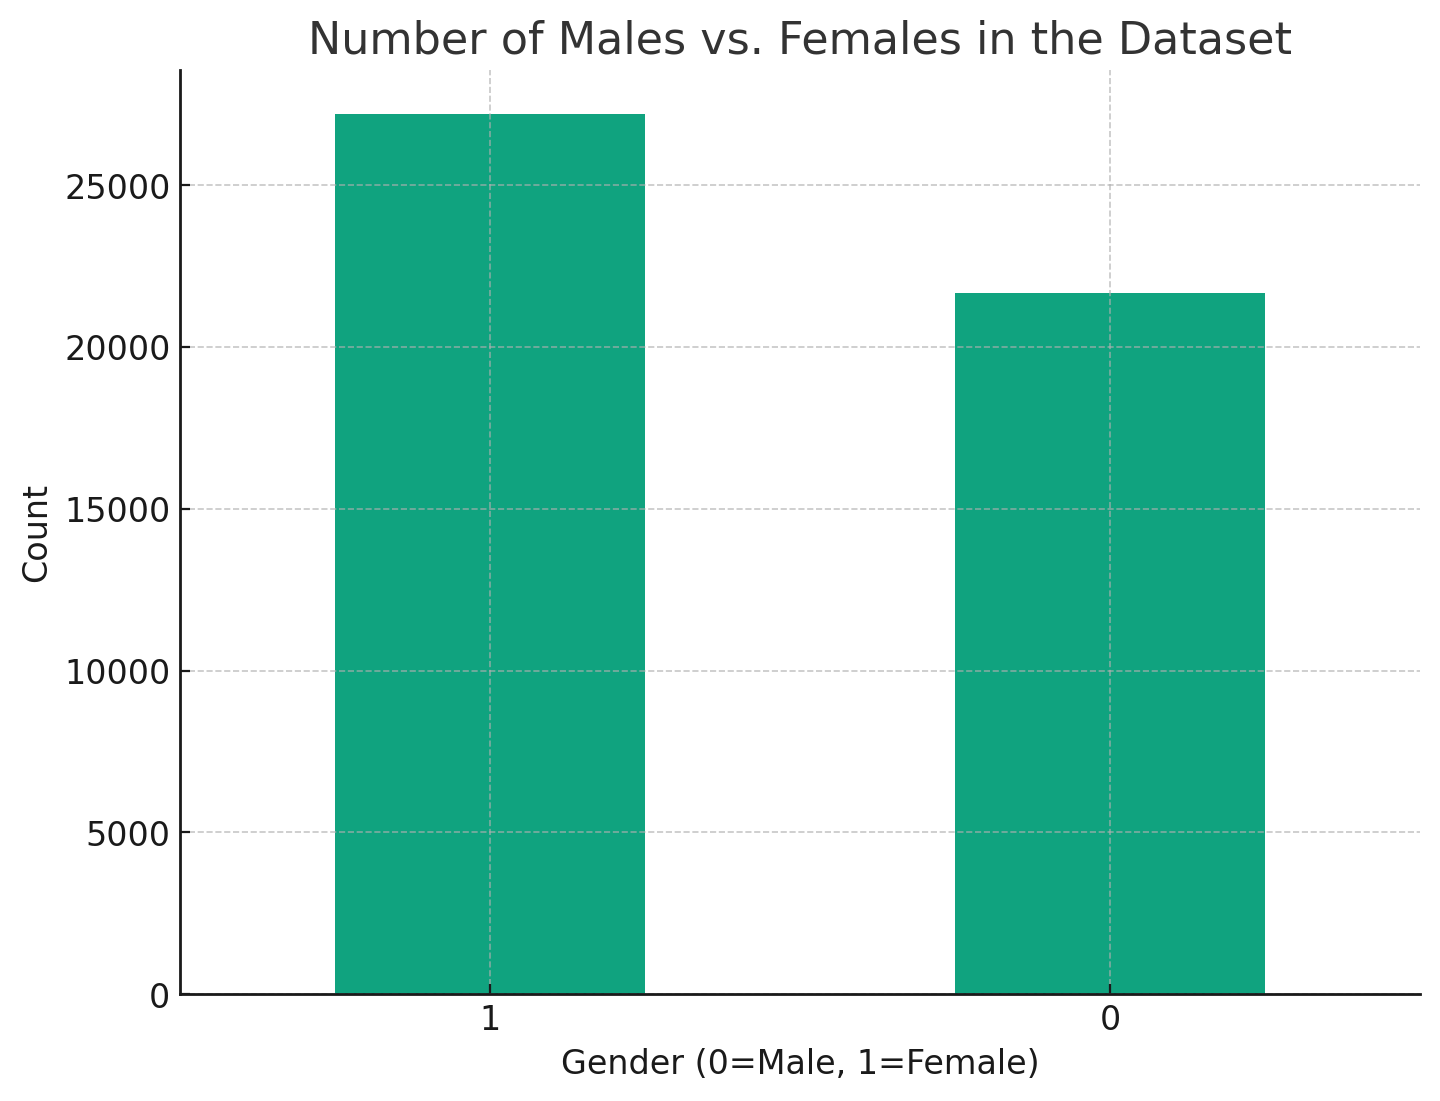

In [ ]:
# # dir and function to load raw data
# raw_data_dir = '/content/gdrive/My Drive/Colab Notebooks/<path-to-raw-data>'

# def load_raw_data(raw_data_dir):
#   # implement this function to load raw data to dataframe/numpy array/tensor
#   return None

# raw_data = load_raw_data(raw_data_dir)

# # calculate statistics
# def calculate_stats(raw_data):
#   # implement this function to calculate the statistics
#   # it is encouraged to print out the results
#   return None

# # process raw data
# def process_data(raw_data):
#     # implement this function to process the data as you need
#   return None

# processed_data = process_data(raw_data)

# ''' you can load the processed data directly
# processed_data_dir = '/content/gdrive/My Drive/Colab Notebooks/<path-to-raw-data>'
# def load_processed_data(raw_data_dir):
#   pass

# '''

# VISUALIZATION FOR DIFFERENT ETHNICITIES IN THE TRAINING DATA

# Columns for ethnicities in the DataFrame, assuming they are formatted like 'ethnicity_<group>'
ethnicity_columns = [col for col in df.columns if 'ethnicity_' in col]

# Calculate the sum for each ethnicity column to get the count of individuals belonging to each group
ethnicity_counts = df[ethnicity_columns].sum()

# Display the counts
print(ethnicity_counts)

# Plotting the pie chart
plt.figure(figsize=(10, 8))
plt.pie(ethnicity_counts, labels=ethnicity_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Ethnicities')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


* ethnicity_ASIAN                      1438
* ethnicity_BLACK/AFRICAN AMERICAN     5399
* ethnicity_HISPANIC/LATINO            1906
* ethnicity_OTHER                      2188
* ethnicity_UNKNOWN                    4166
* ethnicity_WHITE                     33049
* ethnicity_misc                        702

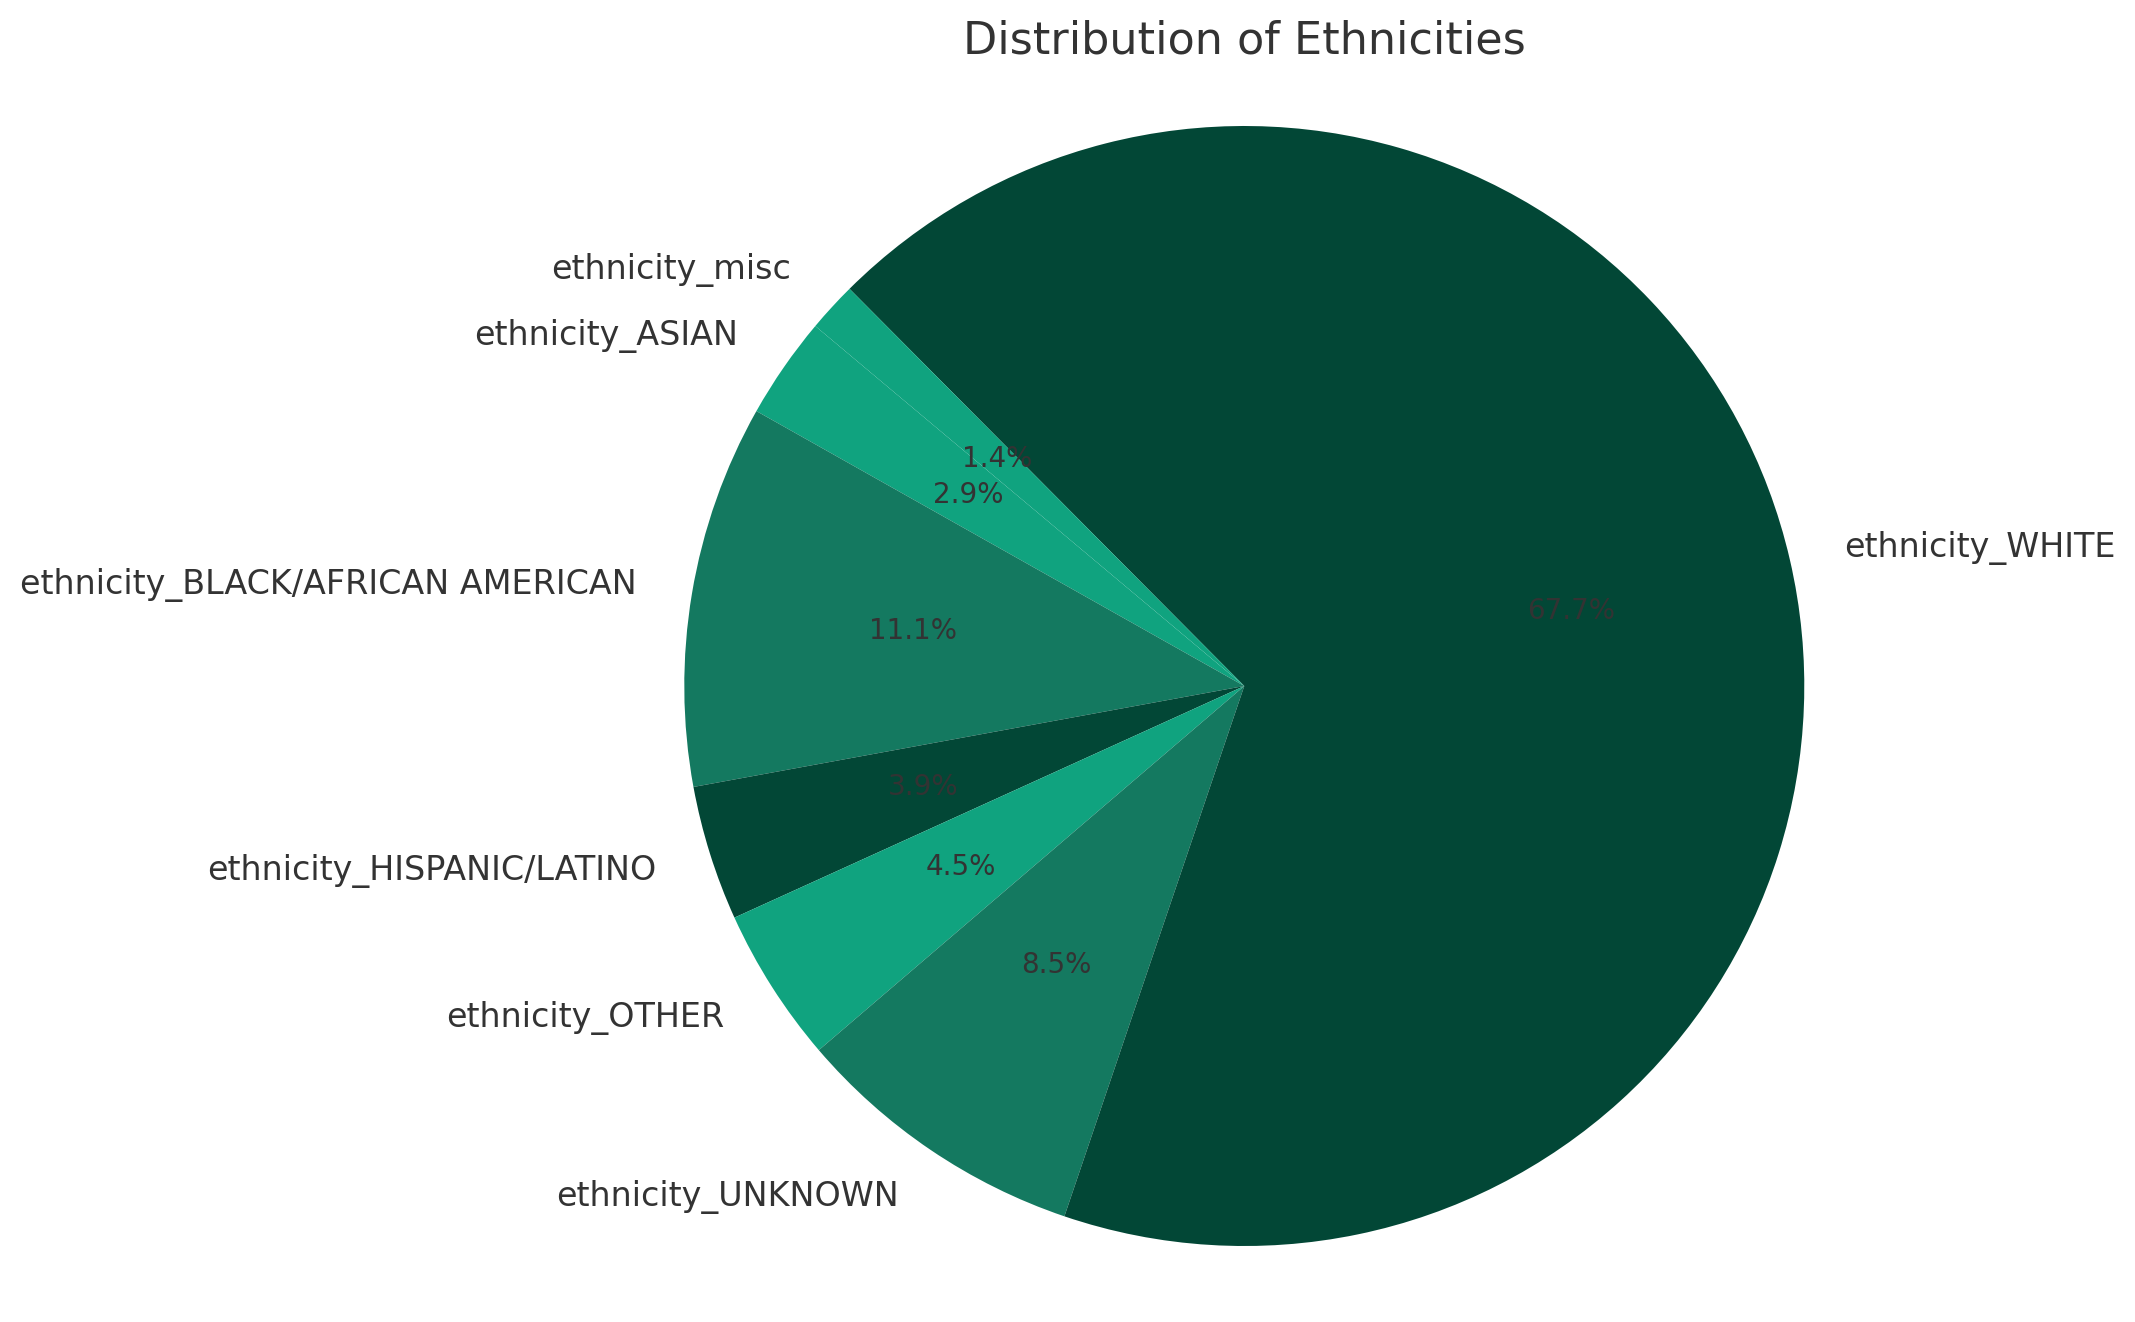

In [ ]:
# Count the number of people from each region in the eICU Training dataset. Presented as a barchart
region_counts = data[['region_Midwest', 'region_Northeast', 'region_South', 'region_West']].sum()
print(region_counts)

# Visualization of the counts
plt.figure(figsize=(10, 6))
region_counts.plot(kind='bar')
plt.title('Number of People from Each Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotates the x-axis labels for better readability
plt.show()

* Midwest: 38,267
* Northeast: 7,377
* South: 34,442
* West: 18,164

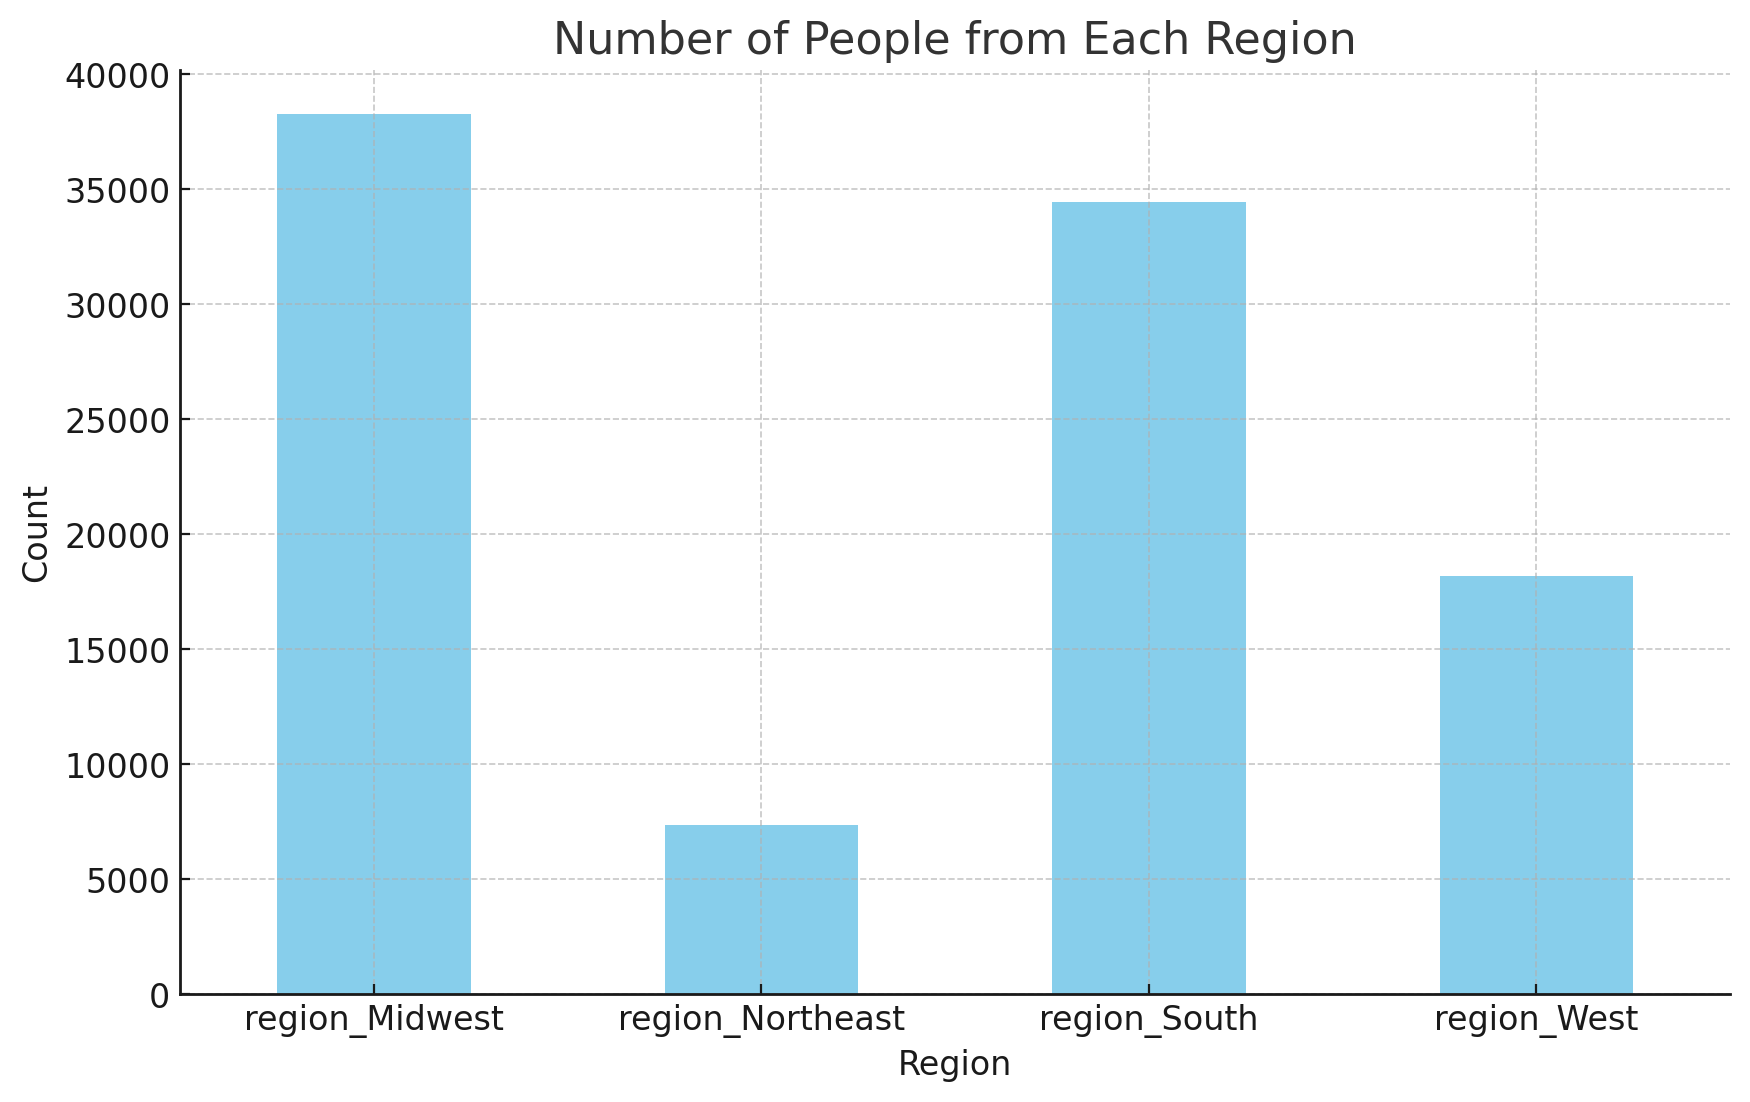


## Data Pre-Processing Instructions

For the eICU to be compatible with our models and to be used in the right way, we need to first pre-process it. The complete code from loading the eICU data into our PostGreSQL tables and then further processing them into csv files is available at the following location:
[eICU preprocessing](https://github.com/Ponyokatsu/cs598DLH-tpc-LoS/tree/main/Tpc-LoS-Prediction/eICU_preprocessing).
Below is a summary of these instructions



### eICU

1. **Setup eICU Database**:
   - Ensure you have the eICU database set up, which can be found [here](https://physionet.org/content/eicu-crd/2.0/).
   - Follow the instructions for local installation provided [here](https://eicu-crd.mit.edu/tutorials/install_eicu_locally/). This will ensure correct connection configurations.

2. **Database Commands**:
   - Connect to PostgreSQL using the eICU user: `psql -U eicu`
   - Create the schema if not exists: `CREATE SCHEMA if not exists eicu_crd;`
   - Set search path: `set search_path to eicu_crd;`
   - Create and load tables, add indexes, and validate using the SQL files provided in your setup instructions.

3. **Configuration Files**:
   - Replace the `eICU_path` in `paths.json` with a convenient location on your computer.
   - Use find and replace in `eICU_preprocessing/create_all_tables.sql` to update paths accordingly.

4. **Run Commands in Terminal**:
   - Navigate to your project directory and connect to your database using:
     ```
     psql 'dbname=eicu user=eicu options=--search_path=eicu'
     ```
   - Inside the psql console, initiate table creation:
     ```
     \i eICU_preprocessing/create_all_tables.sql
     ```
   - This process might take a couple of hours. To quit the console, type `\q`.

5. **Run Pre-Processing Scripts**:
   - Execute pre-processing scripts which might need to run overnight:
     ```
     python3 -m eICU_preprocessing.run_all_preprocessing
     ```



### MIMIC-IV

Similarlt, for the MIMIC to be compatible with our models and to be used in the right way, we need to first pre-process it. The complete code from loading the eICU data into our PostGreSQL tables and then further processing them into csv files is available at the following location:
[MIMIC preprocessing](https://github.com/Ponyokatsu/cs598DLH-tpc-LoS/tree/main/Tpc-LoS-Prediction/MIMIC_preprocessing).
Below is a summary of these instructions


1. **Setup MIMIC-IV Database**:
   - Ensure you have the MIMIC-IV database set up, details found [here](https://physionet.org/content/mimiciv/0.4/).
   - Access to MIMIC-IV is recommended via BigQuery as per [these instructions](https://mimic-iv.mit.edu/docs/access/bigquery/), although local setups are detailed in various guides for Unix and Windows systems.

2. **Database Commands**:
   - For a local setup, use commands to create tables, load data, and add indexes. Ensure all paths and permissions are correctly configured.

3. **Configuration Files**:
   - Replace the `MIMIC_path` in `paths.json` with your desired local path.
   - Update `MIMIC_preprocessing/create_all_tables.sql` accordingly.

4. **Run Commands in Terminal**:
   - Connect to your MIMIC-IV database setup and execute the SQL scripts:
     ```
     psql -U mimicuser -v ON_ERROR_STOP=1 -d mimic4 --set=search_path=mimiciv
     \i MIMIC_preprocessing/create_all_tables.sql
     ```
   - This might also take a couple of hours. To exit, type `\q`.
   
5. **Run Post-Setup Scripts**:
   - After database setup, execute necessary scripts to finalize the setup, potentially running overnight.


Below cells contain a couple of snippets from this pre-processing.

In [ ]:

# from sklearn.model_selection import train_test_split
# from sklearn.utils import shuffle
# import pandas as pd
# import os
# import argparse

# # Creates a new folder at the specified path if it does not exist
# def create_folder(parent_path, folder):
#     if not parent_path.endswith("/"):
#         parent_path += "/"
#     folder_path = parent_path + folder
#     if not os.path.exists(folder_path):
#         os.makedirs(folder_path)
#     return folder_path

# # Shuffles the stays DataFrame using a specified random seed
# def shuffle_stays(stays, seed=9):
#     return shuffle(stays, random_state=seed)

# # Processes a table by filtering rows based on stays and saving the result into a CSV file
# def process_table(table_name, table, stays, folder_path):
#     table = table.loc[stays].copy()
#     table.to_csv("{}/{}.csv".format(folder_path, table_name))
#     return

# # Splits the dataset into training, validation, and test sets and processes each table accordingly
# def split_train_test(path, is_test=True, seed=9, cleanup=True, MIMIC=False):
#     labels = pd.read_csv(path + "preprocessed_labels.csv")
#     labels.set_index("patient", inplace=True)
#     # we split by unique patient identifier to make sure there are no patients
#     # that cross into both the train and the test sets
#     patients = labels.uniquepid.unique()

#     train, test = train_test_split(patients, test_size=0.15, random_state=seed)
#     train, val = train_test_split(train, test_size=0.15 / 0.85, random_state=seed)

#     print("==> Loading data for splitting...")
#     if is_test:
#         timeseries = pd.read_csv(path + "preprocessed_timeseries.csv", nrows=999999)
#     else:
#         timeseries = pd.read_csv(path + "preprocessed_timeseries.csv")
#     timeseries.set_index("patient", inplace=True)
#     if not MIMIC:
#         diagnoses = pd.read_csv(path + "preprocessed_diagnoses.csv")
#         diagnoses.set_index("patient", inplace=True)
#     flat_features = pd.read_csv(path + "preprocessed_flat.csv")
#     flat_features.set_index("patient", inplace=True)

#     # delete the source files, as they won't be needed anymore
#     if is_test is False and cleanup:
#         print("==> Removing the unsorted data...")
#         os.remove(path + "preprocessed_timeseries.csv")
#         if not MIMIC:
#             os.remove(path + "preprocessed_diagnoses.csv")
#         os.remove(path + "preprocessed_labels.csv")
#         os.remove(path + "preprocessed_flat.csv")

#     for partition_name, partition in zip(["train", "val", "test"], [train, val, test]):
#         print("==> Preparing {} data...".format(partition_name))
#         stays = labels.loc[labels["uniquepid"].isin(partition)].index
#         folder_path = create_folder(path, partition_name)
#         with open(folder_path + "/stays.txt", "w") as f:
#             for stay in stays:
#                 f.write("%s\n" % stay)
#         stays = shuffle_stays(stays, seed=9)
#         if MIMIC:
#             for table_name, table in zip(
#                 ["labels", "flat", "timeseries"], [labels, flat_features, timeseries]
#             ):
#                 process_table(table_name, table, stays, folder_path)
#         else:
#             for table_name, table in zip(
#                 ["labels", "flat", "diagnoses", "timeseries"],
#                 [labels, flat_features, diagnoses, timeseries],
#             ):
#                 process_table(table_name, table, stays, folder_path)

#     return

### **Shuffling Training Data for TPC Model**

The shuffle_train function is used to shuffle the training data for the TPC model, which is crucial for ensuring that the model does not learn any unintended patterns from the order of the data.
Function Overview
Reads CSV files for labels, flat, diagnoses, and timeseries, setting the patient column as the index.
Shuffles the patient stays without a fixed seed, resulting in a different order each time the function is run.
Processes each table (labels, flat, diagnoses, timeseries) by filtering based on the shuffled stays and saving them back to CSV files in the train_path directory.
Writes the shuffled patient stays to a text file (stays.txt) within the train_path directory.
This shuffling process is part of the data preparation stage, ensuring that the training data is randomized, which helps prevent overfitting and improves the generalization of the TPC model.

In [ ]:
# def shuffle_train(train_path):
#     labels = pd.read_csv(train_path + "/labels.csv", index_col="patient")
#     flat = pd.read_csv(train_path + "/flat.csv", index_col="patient")
#     diagnoses = pd.read_csv(train_path + "/diagnoses.csv", index_col="patient")
#     timeseries = pd.read_csv(train_path + "/timeseries.csv", index_col="patient")

#     stays = labels.index.values
#     stays = shuffle_stays(stays, seed=None)  # No seed will make it completely random
#     for table_name, table in zip(
#         ["labels", "flat", "diagnoses", "timeseries"],
#         [labels, flat, diagnoses, timeseries],
#     ):
#         process_table(table_name, table, stays, train_path)

#     with open(train_path + "/stays.txt", "w") as f:
#         for stay in stays:
#             f.write("%s\n" % stay)
#     return


eICU_preprocessing.timeseries

In [ ]:
# Reconfigures the timeseries data by setting a multi-index of patient ID and time, and optionally pivots the table if a feature column is provided.
# def reconfigure_timeseries(timeseries, offset_column, feature_column=None, test=False):
#     if test:
#         timeseries = timeseries.iloc[300000:5000000]
#     timeseries.set_index(
#         ["patientunitstayid", pd.to_timedelta(timeseries[offset_column], unit="T")],
#         inplace=True,
#     )
#     timeseries.drop(columns=offset_column, inplace=True)
#     if feature_column is not None:
#         timeseries = timeseries.pivot_table(
#             columns=feature_column, index=timeseries.index
#         )
#     # convert index to multi-index with both patients and timedelta stamp
#     timeseries.index = pd.MultiIndex.from_tuples(
#         timeseries.index, names=["patient", "time"]
#     )
#     return timeseries

# # Resamples the timeseries data to hourly intervals and applies a decay function to the mask indicating the presence of measurements.
# def resample_and_mask(
#     timeseries,
#     eICU_path,
#     header,
#     mask_decay=True,
#     decay_rate=4 / 3,
#     test=False,
#     verbose=False,
#     length_limit=24 * 14,
# ):
#     if test:
#         mask_decay = False
#         verbose = True
#     if verbose:
#         print("Resampling to 1 hour intervals...")
#     # take the mean of any duplicate index entries for unstacking
#     timeseries = timeseries.groupby(level=[0, 1]).mean()

#     timeseries.reset_index(level=1, inplace=True)
#     timeseries.time = timeseries.time.dt.ceil(freq="H")
#     timeseries.set_index("time", append=True, inplace=True)
#     timeseries.reset_index(level=0, inplace=True)
#     resampled = (
#         timeseries.groupby("patient")
#         .resample("H", closed="right", label="right")
#         .mean()
#         .drop(columns="patient")
#     )
#     del timeseries

#     def apply_mask_decay(mask_bool):
#         mask = mask_bool.astype(int)
#         mask.replace({0: np.nan}, inplace=True)  # so that forward fill works
#         inv_mask_bool = ~mask_bool
#         count_non_measurements = inv_mask_bool.cumsum() - inv_mask_bool.cumsum().where(
#             mask_bool
#         ).ffill().fillna(0)
#         decay_mask = mask.ffill().fillna(0) / (
#             count_non_measurements * decay_rate
#         ).replace(0, 1)
#         return decay_mask

#     # store which values had to be imputed
#     if mask_decay:
#         if verbose:
#             print("Calculating mask decay features...")
#         mask_bool = resampled.notnull()
#         mask = mask_bool.groupby("patient").transform(apply_mask_decay)
#         del mask_bool
#     else:
#         if verbose:
#             print("Calculating binary mask features...")
#         mask = resampled.notnull()
#         mask = mask.astype(int)

#     if verbose:
#         print("Filling missing data forwards...")
#     # carry forward missing values (note they will still be 0 in the nulls table)
#     resampled = resampled.fillna(method="ffill")

#     # simplify the indexes of both tables
#     mask = mask.rename(
#         index=dict(
#             zip(
#                 mask.index.levels[1],
#                 mask.index.levels[1].days * 24 + mask.index.levels[1].seconds // 3600,
#             )
#         )
#     )
#     resampled = resampled.rename(
#         index=dict(
#             zip(
#                 resampled.index.levels[1],
#                 resampled.index.levels[1].days * 24
#                 + resampled.index.levels[1].seconds // 3600,
#             )
#         )
#     )

#     # clip to length_limit
#     if length_limit is not None:
#         within_length_limit = resampled.index.get_level_values(1) < length_limit
#         resampled = resampled.loc[within_length_limit]
#         mask = mask.loc[within_length_limit]

#     if verbose:
#         print("Filling in remaining values with zeros...")
#     resampled.fillna(0, inplace=True)

#     # rename the columns in pandas for the mask so it doesn't complain
#     mask.columns = [str(col) + "_mask" for col in mask.columns]

#     # merge the mask with the features
#     final = pd.concat([resampled, mask], axis=1)
#     final.reset_index(level=1, inplace=True)
#     final = final.loc[final.time > 0]

#     if verbose:
#         print("Saving progress...")
#     # save to csv
#     if test is False:
#         final.to_csv(eICU_path + "preprocessed_timeseries.csv", mode="a", header=header)
#     return

# # Generates chunks of patient data for processing in batches.
# def gen_patient_chunk(patients, size=1000):
#     it = iter(patients)
#     chunk = list(islice(it, size))
#     while chunk:
#         yield chunk
#         chunk = list(islice(it, size))

# # Main function to process timeseries data for the eICU dataset.
# def gen_timeseries_file_eICU(eICU_path, test=False):
#     print("==> Loading data from timeseries files...")
#     if test:
#         timeseries_lab = pd.read_csv(eICU_path + "timeserieslab.csv", nrows=500000)
#         timeseries_resp = pd.read_csv(eICU_path + "timeseriesresp.csv", nrows=500000)
#         timeseries_nurse = pd.read_csv(eICU_path + "timeseriesnurse.csv", nrows=500000)
#         timeseries_periodic = pd.read_csv(
#             eICU_path + "timeseriesperiodic.csv", nrows=500000
#         )
#         timeseries_aperiodic = pd.read_csv(
#             eICU_path + "timeseriesaperiodic.csv", nrows=500000
#         )
#     else:
#         timeseries_lab = pd.read_csv(eICU_path + "timeserieslab.csv")
#         timeseries_resp = pd.read_csv(eICU_path + "timeseriesresp.csv")
#         timeseries_nurse = pd.read_csv(eICU_path + "timeseriesnurse.csv")
#         timeseries_periodic = pd.read_csv(eICU_path + "timeseriesperiodic.csv")
#         timeseries_aperiodic = pd.read_csv(eICU_path + "timeseriesaperiodic.csv")

#     print("==> Reconfiguring lab timeseries...")
#     timeseries_lab = reconfigure_timeseries(
#         timeseries_lab,
#         offset_column="labresultoffset",
#         feature_column="labname",
#         test=test,
#     )
#     timeseries_lab.columns = timeseries_lab.columns.droplevel()

#     print("==> Reconfiguring respiratory timeseries...")
#     # get rid of % signs (found in FiO2 section) and then convert into numbers
#     timeseries_resp = timeseries_resp.replace("%", "", regex=True)
#     timeseries_resp["respchartvalue"] = pd.to_numeric(
#         timeseries_resp["respchartvalue"], errors="coerce"
#     )
#     timeseries_resp = timeseries_resp.loc[timeseries_resp["respchartvalue"].notnull()]
#     timeseries_resp = reconfigure_timeseries(
#         timeseries_resp,
#         offset_column="respchartoffset",
#         feature_column="respchartvaluelabel",
#         test=test,
#     )
#     timeseries_resp.columns = timeseries_resp.columns.droplevel()

#     print("==> Reconfiguring nurse timeseries...")
#     # remove non numeric data
#     timeseries_nurse["nursingchartvalue"] = pd.to_numeric(
#         timeseries_nurse["nursingchartvalue"], errors="coerce"
#     )
#     timeseries_nurse = timeseries_nurse.loc[
#         timeseries_nurse["nursingchartvalue"].notnull()
#     ]
#     timeseries_nurse = reconfigure_timeseries(
#         timeseries_nurse,
#         offset_column="nursingchartoffset",
#         feature_column="nursingchartcelltypevallabel",
#         test=test,
#     )
#     timeseries_nurse.columns = timeseries_nurse.columns.droplevel()

#     print("==> Reconfiguring aperiodic timeseries...")
#     timeseries_aperiodic = reconfigure_timeseries(
#         timeseries_aperiodic, offset_column="observationoffset", test=test
#     )

#     print("==> Reconfiguring periodic timeseries...")
#     timeseries_periodic = reconfigure_timeseries(
#         timeseries_periodic, offset_column="observationoffset", test=test
#     )

#     patients = timeseries_periodic.index.unique(level=0)

#     size = 4000
#     gen_chunks = gen_patient_chunk(patients, size=size)
#     i = size
#     header = True  # for the first chunk include the header in the csv file

#     print("==> Starting main processing loop...")

#     for patient_chunk in gen_chunks:
#         merged = timeseries_lab.loc[patient_chunk].append(
#             timeseries_resp.loc[patient_chunk], sort=False
#         )
#         merged = merged.append(timeseries_nurse.loc[patient_chunk], sort=False)
#         merged = merged.append(timeseries_periodic.loc[patient_chunk], sort=False)
#         merged = merged.append(timeseries_aperiodic.loc[patient_chunk], sort=True)

#         if i == size:  # fixed from first run
#             # all if not all are not normally distributed
#             quantiles = merged.quantile([0.05, 0.95])
#             maxs = quantiles.loc[0.95]
#             mins = quantiles.loc[0.05]

#         merged = 2 * (merged - mins) / (maxs - mins) - 1

#         # we then need to make sure that ridiculous outliers are clipped to something sensible
#         merged.clip(
#             lower=-4, upper=4, inplace=True
#         )  # room for +- 3 on each side, as variables are scaled roughly between 0 and 1

#         resample_and_mask(
#             merged,
#             eICU_path,
#             header,
#             mask_decay=True,
#             decay_rate=4 / 3,
#             test=test,
#             verbose=False,
#         )
#         print("==> Processed " + str(i) + " patients...")
#         i += size
#         header = False

#     return

# # Adds time of day features to the processed timeseries data.
# def add_time_of_day(processed_timeseries, flat_features):
#     print("==> Adding time of day features...")
#     processed_timeseries = processed_timeseries.join(
#         flat_features[["hour"]], how="inner", on="patient"
#     )
#     processed_timeseries["hour"] = (
#         processed_timeseries["time"] + processed_timeseries["hour"]
#     )
#     hour_list = np.linspace(0, 1, 24)  # make sure it's still scaled well
#     processed_timeseries["hour"] = processed_timeseries["hour"].apply(
#         lambda x: hour_list[x % 24 - 24]
#     )
#     return processed_timeseries

# # Further processes the timeseries data by adding time of day features and saving the final dataframe.
# def further_processing(eICU_path, test=False):
#     if test:
#         processed_timeseries = pd.read_csv(
#             eICU_path + "preprocessed_timeseries.csv", nrows=999999
#         )
#     else:
#         processed_timeseries = pd.read_csv(eICU_path + "preprocessed_timeseries.csv")
#     processed_timeseries.rename(columns={"Unnamed: 1": "time"}, inplace=True)
#     processed_timeseries.set_index("patient", inplace=True)
#     flat_features = pd.read_csv(eICU_path + "flat_features.csv")
#     flat_features.rename(columns={"patientunitstayid": "patient"}, inplace=True)
#     processed_timeseries.sort_values(["patient", "time"], inplace=True)
#     flat_features.set_index("patient", inplace=True)

#     processed_timeseries = add_time_of_day(processed_timeseries, flat_features)

#     if test is False:
#         print("==> Saving finalised preprocessed timeseries...")
#         # this will replace old one that was updated earlier in the script
#         processed_timeseries.to_csv(eICU_path + "preprocessed_timeseries.csv")

#     return

# # The main function that orchestrates the processing of timeseries data for the eICU dataset.
# def timeseries_main_eICU(eICU_path, test=False):
#     # make sure the preprocessed_timeseries.csv file is not there because the first section of this script appends to it
#     if test is False:
#         print("==> Removing the preprocessed_timeseries.csv file if it exists...")
#         try:
#             os.remove(eICU_path + "preprocessed_timeseries.csv")
#         except FileNotFoundError:
#             pass
#     gen_timeseries_file_eICU(eICU_path, test)
#     further_processing(eICU_path, test)
#     return


MIMIC_preprocessing.timeseries

In [ ]:
# # Processes MIMIC timeseries lab data, reconfigures it, and merges it with other timeseries data after cleaning and normalizing.
# def gen_timeseries_file_MIMIC(MIMIC_path, test=False):
#     print("==> Loading data from timeseries files...")
#     if test:
#         timeseries_lab = pd.read_csv(MIMIC_path + "timeserieslab.csv", nrows=500000)
#         timeseries = pd.read_csv(MIMIC_path + "timeseries.csv", nrows=500000)
#     else:
#         timeseries_lab = pd.read_csv(MIMIC_path + "timeserieslab.csv")
#         timeseries = pd.read_csv(MIMIC_path + "timeseries.csv")

#     print("==> Reconfiguring lab timeseries...")
#     timeseries_lab = reconfigure_timeseries(
#         timeseries_lab,
#         offset_column="labresultoffset",
#         feature_column="labname",
#         test=test,
#     )
#     timeseries_lab.columns = timeseries_lab.columns.droplevel()

#     print("==> Reconfiguring other timeseries...")
#     timeseries = reconfigure_timeseries(
#         timeseries,
#         offset_column="chartoffset",
#         feature_column="chartvaluelabel",
#         test=test,
#     )
#     timeseries.columns = timeseries.columns.droplevel()

#     # note that in MIMIC the timeseries are a lot messier so there are a lot of variables present that are not useful
#     # drop duplicate columns which appear in chartevents
#     print(
#         "==> Dropping the following columns because they have duplicates in labevents:"
#     )
#     cols = []
#     for col in timeseries.columns:
#         if col in timeseries_lab.columns or col in timeseries_lab.columns + " (serum)":
#             cols.append(col)
#     # plus some others which don't quite match up based on strings
#     cols += [
#         "WBC",
#         "HCO3 (serum)",
#         "Lactic Acid",
#         "PH (Arterial)",
#         "Arterial O2 pressure",
#         "Arterial CO2 Pressure",
#         "Arterial Base Excess",
#         "TCO2 (calc) Arterial",
#         "Ionized Calcium",
#         "BUN",
#         "Calcium non-ionized",
#         "Anion gap",
#     ]
#     for col in cols:
#         print("\t" + col)
#     timeseries.drop(columns=cols, inplace=True)

#     # just take a single Braden score, the individual variables will be deleted
#     timeseries["Braden Score"] = timeseries[
#         [
#             "Braden Activity",
#             "Braden Friction/Shear",
#             "Braden Mobility",
#             "Braden Moisture",
#             "Braden Nutrition",
#             "Braden Sensory Perception",
#         ]
#     ].sum(axis=1)
#     timeseries["Braden Score"].replace(
#         0, np.nan, inplace=True
#     )  # this is where it hasn't been measured

#     # finally remove some binary and less useful variables from the original set
#     print("==> Also removing some binary and less useful variables:")
#     other = [
#         "18 Gauge Dressing Occlusive",
#         "18 Gauge placed in outside facility",
#         "18 Gauge placed in the field",
#         "20 Gauge Dressing Occlusive",
#         "20 Gauge placed in outside facility",
#         "20 Gauge placed in the field",
#         "Alarms On",
#         "Ambulatory aid",
#         "CAM-ICU MS Change",
#         "Eye Care",
#         "High risk (>51) interventions",
#         "History of falling (within 3 mnths)",
#         "IV/Saline lock",
#         "Mental status",
#         "Parameters Checked",
#         "ST Segment Monitoring On",
#         "Secondary diagnosis",
#         "Acuity Workload Question 1",
#         "Acuity Workload Question 2",
#         "Arterial Line Dressing Occlusive",
#         "Arterial Line Zero/Calibrate",
#         "Arterial Line placed in outside facility",
#         "Back Care",
#         "Cough/Deep Breath",
#         "Cuff Pressure",
#         "Gait/Transferring",
#         "Glucose (whole blood)",
#         "Goal Richmond-RAS Scale",
#         "Inspiratory Ratio",
#         "Inspiratory Time",
#         "Impaired Skin Odor #1",
#         "Braden Activity",
#         "Braden Friction/Shear",
#         "Braden Mobility",
#         "Braden Moisture",
#         "Braden Nutrition",
#         "Braden Sensory Perception",
#         "Multi Lumen placed in outside facility",
#         "O2 Saturation Pulseoxymetry Alarm - High",
#         "Orientation",
#         "Orientation to Person",
#         "Orientation to Place",
#         "Orientation to Time",
#         "Potassium (whole blood)",
#         "Skin Care",
#         "SpO2 Desat Limit",
#         "Subglottal Suctioning",
#         "Ventilator Tank #1",
#         "Ventilator Tank #2",
#         "Ventilator Type",
#     ]
#     for col in other:
#         print("\t" + col)
#     timeseries.drop(columns=other, inplace=True)

#     #''' Code for deciding which variables to keep - nice with a breakpoint in the indicated position'''
#     # import matplotlib.pyplot as plt
#     # for col in timeseries.columns:
#     #    plt.hist(timeseries[timeseries[col].notnull()][col])
#     #    plt.show()
#     #    print(col)
#     #    break_point_here = None

#     patients = timeseries.index.unique(level=0)

#     size = 4000
#     gen_chunks = gen_patient_chunk(patients, size=size)
#     i = size
#     header = True  # for the first chunk include the header in the csv file

#     print("==> Starting main processing loop...")

#     for patient_chunk in gen_chunks:
#         merged = timeseries_lab.loc[patient_chunk].append(
#             timeseries.loc[patient_chunk], sort=False
#         )

#         if i == size:  # fixed from first run
#             # all if not all are not normally distributed
#             quantiles = merged.quantile([0.05, 0.95])
#             maxs = quantiles.loc[0.95]
#             mins = quantiles.loc[0.05]

#         merged = 2 * (merged - mins) / (maxs - mins) - 1

#         # we then need to make sure that ridiculous outliers are clipped to something sensible
#         merged.clip(
#             lower=-4, upper=4, inplace=True
#         )  # room for +- 3 on each side, as variables are scaled roughly between 0 and 1

#         resample_and_mask(
#             merged,
#             MIMIC_path,
#             header,
#             mask_decay=True,
#             decay_rate=4 / 3,
#             test=test,
#             verbose=False,
#         )
#         print("==> Processed " + str(i) + " patients...")
#         i += size
#         header = False

#     return

# # Orchestrates the processing of MIMIC timeseries data, including cleaning, normalization, and merging of lab and other timeseries data.
# def timeseries_main(MIMIC_path, test=False):
#     # make sure the preprocessed_timeseries.csv file is not there because the first section of this script appends to it
#     if test is False:
#         print("==> Removing the preprocessed_timeseries.csv file if it exists...")
#         try:
#             os.remove(MIMIC_path + "preprocessed_timeseries.csv")
#         except FileNotFoundError:
#             pass
#     gen_timeseries_file_MIMIC(MIMIC_path, test)
#     further_processing(MIMIC_path, test)
#     return

MIMIC_preprocessing.flat_and_labels

In [ ]:
# # import pandas as pd


# def preprocess_flat(flat):
#     # make naming consistent with the other tables
#     flat.rename(columns={"patientunitstayid": "patient"}, inplace=True)
#     flat.set_index("patient", inplace=True)

#     flat["gender"].replace({"M": 1, "F": 0}, inplace=True)

#     cat_features = ["ethnicity", "first_careunit", "admission_location", "insurance"]
#     # get rid of any really uncommon values
#     for f in cat_features:
#         too_rare = [
#             value for value, count in flat[f].value_counts().iteritems() if count < 1000
#         ]
#         flat.loc[flat[f].isin(too_rare), f] = "misc"

#     # convert the categorical features to one-hot
#     flat = pd.get_dummies(flat, columns=cat_features)

#     # note that the features imported from the time series have already been normalised
#     # standardisation is for features that are probably normally distributed
#     features_for_standardisation = "height"
#     means = flat[features_for_standardisation].mean(axis=0)
#     stds = flat[features_for_standardisation].std(axis=0)
#     flat[features_for_standardisation] = (
#         flat[features_for_standardisation] - means
#     ) / stds

#     # probably not normally distributed
#     features_for_min_max = ["weight", "age", "hour", "eyes", "motor", "verbal"]

#     def scale_min_max(flat):
#         quantiles = flat.quantile([0.05, 0.95])
#         maxs = quantiles.loc[0.95]
#         mins = quantiles.loc[0.05]
#         return 2 * (flat - mins) / (maxs - mins) - 1

#     flat[features_for_min_max] = flat[features_for_min_max].apply(scale_min_max)

#     # we then need to make sure that ridiculous outliers are clipped to something sensible
#     flat[features_for_standardisation] = flat[features_for_standardisation].clip(
#         lower=-4, upper=4
#     )  # room for +- 3 on each side of the normal range, as variables are scaled roughly between -1 and 1
#     flat[features_for_min_max] = flat[features_for_min_max].clip(lower=-4, upper=4)

#     # fill in the NaNs
#     # these are mainly found in height
#     # so we create another variable to tell the model when this has been imputed
#     flat["nullheight"] = flat["height"].isnull().astype(int)
#     flat["weight"].fillna(0, inplace=True)  # null in only 83 patients
#     flat["height"].fillna(0, inplace=True)  # null in 38217 patients
#     flat["eyes"].fillna(0, inplace=True)  # null in 192 patients
#     flat["motor"].fillna(0, inplace=True)  # null in 270 patients
#     flat["verbal"].fillna(0, inplace=True)  # null in 6240 patients

#     return flat


# def preprocess_labels(labels):
#     # make naming consistent with the other tables
#     labels.rename(columns={"patientunitstayid": "patient"}, inplace=True)
#     labels.set_index("patient", inplace=True)

#     return labels


# def flat_and_labels_main(MIMIC_path):
#     print("==> Loading data from labels and flat features files...")
#     flat = pd.read_csv(MIMIC_path + "flat_features.csv")
#     flat = preprocess_flat(flat)
#     flat.sort_index(inplace=True)
#     labels = pd.read_csv(MIMIC_path + "labels.csv")
#     labels = preprocess_labels(labels)
#     labels.sort_index(inplace=True)

#     # filter out any patients that don't have timeseries
#     try:
#         with open(MIMIC_path + "stays.txt", "r") as f:
#             ts_patients = [int(patient.rstrip()) for patient in f.readlines()]
#     except FileNotFoundError:
#         ts_patients = pd.read_csv(MIMIC_path + "preprocessed_timeseries.csv")
#         ts_patients = [x for x in ts_patients.patient.unique()]
#         with open(MIMIC_path + "stays.txt", "w") as f:
#             for patient in ts_patients:
#                 f.write("%s\n" % patient)
#     flat = flat.loc[ts_patients].copy()
#     labels = labels.loc[ts_patients].copy()

#     print("==> Saving finalised preprocessed labels and flat features...")
#     flat.to_csv(MIMIC_path + "preprocessed_flat.csv")
#     labels.to_csv(MIMIC_path + "preprocessed_labels.csv")
#     return


# # if __name__ == "__main__":
# #     from MIMIC_preprocessing.run_all_preprocessing import MIMIC_path

# #     flat_and_labels_main(MIMIC_path)


Below are the snippets of SQL code that is used to load the eICU or MIMIC data into our SQL tables.

In [ ]:
# %%sql

# ## create_tables.sql:
# '''
# SET search_path TO mimiciv;

# DROP TABLE IF EXISTS ADMISSIONS CASCADE;
# CREATE TABLE ADMISSIONS
# (
# 	SUBJECT_ID INT NOT NULL,
# 	HADM_ID INT NOT NULL,
# 	ADMITTIME TIMESTAMP(0) NOT NULL,
# 	DISCHTIME TIMESTAMP(0) NOT NULL,
# 	DEATHTIME TIMESTAMP(0),
# 	ADMISSION_TYPE VARCHAR(50) NOT NULL,
# 	ADMISSION_LOCATION VARCHAR(50), -- There is NULL in this version
# 	DISCHARGE_LOCATION VARCHAR(50), -- There is NULL in this version
# 	INSURANCE VARCHAR(255) NOT NULL,
# 	LANGUAGE VARCHAR(10),
# 	MARITAL_STATUS VARCHAR(50),
# 	ETHNICITY VARCHAR(200) NOT NULL,
# 	EDREGTIME TIMESTAMP(0),
# 	EDOUTTIME TIMESTAMP(0),
# 	HOSPITAL_EXPIRE_FLAG SMALLINT,
# 	CONSTRAINT adm_hadm_pk PRIMARY KEY (HADM_ID),
# 	CONSTRAINT adm_hadm_unique UNIQUE (HADM_ID)

# );



# DROP TABLE IF EXISTS PATIENTS CASCADE;
# CREATE TABLE PATIENTS
# (
# 	SUBJECT_ID INT NOT NULL,
# 	GENDER VARCHAR(5) NOT NULL,
# 	ANCHOR_AGE INT NOT NULL,
# 	ANCHOR_YEAR INT NOT NULL,
# 	ANCHOR_YEAR_GROUP VARCHAR(12) NOT NULL,
# 	DOD VARCHAR(1), -- This is a NaN column

# 	CONSTRAINT pat_subid_unique UNIQUE (SUBJECT_ID),
# 	CONSTRAINT pat_subid_pk PRIMARY KEY (SUBJECT_ID)
# ) ;



# DROP TABLE IF EXISTS TRANSFERS CASCADE;
# CREATE TABLE TRANSFERS
# (
# 	-- There is no stay_id in this table
# 	-- The subject_id and transfer_id are able to serve as PK on check
# 	-- Some careunit exceeds the length of 20 in mimic iv
# 	SUBJECT_ID INT NOT NULL,
# 	HADM_ID INT,
# 	TRANSFER_ID INT NOT NULL,
# 	EVENTTYPE VARCHAR(20) NOT NULL,
# 	CAREUNIT VARCHAR(50),
# 	INTIME TIMESTAMP(0),
# 	OUTTIME TIMESTAMP(0),
# 	CONSTRAINT transfers_subid_transid_pk PRIMARY KEY (SUBJECT_ID,TRANSFER_ID)

# ) ;

# DROP TABLE IF EXISTS D_ITEMS CASCADE;
# CREATE TABLE D_ITEMS
# (
# 	ITEMID INT NOT NULL,
# 	LABEL VARCHAR(200) NOT NULL,
# 	ABBREVIATION VARCHAR(100) NOT NULL,
# 	LINKSTO VARCHAR(50) NOT NULL,
# 	CATEGORY VARCHAR(100) NOT NULL,
# 	UNITNAME VARCHAR(100),
# 	PARAM_TYPE VARCHAR(30) NOT NULL,
# 	LOWNORMALVALUE DOUBLE PRECISION,
# 	HIGHNORMALVALUE DOUBLE PRECISION,
# 	CONSTRAINT ditems_itemid_unique UNIQUE (ITEMID),
# 	CONSTRAINT ditems_itemid_pk PRIMARY KEY (ITEMID)
# ) ;

# DROP TABLE IF EXISTS DATETIMEEVENTS CASCADE;
# CREATE TABLE DATETIMEEVENTS
# (
# 	SUBJECT_ID INT NOT NULL,
# 	HADM_ID INT,
# 	STAY_ID INT,
# 	CHARTTIME TIMESTAMP(0) NOT NULL,
# 	STORETIME TIMESTAMP(0) NOT NULL,
# 	ITEMID INT NOT NULL,
# 	VALUE TIMESTAMP(0) NOT NULL,
# 	VALUEUOM VARCHAR(50) NOT NULL,
# 	WARNING SMALLINT NOT NULL
# ) ;

# DROP TABLE IF EXISTS ICUSTAYS CASCADE;
# CREATE TABLE ICUSTAYS
# (
# 	-- Maximum length of CAREUNIT exceeds 20 in mimic iv
# 	SUBJECT_ID INT NOT NULL,
# 	HADM_ID INT NOT NULL,
# 	STAY_ID INT NOT NULL,
# 	FIRST_CAREUNIT VARCHAR(50) NOT NULL,
# 	LAST_CAREUNIT VARCHAR(50) NOT NULL,
# 	INTIME TIMESTAMP(0) NOT NULL,
# 	OUTTIME TIMESTAMP(0),
# 	LOS DOUBLE PRECISION,
# 	CONSTRAINT icustay_stayid_unique UNIQUE (STAY_ID),
# 	CONSTRAINT icustay_stayid_unique PRIMARY KEY (STAY_ID)
# ) ;


# DROP TABLE IF EXISTS INPUTEVENTS CASCADE;
# CREATE TABLE INPUTEVENTS
# (
# 	-- Actually No ROW_ID
# 	SUBJECT_ID INT NOT NULL,
# 	HADM_ID INT NOT NULL,
# 	STAY_ID INT NOT NULL,
# 	STARTTIME TIMESTAMP(0) NOT NULL,
# 	ENDTIME TIMESTAMP(0) NOT NULL,
# 	STORETIME TIMESTAMP(0) NOT NULL,
# 	ITEMID INT NOT NULL,
# 	AMOUNT DOUBLE PRECISION NOT NULL,
# 	AMOUNTUOM VARCHAR(30) NOT NULL,
# 	RATE DOUBLE PRECISION,
# 	RATEUOM VARCHAR(30),
# 	ORDERID INT NOT NULL,
# 	LINKORDERID INT NOT NULL,
# 	ORDERCATEGORYNAME VARCHAR(100) NOT NULL,
# 	SECONDARYORDERCATEGORYNAME VARCHAR(100),
# 	ORDERCOMPONENTTYPEDESCRIPTION VARCHAR(200) NOT NULL,
# 	ORDERCATEGORYDESCRIPTION VARCHAR(50) NOT NULL,
# 	PATIENTWEIGHT DOUBLE PRECISION NOT NULL,
# 	TOTALAMOUNT DOUBLE PRECISION,
# 	TOTALAMOUNTUOM VARCHAR(50),
# 	ISOPENBAG SMALLINT NOT NULL,
# 	CONTINUEINNEXTDEPT SMALLINT NOT NULL,
# 	CANCELREASON SMALLINT NOT NULL,
# 	STATUSDESCRIPTION VARCHAR(30) NOT NULL,
# 	ORIGINALAMOUNT DOUBLE PRECISION NOT NULL,
# 	ORIGINALRATE DOUBLE PRECISION NOT NULL
# ) ;


# DROP TABLE IF EXISTS OUTPUTEVENTS CASCADE;
# CREATE TABLE OUTPUTEVENTS
# (
# 	SUBJECT_ID INT NOT NULL,
# 	HADM_ID INT NOT NULL,
# 	STAY_ID INT NOT NULL,
# 	CHARTTIME TIMESTAMP(0) NOT NULL,
# 	STORETIME TIMESTAMP(0) NOT NULL,
# 	ITEMID INT NOT NULL,
# 	VALUE DOUBLE PRECISION NOT NULL,
# 	VALUEUOM VARCHAR(30) NOT NULL
# ) ;


# DROP TABLE IF EXISTS PROCEDUREEVENTS CASCADE;
# CREATE TABLE PROCEDUREEVENTS
# (
# 	SUBJECT_ID INT NOT NULL,
# 	HADM_ID INT NOT NULL,
# 	STAY_ID INT NOT NULL,
# 	STARTTIME TIMESTAMP(0) NOT NULL,
# 	ENDTIME TIMESTAMP(0) NOT NULL,
# 	STORETIME TIMESTAMP(0) NOT NULL,
# 	ITEMID INT NOT NULL,
# 	VALUE DOUBLE PRECISION NOT NULL,
# 	VALUEUOM VARCHAR(30) NOT NULL,
# 	LOCATION VARCHAR(30),
# 	LOCATIONCATEGORY VARCHAR(30),
# 	ORDERID INT NOT NULL,
# 	LINKORDERID INT NOT NULL,
# 	ORDERCATEGORYNAME VARCHAR(100) NOT NULL,
# 	SECONDARYORDERCATEGORYNAME VARCHAR(100),
# 	ORDERCATEGORYDESCRIPTION VARCHAR(50) NOT NULL,
# 	PATIENTWEIGHT DOUBLE PRECISION NOT NULL,
# 	TOTALAMOUNT DOUBLE PRECISION,
# 	TOTALAMOUNTUOM VARCHAR(50),
# 	ISOPENBAG SMALLINT NOT NULL,
# 	CONTINUEINNEXTDEPT SMALLINT NOT NULL,
# 	CANCELREASON SMALLINT NOT NULL,
# 	STATUSDESCRIPTION VARCHAR(30) NOT NULL,
# 	COMMENTS_DATE TIMESTAMP(0),
# 	ORIGINALAMOUNT DOUBLE PRECISION NOT NULL,
# 	ORIGINALRATE DOUBLE PRECISION NOT NULL
# ) ;



# DROP TABLE IF EXISTS D_HCPCS CASCADE;
# CREATE TABLE D_HCPCS
# (
# 	CODE VARCHAR(5) NOT NULL,
# 	CATEGORY SMALLINT,
# 	LONG_DESCRIPTION TEXT,
# 	SHORT_DESCRIPTION VARCHAR(180) NOT NULL,
# 	CONSTRAINT d_hcpcs_code_unique UNIQUE (CODE),
# 	CONSTRAINT d_hcpcs_code_pk PRIMARY KEY (CODE)

# ) ;

# DROP TABLE IF EXISTS D_ICD_DIAGNOSES CASCADE;
# CREATE TABLE D_ICD_DIAGNOSES
# (
# 	ICD_CODE VARCHAR(10) NOT NULL,
# 	ICD_VERSION INT NOT NULL,
# 	LONG_TITLE VARCHAR(300) NOT NULL,
# 	CONSTRAINT d_icd_diagonses_icd_code_version_pk PRIMARY KEY (ICD_CODE,ICD_VERSION)

# ) ;

# DROP TABLE IF EXISTS D_ICD_PROCEDURES CASCADE;
# CREATE TABLE D_ICD_PROCEDURES
# (
# 	ICD_CODE VARCHAR(10) NOT NULL,
# 	ICD_VERSION INT NOT NULL,
# 	LONG_TITLE VARCHAR(300) NOT NULL,
# 	CONSTRAINT d_icd_procedures_icd_code_pk PRIMARY KEY (ICD_CODE)

# ) ;

# DROP TABLE IF EXISTS D_LABITEMS CASCADE;
# CREATE TABLE D_LABITEMS
# (
# 	ITEMID INT NOT NULL,
# 	LABEL VARCHAR(50),
# 	FLUID VARCHAR(50) NOT NULL,
# 	CATEGORY VARCHAR(50) NOT NULL,
# 	LOINC_CODE VARCHAR(50),
# 	CONSTRAINT d_labitems_itemid_pk PRIMARY KEY (ITEMID)

# ) ;

# DROP TABLE IF EXISTS DIAGNOSES_ICD CASCADE;
# CREATE TABLE DIAGNOSES_ICD
# (
# 	SUBJECT_ID INT NOT NULL,
# 	HADM_ID INT NOT NULL,
# 	SEQ_NUM INT NOT NULL,
# 	ICD_CODE VARCHAR(7) NOT NULL,
# 	ICD_VERSION INT NOT NULL
# ) ;

# DROP TABLE IF EXISTS DRGCODES CASCADE;
# CREATE TABLE DRGCODES
# (
# 	SUBJECT_ID INT NOT NULL,
# 	HADM_ID INT NOT NULL,
# 	DRG_TYPE VARCHAR(4) NOT NULL,
# 	DRG_CODE VARCHAR(10) NOT NULL,
# 	DESCRIPTION VARCHAR(195) ,
# 	DRG_SEVERITY SMALLINT,
# 	DRG_MORTALITY SMALLINT
# ) ;

# DROP TABLE IF EXISTS EMAR CASCADE;
# CREATE TABLE EMAR
# (
# 	-- There is NULL in HADM_ID
# 	-- The official description ignores pharmacy_id
# 	SUBJECT_ID INT NOT NULL,
# 	HADM_ID INT ,
# 	EMAR_ID VARCHAR(100) NOT NULL,
# 	EMAR_SEQ INT NOT NULL,
# 	POE_ID VARCHAR(25) NOT NULL,
# 	PHARMACY_ID INT ,
# 	CHARTTIME TIMESTAMP(0) NOT NULL,
# 	MEDICATION TEXT ,
# 	EVENT_TXT TEXT ,
# 	SCHEDULETIME TIMESTAMP(0) ,
# 	STORETIME TIMESTAMP(0) NOT NULL,
# 	CONSTRAINT emar_emar_id_pk PRIMARY KEY (EMAR_ID)
# ) ;


# DROP TABLE IF EXISTS EMAR_DETAIL CASCADE;
# CREATE TABLE EMAR_DETAIL
# (
# 	SUBJECT_ID INT NOT NULL,
# 	EMAR_ID VARCHAR(25) NOT NULL,
# 	EMAR_SEQ INT NOT NULL,
# 	PARENT_FIELD_ORDINAL DOUBLE PRECISION ,
# 	ADMINISTRATION_TYPE VARCHAR(50) ,
# 	PHARMACY_ID INT ,
# 	BARCODE_TYPE VARCHAR(4) ,
# 	REASON_FOR_NO_BARCODE TEXT ,
# 	COMPLETE_DOSE_NOT_GIVEN  VARCHAR(5),
# 	DOSE_DUE VARCHAR(55) ,
# 	DOSE_DUE_UNIT VARCHAR(30) ,
# 	DOSE_GIVEN VARCHAR(155) ,
# 	DOSE_GIVEN_UNIT VARCHAR(30) ,
# 	WILL_REMAINDER_OF_DOSE_BE_GIVEN VARCHAR(5),
# 	PRODUCT_AMOUNT_GIVEN VARCHAR(30) ,
# 	PRODUCT_UNIT VARCHAR(30) ,
# 	PRODUCT_CODE VARCHAR(30) ,
# 	PRODUCT_DESCRIPTION VARCHAR(200) ,
# 	PRODUCT_DESCRIPTION_OTHER VARCHAR(100),
# 	PRIOR_INFUSION_RATE VARCHAR(25),
# 	INFUSION_RATE VARCHAR(25) ,
# 	INFUSION_RATE_ADJUSTMENT VARCHAR(40) ,
# 	INFUSION_RATE_ADJUSTMENT_AMOUNT VARCHAR(30) ,
# 	INFUSION_RATE_UNIT VARCHAR(30) ,
# 	ROUTE VARCHAR(10) ,
# 	INFUSION_COMPLETE VARCHAR(10) ,
# 	COMPLETION_INTERVAL VARCHAR(30) ,
# 	NEW_IV_BAG_HUNG VARCHAR(5) ,
# 	CONTINUED_INFUSION_IN_OTHER_LOCATION VARCHAR(5) ,
# 	RESTART_INTERVAL VARCHAR(30) ,
# 	SIDE VARCHAR(10) ,
# 	SITE VARCHAR(250) ,
# 	NON_FORMULARY_VISUAL_VERIFICATION VARCHAR(5)
# );

# DROP TABLE IF EXISTS HCPCSEVENTS CASCADE;
# CREATE TABLE HCPCSEVENTS
# (
# 	SUBJECT_ID INT NOT NULL,
# 	HADM_ID INT NOT NULL,
# 	HCPCS_CD VARCHAR(5) NOT NULL,
# 	SEQ_NUM INT NOT NULL,
# 	SHORT_DESCRIPTION VARCHAR(170) NOT NULL
# 	-- longest is 165
# ) ;

# -- labevents



# DROP TABLE IF EXISTS MICROBIOLOGYEVENTS CASCADE;
# CREATE TABLE MICROBIOLOGYEVENTS
# (
# 	-- the official description is inconsistent with data
# 	-- The comments column actually only carries nan or space
# 	MICROEVENT_ID INT NOT NULL,
# 	SUBJECT_ID INT NOT NULL,
# 	HADM_ID INT ,
# 	MICRO_SPECIMEN_ID INT NOT NULL,
# 	CHARTDATE TIMESTAMP(0) NOT NULL,
# 	CHARTTIME TIMESTAMP(0) ,
# 	SPEC_ITEMID INT NOT NULL,
# 	SPEC_TYPE_DESC VARCHAR(100) NOT NULL,
# 	TEST_SEQ INT NOT NULL,
# 	STOREDATE TIMESTAMP(0) ,
# 	STORETIME TIMESTAMP(0) ,
# 	TEST_ITEMID INT NOT NULL,
# 	TEST_NAME VARCHAR(100) NOT NULL,
# 	ORG_ITEMID INT ,
# 	ORG_NAME VARCHAR(100) ,
# 	ISOLATE_NUM SMALLINT ,
# 	QUANTITY VARCHAR(50) ,
# 	AB_ITEMID INT ,
# 	AB_NAME VARCHAR(30) ,
# 	DILUTION_TEXT VARCHAR(10) ,
# 	DILUTION_COMPARISON VARCHAR(20) ,
# 	DILUTION_VALUE DOUBLE PRECISION ,
# 	INTERPRETATION VARCHAR(5) ,
# 	COMMENTS VARCHAR(5),
# 	CONSTRAINT mbe_microevent_id_pk PRIMARY KEY (MICROEVENT_ID)
# ) ;


# DROP TABLE IF EXISTS PHARMACY CASCADE;
# CREATE TABLE PHARMACY
# (

# 	SUBJECT_ID INT NOT NULL,
# 	HADM_ID INT NOT NULL,
# 	PHARMACY_ID INT NOT NULL,
# 	POE_ID VARCHAR(25) ,
# 	STARTTIME TIMESTAMP(0) ,
# 	STOPTIME TIMESTAMP(0) ,
# 	MEDICATION VARCHAR(100) ,
# 	PROC_TYPE VARCHAR(50) NOT NULL,
# 	STATUS VARCHAR(50) NOT NULL,
# 	ENTERTIME TIMESTAMP(0) NOT NULL,
# 	VERIFIEDTIME TIMESTAMP(0) ,
# 	ROUTE VARCHAR(30),
# 	FREQUENCY VARCHAR(30) ,
# 	DISP_SCHED VARCHAR(100) ,
# 	INFUSION_TYPE VARCHAR(15) ,
# 	SLIDING_SCALE VARCHAR(5) ,
# 	LOCKOUT_INTERVAL VARCHAR(50) ,
# 	BASAL_RATE  DOUBLE PRECISION,
# 	ONE_HR_MAX  VARCHAR(30),
# 	-- has some dirty data that can't be format to double precision
# 	DOSES_PER_24_HRS DOUBLE PRECISION ,
# 	DURATION DOUBLE PRECISION,
# 	DURATION_INTERVAL VARCHAR(50) ,
# 	EXPIRATION_VALUE INT ,
# 	EXPIRATION_UNIT VARCHAR(50) ,
# 	EXPIRATIONDATE TIMESTAMP(0) ,
# 	DISPENSATION VARCHAR(50) ,
# 	FILL_QUANTITY VARCHAR(30),
# 	CONSTRAINT pharmacy_pharmacy_pk PRIMARY KEY (PHARMACY_ID)
# ) ;

# DROP TABLE IF EXISTS POE CASCADE;
# CREATE TABLE POE
# (
# 	POE_ID VARCHAR(25) NOT NULL,
# 	POE_SEQ INT NOT NULL,
# 	SUBJECT_ID INT NOT NULL,
# 	HADM_ID INT NOT NULL,
# 	ORDERTIME TIMESTAMP(0) NOT NULL,
# 	ORDER_TYPE VARCHAR(25) NOT NULL,
# 	ORDER_SUBTYPE VARCHAR(50) ,
# 	TRANSACTION_TYPE VARCHAR(15) NOT NULL,
# 	DISCONTINUE_OF_POE_ID VARCHAR(25) ,
# 	DISCONTINUED_BY_POE_ID VARCHAR(25) ,
# 	ORDER_STATUS VARCHAR(15) ,
# 	CONSTRAINT poe_poe_id_pk PRIMARY KEY (POE_ID)
# ) ;


# DROP TABLE IF EXISTS POE_DETAIL CASCADE;
# CREATE TABLE POE_DETAIL
# (
# 	-- length of field name should be a typo, correct it to 25
# 	-- Maximum length of field_value is 55
# 	POE_ID VARCHAR(25) NOT NULL,
# 	POE_SEQ INT NOT NULL,
# 	SUBJECT_ID INT NOT NULL,
# 	FIELD_NAME VARCHAR(25) NOT NULL,
# 	FIELD_VALUE VARCHAR(60) NOT NULL
# ) ;

# DROP TABLE IF EXISTS PRESCRIPTIONS CASCADE;
# CREATE TABLE PRESCRIPTIONS
# (
# 	SUBJECT_ID INT NOT NULL,
# 	HADM_ID INT NOT NULL,
# 	PHARMACY_ID INT NOT NULL,
# 	STARTTIME TIMESTAMP(0) ,
# 	STOPTIME TIMESTAMP(0) ,
# 	DRUG_TYPE VARCHAR(10) NOT NULL,
# 	DRUG VARCHAR(100) ,
# 	GSN VARCHAR(250) , -- exceeds 10
# 	NDC VARCHAR(20) ,
# 	PROD_STRENGTH VARCHAR(120) ,
# 	FORM_RX  VARCHAR(10),
# 	DOSE_VAL_RX VARCHAR(50) ,
# 	DOSE_UNIT_RX VARCHAR(50) ,
# 	FORM_VAL_DISP VARCHAR(30) ,
# 	FORM_UNIT_DISP VARCHAR(30) ,
# 	DOSES_PER_24_HRS DOUBLE PRECISION ,
# 	ROUTE VARCHAR(30)

# ) ;

# DROP TABLE IF EXISTS PROCEDURES_ICD CASCADE;
# CREATE TABLE PROCEDURES_ICD
# (
# 	SUBJECT_ID INT NOT NULL,
# 	HADM_ID INT NOT NULL,
# 	SEQ_NUM INT NOT NULL,
# 	ICD_CODE VARCHAR(7) NOT NULL,
# 	ICD_VERSION INT NOT NULL

# ) ;

# DROP TABLE IF EXISTS SERVICES CASCADE;
# CREATE TABLE SERVICES
# (
# 	SUBJECT_ID INT NOT NULL,
# 	HADM_ID INT NOT NULL,
# 	TRANSFERTIME TIMESTAMP(0) NOT NULL,
# 	PREV_SERVICE VARCHAR(20) ,
# 	CURR_SERVICE VARCHAR(20) NOT NULL
# ) ;


# DROP TABLE IF EXISTS LABEVENTS CASCADE;
# CREATE TABLE LABEVENTS
# (
# 	LABEVENT_ID INT NOT NULL,
# 	SUBJECT_ID INT NOT NULL,
# 	HADM_ID INT ,
# 	SPECIMEN_ID INT NOT NULL,
# 	ITEMID INT NOT NULL,
# 	CHARTTIME TIMESTAMP NOT NULL,
# 	STORETIME TIMESTAMP ,
# 	VALUE VARCHAR(200) ,
# 	VALUENUM DOUBLE PRECISION ,
# 	VALUEUOM VARCHAR(20) ,
# 	REF_RANGE_LOWER DOUBLE PRECISION ,
# 	REF_RANGE_UPPER  DOUBLE PRECISION,
# 	FLAG VARCHAR(10) ,
# 	PRIORITY VARCHAR(7) ,
# 	COMMENTS VARCHAR(620) ,
# 	CONSTRAINT labevents_labeventid_pk PRIMARY KEY (LABEVENT_ID)
# ) ;


# CREATE TABLE labevents_1 ( CHECK ( labevent_id >= 0 AND labevent_id < 12500000 )) INHERITS (labevents);
# CREATE TABLE labevents_2 ( CHECK ( labevent_id >= 12500000 AND labevent_id < 25000000 )) INHERITS (labevents);
# CREATE TABLE labevents_3 ( CHECK ( labevent_id >= 25000000 AND labevent_id < 37500000 )) INHERITS (labevents);
# CREATE TABLE labevents_4 ( CHECK ( labevent_id >= 37500000 AND labevent_id < 50000000 )) INHERITS (labevents);
# CREATE TABLE labevents_5 ( CHECK ( labevent_id >= 50000000 AND labevent_id < 62500000 )) INHERITS (labevents);
# CREATE TABLE labevents_6 ( CHECK ( labevent_id >= 62500000 AND labevent_id < 75000000 )) INHERITS (labevents);
# CREATE TABLE labevents_7 ( CHECK ( labevent_id >= 75000000 AND labevent_id < 87500000 )) INHERITS (labevents);
# CREATE TABLE labevents_8 ( CHECK ( labevent_id >= 87500000 AND labevent_id < 100000000 )) INHERITS (labevents);
# CREATE TABLE labevents_9 ( CHECK ( labevent_id >= 100000000 AND labevent_id < 112500000 )) INHERITS (labevents);
# CREATE TABLE labevents_10 ( CHECK ( labevent_id >= 112500000 AND labevent_id < 125000000 )) INHERITS (labevents);



# CREATE OR REPLACE FUNCTION labevents_insert_trigger()
# RETURNS TRIGGER AS $$
# BEGIN
# IF ( NEW.labevent_id >= 0 AND NEW.labevent_id < 12500000 ) THEN INSERT INTO labevents_1 VALUES (NEW.*);
# ELSIF ( NEW.labevent_id >= 12500000 AND NEW.labevent_id < 25000000 ) THEN INSERT INTO labevents_2 VALUES (NEW.*);
# ELSIF ( NEW.labevent_id >= 25000000 AND NEW.labevent_id < 37500000 ) THEN INSERT INTO labevents_3 VALUES (NEW.*);
# ELSIF ( NEW.labevent_id >= 37500000 AND NEW.labevent_id < 50000000 ) THEN INSERT INTO labevents_4 VALUES (NEW.*);
# ELSIF ( NEW.labevent_id >= 50000000 AND NEW.labevent_id < 62500000 ) THEN INSERT INTO labevents_5 VALUES (NEW.*);
# ELSIF ( NEW.labevent_id >= 62500000 AND NEW.labevent_id < 75000000 ) THEN INSERT INTO labevents_6 VALUES (NEW.*);
# ELSIF ( NEW.labevent_id >= 75000000 AND NEW.labevent_id < 87500000 ) THEN INSERT INTO labevents_7 VALUES (NEW.*);
# ELSIF ( NEW.labevent_id >= 87500000 AND NEW.labevent_id < 100000000 ) THEN INSERT INTO labevents_8 VALUES (NEW.*);
# ELSIF ( NEW.labevent_id >= 100000000 AND NEW.labevent_id < 112500000 ) THEN INSERT INTO labevents_9 VALUES (NEW.*);
# ELSIF ( NEW.labevent_id >= 112500000 AND NEW.labevent_id < 125000000 ) THEN INSERT INTO labevents_10 VALUES (NEW.*);
# ELSE
# 	INSERT INTO labevents_null VALUES (NEW.*);
# END IF;
# RETURN NULL;
# END;
# $$
# LANGUAGE plpgsql;

# CREATE TRIGGER insert_labevents_trigger
#     BEFORE INSERT ON labevents
#     FOR EACH ROW EXECUTE PROCEDURE labevents_insert_trigger();

# DROP TABLE IF EXISTS CHARTEVENTS CASCADE;
# CREATE TABLE CHARTEVENTS
# (
# 	SUBJECT_ID INT NOT NULL,
# 	HADM_ID INT NOT NULL,
# 	STAY_ID INT NOT NULL,
# 	CHARTTIME TIMESTAMP(0) NOT NULL,
# 	STORETIME TIMESTAMP(0) ,
# 	ITEMID INT NOT NULL,
# 	VALUE VARCHAR(160) ,
# 	VALUENUM DOUBLE PRECISION,
# 	VALUEUOM VARCHAR(20),
# 	WARNING SMALLINT NOT NULL
# ) ;


# CREATE TABLE chartevents_1 ( CHECK ( itemid >= 220000 AND itemid < 221000 )) INHERITS (chartevents);
# CREATE TABLE chartevents_2 ( CHECK ( itemid >= 221000 AND itemid < 222000 )) INHERITS (chartevents);
# CREATE TABLE chartevents_3 ( CHECK ( itemid >= 222000 AND itemid < 223000 )) INHERITS (chartevents);
# CREATE TABLE chartevents_4 ( CHECK ( itemid >= 223000 AND itemid < 224000 )) INHERITS (chartevents);
# CREATE TABLE chartevents_5 ( CHECK ( itemid >= 224000 AND itemid < 225000 )) INHERITS (chartevents);
# CREATE TABLE chartevents_6 ( CHECK ( itemid >= 225000 AND itemid < 226000 )) INHERITS (chartevents);
# CREATE TABLE chartevents_7 ( CHECK ( itemid >= 226000 AND itemid < 227000 )) INHERITS (chartevents);
# CREATE TABLE chartevents_8 ( CHECK ( itemid >= 227000 AND itemid < 228000 )) INHERITS (chartevents);
# CREATE TABLE chartevents_9 ( CHECK ( itemid >= 228000 AND itemid < 229000 )) INHERITS (chartevents);
# CREATE TABLE chartevents_10 ( CHECK ( itemid >= 229000 AND itemid < 230000 )) INHERITS (chartevents);


# CREATE OR REPLACE FUNCTION chartevents_insert_trigger()
# RETURNS TRIGGER AS $$
# BEGIN
# IF ( NEW.itemid >= 220000 AND NEW.itemid < 221000 ) THEN INSERT INTO chartevents_1 VALUES (NEW.*);
# ELSIF ( NEW.itemid >= 221000 AND NEW.itemid < 222000 ) THEN INSERT INTO chartevents_2 VALUES (NEW.*);
# ELSIF ( NEW.itemid >= 222000 AND NEW.itemid < 223000 ) THEN INSERT INTO chartevents_3 VALUES (NEW.*);
# ELSIF ( NEW.itemid >= 223000 AND NEW.itemid < 224000 ) THEN INSERT INTO chartevents_4 VALUES (NEW.*);
# ELSIF ( NEW.itemid >= 224000 AND NEW.itemid < 225000 ) THEN INSERT INTO chartevents_5 VALUES (NEW.*);
# ELSIF ( NEW.itemid >= 225000 AND NEW.itemid < 226000 ) THEN INSERT INTO chartevents_6 VALUES (NEW.*);
# ELSIF ( NEW.itemid >= 226000 AND NEW.itemid < 227000 ) THEN INSERT INTO chartevents_7 VALUES (NEW.*);
# ELSIF ( NEW.itemid >= 227000 AND NEW.itemid < 228000 ) THEN INSERT INTO chartevents_8 VALUES (NEW.*);
# ELSIF ( NEW.itemid >= 228000 AND NEW.itemid < 229000 ) THEN INSERT INTO chartevents_9 VALUES (NEW.*);
# ELSIF ( NEW.itemid >= 229000 AND NEW.itemid < 230000 ) THEN INSERT INTO chartevents_10 VALUES (NEW.*);
# ELSE
# 	INSERT INTO chartevents_null VALUES (NEW.*);
# END IF;
# RETURN NULL;
# END;
# $$
# LANGUAGE plpgsql;

# CREATE TRIGGER insert_chartevents_trigger
#     BEFORE INSERT ON chartevents
#     FOR EACH ROW EXECUTE PROCEDURE chartevents_insert_trigger();
# '''

In [ ]:
# %%sql

# ## load_data.sql:
# '''
# SET search_path TO mimiciv;

# \cd '/your/base/di/core' -- change /your/base/dir to your mimic-iv base_dir

# \copy ADMISSIONS FROM 'admissions.csv' DELIMITER ',' CSV HEADER NULL ''

# \copy PATIENTS FROM 'patients.csv' DELIMITER ',' CSV HEADER NULL ''

# \copy TRANSFERS FROM 'transfers.csv' DELIMITER ',' CSV HEADER NULL ''

# \cd '/your/base/di/icu' -- change /your/base/dir to your mimic-iv base_dir

# \copy D_ITEMS FROM 'd_items.csv' DELIMITER ',' CSV HEADER NULL ''

# COPY CHARTEVENTS FROM '/your/base/di/icu/chartevents.csv' DELIMITER ',' CSV HEADER NULL '';

# \copy DATETIMEEVENTS FROM 'datetimeevents.csv' DELIMITER ',' CSV HEADER NULL ''

# \copy ICUSTAYS FROM 'icustays.csv' DELIMITER ',' CSV HEADER NULL ''

# \copy INPUTEVENTS FROM 'inputevents.csv' DELIMITER ',' CSV HEADER NULL ''

# \copy OUTPUTEVENTS FROM 'outputevents.csv' DELIMITER ',' CSV HEADER NULL ''

# \copy PROCEDUREEVENTS FROM 'procedureevents.csv' DELIMITER ',' CSV HEADER NULL ''

# \cd '/your/base/di/hosp' -- change /your/base/dir to your mimic-iv base_dir

# \copy D_HCPCS FROM 'd_hcpcs.csv' DELIMITER ',' CSV HEADER NULL ''

# \copy D_ICD_DIAGNOSES FROM 'd_icd_diagnoses.csv' DELIMITER ',' CSV HEADER NULL ''

# \copy D_ICD_PROCEDURES FROM 'd_icd_procedures.csv' DELIMITER ',' CSV HEADER NULL ''

# \copy D_LABITEMS FROM 'd_labitems.csv' DELIMITER ',' CSV HEADER NULL ''

# \copy DIAGNOSES_ICD FROM 'diagnoses_icd.csv' DELIMITER ',' CSV HEADER NULL ''

# \copy DRGCODES FROM 'drgcodes.csv' DELIMITER ',' CSV HEADER NULL ''

# COPY EMAR FROM '/your/base/di/hosp/emar.csv' DELIMITER ',' CSV HEADER NULL '' ENCODING 'UTF8';

# \copy EMAR_DETAIL FROM 'emar_detail.csv' DELIMITER ',' CSV HEADER NULL ''

# \copy HCPCSEVENTS FROM 'hcpcsevents.csv' DELIMITER ',' CSV HEADER NULL ''

# COPY LABEVENTS FROM 'labevents.csv' DELIMITER ',' CSV HEADER NULL ''

# \copy MICROBIOLOGYEVENTS FROM 'microbiologyevents.csv' DELIMITER ',' CSV HEADER NULL ''

# COPY PHARMACY FROM '/your/base/di/hosp/pharmacy.csv' DELIMITER ',' CSV HEADER NULL '' ENCODING 'UTF8';

# \copy POE FROM 'poe.csv' DELIMITER ',' CSV HEADER NULL ''

# \copy POE_DETAIL FROM 'poe_detail.csv' DELIMITER ',' CSV HEADER NULL ''

# COPY PRESCRIPTIONS FROM '/your/base/di/hosp/prescriptions.csv' DELIMITER ',' CSV HEADER NULL '' ENCODING 'UTF8';

# \copy PROCEDURES_ICD FROM 'procedures_icd.csv' DELIMITER ',' CSV HEADER NULL ''

# \copy SERVICES FROM 'services.csv' DELIMITER ',' CSV HEADER NULL ''

# '''



MIMIC Preprocessing

In [ ]:
# import os
# import json

# ## Run below code
# print("==> Removing the stays.txt file if it exists...")
# try:
#     os.remove(MIMIC_path + "stays.txt")
# except FileNotFoundError:
#     pass
# timeseries_main(MIMIC_path, test=False)
# flat_and_labels_main(MIMIC_path)
# split_train_test(MIMIC_path, is_test=False, MIMIC=True)


The above code will create the following directory structure:
   
```bash
MIMIC_data
├── test
│   ├── flat.csv
│   ├── labels.csv
│   ├── stays.txt
│   └── timeseries.csv
├── train
│   ├── flat.csv
│   ├── labels.csv
│   ├── stays.txt
│   └── timeseries.csv
├── val
│   ├── flat.csv
│   ├── labels.csv
│   ├── stays.txt
│   └── timeseries.csv
├── flat_features.csv
├── labels.csv
├── timeseries.csv
└── timeserieslab.csv
```

**eICU run_all_preprocessing**

In [ ]:
# def add_codes(splits, codes_dict, words_dict, count):
#     codes = list()
#     levels = len(splits)  # the max number of levels is 6
#     if levels >= 1:
#         try:
#             codes.append(codes_dict[splits[0]][0])
#             codes_dict[splits[0]][2] += 1
#         except KeyError:
#             codes_dict[splits[0]] = [count, {}, 0]
#             codes.append(count)
#             words_dict[count] = splits[0]
#             count += 1
#     if levels >= 2:
#         try:
#             codes.append(codes_dict[splits[0]][1][splits[1]][0])
#             codes_dict[splits[0]][1][splits[1]][2] += 1
#         except KeyError:
#             codes_dict[splits[0]][1][splits[1]] = [count, {}, 0]
#             codes.append(count)
#             words_dict[count] = splits[0] + "|" + splits[1]
#             count += 1
#     if levels >= 3:
#         try:
#             codes.append(codes_dict[splits[0]][1][splits[1]][1][splits[2]][0])
#             codes_dict[splits[0]][1][splits[1]][1][splits[2]][2] += 1
#         except KeyError:
#             codes_dict[splits[0]][1][splits[1]][1][splits[2]] = [count, {}, 0]
#             codes.append(count)
#             words_dict[count] = splits[0] + "|" + splits[1] + "|" + splits[2]
#             count += 1
#     if levels >= 4:
#         try:
#             codes.append(
#                 codes_dict[splits[0]][1][splits[1]][1][splits[2]][1][splits[3]][0]
#             )
#             codes_dict[splits[0]][1][splits[1]][1][splits[2]][1][splits[3]][2] += 1
#         except KeyError:
#             codes_dict[splits[0]][1][splits[1]][1][splits[2]][1][splits[3]] = [
#                 count,
#                 {},
#                 0,
#             ]
#             codes.append(count)
#             words_dict[count] = (
#                 splits[0] + "|" + splits[1] + "|" + splits[2] + "|" + splits[3]
#             )
#             count += 1
#     if levels >= 5:
#         try:
#             codes.append(
#                 codes_dict[splits[0]][1][splits[1]][1][splits[2]][1][splits[3]][1][
#                     splits[4]
#                 ][0]
#             )
#             codes_dict[splits[0]][1][splits[1]][1][splits[2]][1][splits[3]][1][
#                 splits[4]
#             ][2] += 1
#         except KeyError:
#             codes_dict[splits[0]][1][splits[1]][1][splits[2]][1][splits[3]][1][
#                 splits[4]
#             ] = [count, {}, 0]
#             codes.append(count)
#             words_dict[count] = (
#                 splits[0]
#                 + "|"
#                 + splits[1]
#                 + "|"
#                 + splits[2]
#                 + "|"
#                 + splits[3]
#                 + "|"
#                 + splits[4]
#             )
#             count += 1
#     if levels is 6:
#         try:
#             codes.append(
#                 codes_dict[splits[0]][1][splits[1]][1][splits[2]][1][splits[3]][1][
#                     splits[4]
#                 ][1][splits[5]][0]
#             )
#             codes_dict[splits[0]][1][splits[1]][1][splits[2]][1][splits[3]][1][
#                 splits[4]
#             ][1][splits[5]][2] += 1
#         except KeyError:
#             codes_dict[splits[0]][1][splits[1]][1][splits[2]][1][splits[3]][1][
#                 splits[4]
#             ][1][splits[5]] = [count, {}, 0]
#             codes.append(count)
#             words_dict[count] = (
#                 splits[0]
#                 + "|"
#                 + splits[1]
#                 + "|"
#                 + splits[2]
#                 + "|"
#                 + splits[3]
#                 + "|"
#                 + splits[4]
#                 + "|"
#                 + splits[5]
#             )
#             count += 1
#     return codes, count


# def get_mapping_dict(unique_diagnoses):
#     # a lot of the notes strings look the same, so we will not propagate beyond Organ Systems for this:
#     main_diagnoses = [
#         a
#         for a in unique_diagnoses
#         if not (a.startswith("notes") or a.startswith("admission"))
#     ]
#     adm_diagnoses = [a for a in unique_diagnoses if a.startswith("admission diagnosis")]
#     pasthistory_organsystems = [
#         a
#         for a in unique_diagnoses
#         if a.startswith("notes/Progress Notes/Past History/Organ Systems/")
#     ]
#     pasthistory_comments = [
#         a
#         for a in unique_diagnoses
#         if a.startswith("notes/Progress Notes/Past History/Past History Obtain Options")
#     ]

#     # sort into alphabetical order to keep the codes roughly together numerically.
#     main_diagnoses.sort()
#     adm_diagnoses.sort()
#     pasthistory_organsystems.sort()
#     pasthistory_comments.sort()

#     mapping_dict = {}
#     codes_dict = {}
#     words_dict = {}
#     count = 0

#     for diagnosis in main_diagnoses:
#         splits = diagnosis.split("|")
#         codes, count = add_codes(splits, codes_dict, words_dict, count)
#         # add all codes relevant to the diagnosisstring
#         mapping_dict[diagnosis] = codes

#     for diagnosis in adm_diagnoses:
#         # take out the things that are common to all of these because it creates unnecessary levels
#         shortened = diagnosis.replace("admission diagnosis|", "")
#         shortened = shortened.replace("All Diagnosis|", "")
#         shortened = shortened.replace("Additional APACHE  Information|", "")
#         splits = shortened.split("|")
#         codes, count = add_codes(splits, codes_dict, words_dict, count)
#         mapping_dict[diagnosis] = codes

#     for diagnosis in pasthistory_organsystems:
#         # take out the things that are common to all of these because it creates unnecessary levels
#         shortened = diagnosis.replace(
#             "notes/Progress Notes/Past History/Organ Systems/", ""
#         )
#         splits = shortened.split("/")  # note different split to main_diagnoses
#         codes, count = add_codes(splits, codes_dict, words_dict, count)
#         # add all codes relevant to the diagnosisstring
#         mapping_dict[diagnosis] = codes

#     for diagnosis in pasthistory_comments:
#         # take out the things that are common to all of these because it creates unnecessary levels
#         shortened = diagnosis.replace(
#             "notes/Progress Notes/Past History/Past History Obtain Options/", ""
#         )
#         splits = shortened.split("/")  # note different split to main_diagnoses
#         codes, count = add_codes(splits, codes_dict, words_dict, count)
#         # add all codes relevant to the diagnosisstring
#         mapping_dict[diagnosis] = codes

#     return codes_dict, mapping_dict, count, words_dict


# # get rid of anything that is a parent to only one child (index 2 is 1)
# def find_pointless_codes(diag_dict):
#     pointless_codes = []
#     for key, value in diag_dict.items():
#         # if there is only one child, then the branch is linear and can be condensed
#         if value[2] is 1:
#             pointless_codes.append(value[0])
#         # get rid of repeat copies where the parent and child are the same title
#         for next_key, next_value in value[1].items():
#             if key.lower() == next_key.lower():
#                 pointless_codes.append(next_value[0])
#         pointless_codes += find_pointless_codes(value[1])
#     return pointless_codes


# # get rid of any codes that have a frequency of less than cut_off
# def find_rare_codes(cut_off, sparse_df):
#     prevalence = sparse_df.sum(
#         axis=0
#     )  # see if you can stop it making pointless extra classes
#     rare_codes = prevalence.loc[prevalence <= cut_off].index
#     return list(rare_codes)


# def add_apache_diag(sparse_df, eICU_path, cut_off):
#     print("==> Adding admission diagnoses from flat_features.csv...")
#     flat = pd.read_csv(eICU_path + "flat_features.csv")
#     adm_diag = flat[["patientunitstayid", "apacheadmissiondx"]]
#     adm_diag.set_index("patientunitstayid", inplace=True)
#     adm_diag = pd.get_dummies(adm_diag, columns=["apacheadmissiondx"])
#     rare_adm_diag = find_rare_codes(cut_off, adm_diag)
#     # it could be worth doing some further grouping on the rare_adm_diagnoses before we throw them away
#     # the first word is a good approximation
#     groupby_dict = {}
#     for diag in adm_diag.columns:
#         if diag in rare_adm_diag:
#             groupby_dict[diag] = (
#                 "groupedapacheadmissiondx_"
#                 + diag.split(" ", 1)[0].split("/", 1)[0].split(",", 1)[0][18:]
#             )
#         else:
#             groupby_dict[diag] = diag
#     adm_diag = adm_diag.groupby(groupby_dict, axis=1).sum()
#     rare_adm_diag = find_rare_codes(cut_off, adm_diag)
#     adm_diag.drop(columns=rare_adm_diag, inplace=True)
#     all_diag = sparse_df.join(adm_diag, how="outer", on="patientunitstayid")
#     return all_diag


# def diagnoses_main(eICU_path, cut_off_prevalence):
#     print("==> Loading data diagnoses.csv...")
#     diagnoses = pd.read_csv(eICU_path + "diagnoses.csv")
#     diagnoses.set_index("patientunitstayid", inplace=True)

#     unique_diagnoses = diagnoses.diagnosisstring.unique()
#     codes_dict, mapping_dict, count, words_dict = get_mapping_dict(unique_diagnoses)

#     patients = diagnoses.index.unique()
#     index_to_patients = dict(enumerate(patients))
#     patients_to_index = {v: k for k, v in index_to_patients.items()}

#     # reconfiguring the diagnosis data into a dictionary
#     diagnoses = (
#         diagnoses.groupby("patientunitstayid")
#         .apply(lambda diag: diag.to_dict(orient="list")["diagnosisstring"])
#         .to_dict()
#     )
#     diagnoses = {
#         patient: [code for diag in list_diag for code in mapping_dict[diag]]
#         for (patient, list_diag) in diagnoses.items()
#     }

#     num_patients = len(patients)
#     sparse_diagnoses = np.zeros(shape=(num_patients, count))
#     for patient, codes in diagnoses.items():
#         sparse_diagnoses[patients_to_index[patient], codes] = (
#             1  # N.B. it doesn't matter that codes contains repeats here
#         )

#     pointless_codes = find_pointless_codes(codes_dict)

#     sparse_df = pd.DataFrame(sparse_diagnoses, index=patients, columns=range(count))
#     cut_off = round(cut_off_prevalence * num_patients)
#     rare_codes = find_rare_codes(cut_off, sparse_df)
#     sparse_df.drop(columns=rare_codes + pointless_codes, inplace=True)
#     sparse_df.rename(columns=words_dict, inplace=True)
#     # sparse_df = add_apache_diag(sparse_df, eICU_path, cut_off)
#     print(
#         "==> Keeping "
#         + str(sparse_df.shape[1])
#         + " diagnoses which have a prevalence of more than "
#         + str(cut_off_prevalence * 100)
#         + "%..."
#     )

#     # filter out any patients that don't have timeseries
#     try:
#         with open(eICU_path + "stays.txt", "r") as f:
#             ts_patients = [int(patient.rstrip()) for patient in f.readlines()]
#     except FileNotFoundError:
#         ts_patients = pd.read_csv(eICU_path + "preprocessed_timeseries.csv")
#         ts_patients = [x for x in ts_patients.patient.unique()]
#         with open(eICU_path + "stays.txt", "w") as f:
#             for patient in ts_patients:
#                 f.write("%s\n" % patient)
#     sparse_df = sparse_df.loc[ts_patients]

#     # make naming consistent with the other tables
#     sparse_df.rename_axis("patient", inplace=True)
#     sparse_df.sort_index(inplace=True)
#     sparse_df.fillna(0, inplace=True)  # make sure all values are filled in

#     print("==> Saving finalised preprocessed diagnoses...")
#     sparse_df.to_csv(eICU_path + "preprocessed_diagnoses.csv")

#     return


In [ ]:
# import os
# import json

# if __name__ == "__main__":
#     # Run below code
#     print("==> Removing the stays.txt file if it exists...")
#     try:
#         os.remove(eICU_path + "stays.txt")
#     except FileNotFoundError:
#         pass
#     cut_off_prevalence = 0.01  # this would be 1%
#     timeseries_main(eICU_path, test=False)
#     diagnoses_main(eICU_path, cut_off_prevalence)
#     flat_and_labels_main(eICU_path)
#     split_train_test(eICU_path, is_test=False)


The above will create the following directory structure:

```bash
eICU_data
├── test
│   ├── diagnoses.csv
│   ├── flat.csv
│   ├── labels.csv
│   ├── stays.txt
│   └── timeseries.csv
├── train
│   ├── diagnoses.csv
│   ├── flat.csv
│   ├── labels.csv
│   ├── stays.txt
│   └── timeseries.csv
├── val
│   ├── diagnoses.csv
│   ├── flat.csv
│   ├── labels.csv
│   ├── stays.txt
│   └── timeseries.csv
├── diagnoses.csv
├── flat_features.csv
├── labels.csv
├── timeseriesaperiodic.csv
├── timeserieslab.csv
├── timeseriesnurse.csv
├── timeseriesperiodic.csv
└── timeseriesresp.csv
```

##   Model
The model includes the model definitation which usually is a class, model training, and other necessary parts.
  * Model architecture: layer number/size/type, activation function, etc
  * Training objectives: loss function, optimizer, weight of each loss term, etc
  * Others: whether the model is pretrained, Monte Carlo simulation for uncertainty analysis, etc
  * The code of model should have classes of the model, functions of model training, model validation, etc.
  * If your model training is done outside of this notebook, please upload the trained model here and develop a function to load and test it.

### **TempPointConv Model Overview**

The **TempPointConv** model is designed for tasks like predicting hospital Length of Stay (LoS) or mortality. It processes time-series data along with other patient information to make predictions.

**Loss Functions**

* **Mean Squared Logarithmic Error (MSLE) Loss**: This loss function is suitable for predicting counts or quantities. It penalizes underestimates more than overestimates by taking the logarithm of predictions and targets, computing the MSE, and then averaging it.

* **Mean Squared Error (MSE) Loss:** A common loss function for regression tasks, calculating the average squared difference between predicted and actual values.

Both functions use a mask to handle missing data and can either sum or average losses based on sequence lengths.

**Batch Normalization**
Custom batch normalization classes, **MyBatchNorm** and **MyBatchNorm1d**, normalize layer activations per batch. They address an issue with `model.eval()` by setting momentum to zero during validation.

**TempPointConv Model Architecture**
* Initialization: Configurations such as layer count, dropout rates, kernel sizes, and feature counts are set up.
* Forward Pass: Processes time-series data, diagnoses, and flat features, using ReLU activation and dropout. It concatenates various data types for final LoS and mortality predictions.
* Temporal and Pointwise Components: The temp_pointwise_no_skip_old method processes temporal and pointwise data separately, with padding, ReLU activation, and dropout.
* Loss Calculation: The loss method computes the loss for mortality, LoS, or multitasking (both). It selects the appropriate loss function and uses a weighting factor alpha for task balancing.


In [ ]:
# # CODE IMPORTED AND MODIFIED FROM PAPER'S GITHUB
# import torch
# import torch.nn as nn
# from torch import cat, exp
# import torch.nn.functional as F
# from torch.nn.functional import pad
# from torch.nn.modules.batchnorm import _BatchNorm


# ###============== The main defining function of the TPC model is temp_pointwise() on line 403 ==============###


# # Mean Squared Logarithmic Error (MSLE) loss
# class MSLELoss(nn.Module):
#     def __init__(self):
#         super(MSLELoss, self).__init__()
#         self.squared_error = nn.MSELoss(reduction="none")

#     def forward(self, y_hat, y, mask, seq_length, sum_losses=False):
#         # the log(predictions) corresponding to no data should be set to 0
#         log_y_hat = y_hat.log().where(mask, torch.zeros_like(y))
#         # the we set the log(labels) that correspond to no data to be 0 as well
#         log_y = y.log().where(mask, torch.zeros_like(y))
#         # where there is no data log_y_hat = log_y = 0, so the squared error will be 0 in these places
#         loss = self.squared_error(log_y_hat, log_y)
#         loss = torch.sum(loss, dim=1)
#         if not sum_losses:
#             loss = loss / seq_length.clamp(min=1)
#         return loss.mean()


# # Mean Squared Error (MSE) loss
# class MSELoss(nn.Module):
#     def __init__(self):
#         super(MSELoss, self).__init__()
#         self.squared_error = nn.MSELoss(reduction="none")

#     def forward(self, y_hat, y, mask, seq_length, sum_losses=False):
#         # the predictions corresponding to no data should be set to 0
#         y_hat = y_hat.where(mask, torch.zeros_like(y))
#         # the we set the labels that correspond to no data to be 0 as well
#         y = y.where(mask, torch.zeros_like(y))
#         # where there is no data log_y_hat = log_y = 0, so the squared error will be 0 in these places
#         loss = self.squared_error(y_hat, y)
#         loss = torch.sum(loss, dim=1)
#         if not sum_losses:
#             loss = loss / seq_length.clamp(min=1)
#         return loss.mean()


# class MyBatchNorm(_BatchNorm):
#     def __init__(
#         self,
#         num_features,
#         eps=1e-5,
#         momentum=0.1,
#         affine=True,
#         track_running_stats=True,
#     ):
#         super(MyBatchNorm, self).__init__(
#             num_features, eps, momentum, affine, track_running_stats
#         )

#     def forward(self, input):
#         self._check_input_dim(input)

#         # hack to work around model.eval() issue
#         if not self.training:
#             self.eval_momentum = (
#                 0  # set the momentum to zero when the model is validating
#             )

#         if self.momentum is None:
#             exponential_average_factor = 0.0
#         else:
#             exponential_average_factor = (
#                 self.momentum if self.training else self.eval_momentum
#             )

#         if self.track_running_stats:
#             if self.num_batches_tracked is not None:
#                 self.num_batches_tracked = self.num_batches_tracked + 1
#                 if self.momentum is None:  # use cumulative moving average
#                     exponential_average_factor = 1.0 / float(self.num_batches_tracked)
#                 else:  # use exponential moving average
#                     exponential_average_factor = (
#                         self.momentum if self.training else self.eval_momentum
#                     )

#         return F.batch_norm(
#             input,
#             self.running_mean,
#             self.running_var,
#             self.weight,
#             self.bias,
#             training=True,
#             momentum=exponential_average_factor,
#             eps=self.eps,
#         )  # set training to True so it calculates the norm of the batch


# class MyBatchNorm1d(MyBatchNorm):
#     def _check_input_dim(self, input):
#         if input.dim() != 2 and input.dim() != 3:
#             raise ValueError(
#                 "expected 2D or 3D input (got {}D input)".format(input.dim())
#             )


# class EmptyModule(nn.Module):
#     def forward(self, X):
#         return X


# class TempPointConv(nn.Module):
#     def __init__(self, config, F=None, D=None, no_flat_features=None):
#         # The timeseries data will be of dimensions B * (2F + 2) * T where:
#         #   B is the batch size
#         #   F is the number of features for convolution (N.B. we start with 2F because there are corresponding mask features)
#         #   T is the number of timepoints
#         #   The other 2 features represent the sequence number and the hour in the day

#         # The diagnoses data will be of dimensions B * D where:
#         #   D is the number of diagnoses
#         # The flat data will be of dimensions B * no_flat_features

#         super(TempPointConv, self).__init__()
#         self.task = config.task
#         self.n_layers = config.n_layers
#         self.model_type = config.model_type
#         self.share_weights = config.share_weights
#         self.diagnosis_size = config.diagnosis_size
#         self.main_dropout_rate = config.main_dropout_rate
#         self.temp_dropout_rate = config.temp_dropout_rate
#         self.kernel_size = config.kernel_size
#         self.temp_kernels = config.temp_kernels
#         self.point_sizes = config.point_sizes
#         self.batchnorm = config.batchnorm
#         self.last_linear_size = config.last_linear_size
#         self.F = F
#         self.D = D
#         self.no_flat_features = no_flat_features
#         self.no_diag = config.no_diag
#         self.no_mask = config.no_mask
#         self.no_exp = config.no_exp
#         self.no_skip_connections = config.no_skip_connections
#         self.alpha = config.alpha
#         self.momentum = 0.01 if self.batchnorm == "low_momentum" else 0.1

#         self.relu = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()
#         self.hardtanh = nn.Hardtanh(
#             min_val=1 / 48, max_val=100
#         )  # keep the end predictions between half an hour and 100 days
#         self.msle_loss = MSLELoss()
#         self.mse_loss = MSELoss()
#         self.bce_loss = nn.BCELoss()

#         self.main_dropout = nn.Dropout(p=self.main_dropout_rate)
#         self.temp_dropout = nn.Dropout(p=self.temp_dropout_rate)

#         self.remove_none = lambda x: tuple(
#             xi for xi in x if xi is not None
#         )  # removes None items from a tuple
#         self.empty_module = EmptyModule()

#         if self.batchnorm in ["mybatchnorm", "pointonly", "temponly", "low_momentum"]:
#             self.batchnormclass = MyBatchNorm1d
#         elif self.batchnorm == "default":
#             self.batchnormclass = nn.BatchNorm1d

#         # input shape: B * D
#         # output shape: B * diagnosis_size
#         self.diagnosis_encoder = nn.Linear(
#             in_features=self.D, out_features=self.diagnosis_size
#         )

#         if self.batchnorm in ["mybatchnorm", "pointonly", "low_momentum", "default"]:
#             self.bn_diagnosis_encoder = self.batchnormclass(
#                 num_features=self.diagnosis_size, momentum=self.momentum
#             )  # input shape: B * diagnosis_size
#             self.bn_point_last_los = self.batchnormclass(
#                 num_features=self.last_linear_size, momentum=self.momentum
#             )  # input shape: (B * T) * last_linear_size
#             self.bn_point_last_mort = self.batchnormclass(
#                 num_features=self.last_linear_size, momentum=self.momentum
#             )  # input shape: (B * T) * last_linear_size
#         else:
#             self.bn_diagnosis_encoder = self.empty_module
#             self.bn_point_last_los = self.empty_module
#             self.bn_point_last_mort = self.empty_module

#         # input shape: (B * T) * last_linear_size
#         # output shape: (B * T) * 1
#         self.point_final_los = nn.Linear(
#             in_features=self.last_linear_size, out_features=1
#         )
#         self.point_final_mort = nn.Linear(
#             in_features=self.last_linear_size, out_features=1
#         )

#         if self.model_type == "tpc":
#             self.init_tpc()
#         elif self.model_type == "temp_only":
#             self.init_temp()
#         elif self.model_type == "pointwise_only":
#             self.init_pointwise()
#         else:
#             raise NotImplementedError(
#                 "Specified model type not supported; supported types include tpc, temp_only and pointwise_only"
#             )

#     def init_tpc(self):
#         # non-module layer attributes
#         self.layers = []
#         for i in range(self.n_layers):
#             dilation = (
#                 i * (self.kernel_size - 1) if i > 0 else 1
#             )  # dilation = 1 for the first layer, after that it captures all the information gathered by previous layers
#             temp_k = self.temp_kernels[i]
#             point_size = self.point_sizes[i]
#             self.update_layer_info(
#                 layer=i,
#                 temp_k=temp_k,
#                 point_size=point_size,
#                 dilation=dilation,
#                 stride=1,
#             )

#         # module layer attributes
#         self.create_temp_pointwise_layers()

#         # input shape: (B * T) * ((F + Zt) * (1 + Y) + diagnosis_size + no_flat_features)
#         # output shape: (B * T) * last_linear_size
#         input_size = (
#             (self.F + self.Zt) * (1 + self.Y)
#             + self.diagnosis_size
#             + self.no_flat_features
#         )
#         if self.no_diag:
#             input_size = input_size - self.diagnosis_size
#         if self.no_skip_connections:
#             input_size = (
#                 self.F * self.Y + self.Z + self.diagnosis_size + self.no_flat_features
#             )
#         self.point_last_los = nn.Linear(
#             in_features=input_size, out_features=self.last_linear_size
#         )
#         self.point_last_mort = nn.Linear(
#             in_features=input_size, out_features=self.last_linear_size
#         )

#         return

#     def init_temp(self):
#         # non-module layer attributes
#         self.layers = []
#         for i in range(self.n_layers):
#             dilation = (
#                 i * (self.kernel_size - 1) if i > 0 else 1
#             )  # dilation = 1 for the first layer, after that it captures all the information gathered by previous layers
#             temp_k = self.temp_kernels[i]
#             self.update_layer_info(layer=i, temp_k=temp_k, dilation=dilation, stride=1)

#         # module layer attributes
#         self.create_temp_only_layers()

#         # input shape: (B * T) * (F * (1 + Y) + diagnosis_size + no_flat_features)
#         # output shape: (B * T) * last_linear_size
#         input_size = self.F * (1 + self.Y) + self.diagnosis_size + self.no_flat_features
#         self.point_last_los = nn.Linear(
#             in_features=input_size, out_features=self.last_linear_size
#         )
#         self.point_last_mort = nn.Linear(
#             in_features=input_size, out_features=self.last_linear_size
#         )
#         return

#     def init_pointwise(self):
#         # non-module layer attributes
#         self.layers = []
#         for i in range(self.n_layers):
#             point_size = self.point_sizes[i]
#             self.update_layer_info(layer=i, point_size=point_size)

#         # module layer attributes
#         self.create_pointwise_only_layers()

#         # input shape: (B * T) * (Zt + 2F + 2 + no_flat_features + diagnosis_size)
#         # output shape: (B * T) * last_linear_size
#         if self.no_mask:
#             input_size = (
#                 self.Zt + self.F + 2 + self.no_flat_features + self.diagnosis_size
#             )
#         else:
#             input_size = (
#                 self.Zt + 2 * self.F + 2 + self.no_flat_features + self.diagnosis_size
#             )
#         self.point_last_los = nn.Linear(
#             in_features=input_size, out_features=self.last_linear_size
#         )
#         self.point_last_mort = nn.Linear(
#             in_features=input_size, out_features=self.last_linear_size
#         )

#         return

#     def update_layer_info(
#         self, layer=None, temp_k=None, point_size=None, dilation=None, stride=None
#     ):
#         self.layers.append({})
#         if point_size is not None:
#             self.layers[layer]["point_size"] = point_size
#         if temp_k is not None:
#             padding = [
#                 (self.kernel_size - 1) * dilation,
#                 0,
#             ]  # [padding_left, padding_right]
#             self.layers[layer]["temp_kernels"] = temp_k
#             self.layers[layer]["dilation"] = dilation
#             self.layers[layer]["padding"] = padding
#             self.layers[layer]["stride"] = stride

#         return

#     def create_temp_pointwise_layers(self):
#         ### Notation used for tracking the tensor shapes ###

#         # Z is the number of extra features added by the previous pointwise layer (could be 0 if this is the first layer)
#         # Zt is the cumulative number of extra features that have been added by all previous pointwise layers
#         # Zt-1 = Zt - Z (cumulative number of extra features minus the most recent pointwise layer)
#         # Y is the number of channels in the previous temporal layer (could be 0 if this is the first layer)

#         self.layer_modules = nn.ModuleDict()

#         self.Y = 0
#         self.Z = 0
#         self.Zt = 0

#         for i in range(self.n_layers):
#             temp_in_channels = (
#                 (self.F + self.Zt) * (1 + self.Y) if i > 0 else 2 * self.F
#             )  # (F + Zt) * (Y + 1)
#             temp_out_channels = (self.F + self.Zt) * self.layers[i][
#                 "temp_kernels"
#             ]  # (F + Zt) * temp_kernels
#             linear_input_dim = (
#                 (self.F + self.Zt - self.Z) * self.Y
#                 + self.Z
#                 + 2 * self.F
#                 + 2
#                 + self.no_flat_features
#             )  # (F + Zt-1) * Y + Z + 2F + 2 + no_flat_features
#             linear_output_dim = self.layers[i]["point_size"]  # point_size
#             # correct if no_mask
#             if self.no_mask:
#                 if i == 0:
#                     temp_in_channels = self.F
#                 linear_input_dim = (
#                     (self.F + self.Zt - self.Z) * self.Y
#                     + self.Z
#                     + self.F
#                     + 2
#                     + self.no_flat_features
#                 )  # (F + Zt-1) * Y + Z + F + 2 + no_flat_features

#             temp = nn.Conv1d(
#                 in_channels=temp_in_channels,  # (F + Zt) * (Y + 1)
#                 out_channels=temp_out_channels,  # (F + Zt) * Y
#                 kernel_size=self.kernel_size,
#                 stride=self.layers[i]["stride"],
#                 dilation=self.layers[i]["dilation"],
#                 groups=self.F + self.Zt,
#             )

#             point = nn.Linear(
#                 in_features=linear_input_dim, out_features=linear_output_dim
#             )

#             # correct if no_skip_connections
#             if self.no_skip_connections:
#                 temp_in_channels = self.F * self.Y if i > 0 else 2 * self.F  # F * Y
#                 temp_out_channels = (
#                     self.F * self.layers[i]["temp_kernels"]
#                 )  # F * temp_kernels
#                 # linear_input_dim = self.F * self.Y + self.Z if i > 0 else 2 * self.F + 2 + self.no_flat_features  # (F * Y) + Z
#                 linear_input_dim = (
#                     self.Z if i > 0 else 2 * self.F + 2 + self.no_flat_features
#                 )  # Z
#                 temp = nn.Conv1d(
#                     in_channels=temp_in_channels,
#                     out_channels=temp_out_channels,
#                     kernel_size=self.kernel_size,
#                     stride=self.layers[i]["stride"],
#                     dilation=self.layers[i]["dilation"],
#                     groups=self.F,
#                 )

#                 point = nn.Linear(
#                     in_features=linear_input_dim, out_features=linear_output_dim
#                 )

#             if self.batchnorm in ["default", "mybatchnorm", "low_momentum"]:
#                 bn_temp = self.batchnormclass(
#                     num_features=temp_out_channels, momentum=self.momentum
#                 )
#                 bn_point = self.batchnormclass(
#                     num_features=linear_output_dim, momentum=self.momentum
#                 )
#             elif self.batchnorm == "temponly":
#                 bn_temp = self.batchnormclass(num_features=temp_out_channels)
#                 bn_point = self.empty_module
#             elif self.batchnorm == "pointonly":
#                 bn_temp = self.empty_module
#                 bn_point = self.batchnormclass(num_features=linear_output_dim)
#             else:
#                 bn_temp = bn_point = self.empty_module  # linear module; does nothing

#             self.layer_modules[str(i)] = nn.ModuleDict(
#                 {"temp": temp, "bn_temp": bn_temp, "point": point, "bn_point": bn_point}
#             )

#             self.Y = self.layers[i]["temp_kernels"]
#             self.Z = linear_output_dim
#             self.Zt += self.Z

#         return

#     def create_temp_only_layers(self):
#         # Y is the number of channels in the previous temporal layer (could be 0 if this is the first layer)
#         self.layer_modules = nn.ModuleDict()
#         self.Y = 0

#         for i in range(self.n_layers):
#             if self.share_weights:
#                 temp_in_channels = (1 + self.Y) if i > 0 else 2  # (Y + 1)
#                 temp_out_channels = self.layers[i]["temp_kernels"]
#                 groups = 1
#             else:
#                 temp_in_channels = (
#                     self.F * (1 + self.Y) if i > 0 else 2 * self.F
#                 )  # F * (Y + 1)
#                 temp_out_channels = (
#                     self.F * self.layers[i]["temp_kernels"]
#                 )  # F * temp_kernels
#                 groups = self.F

#             temp = nn.Conv1d(
#                 in_channels=temp_in_channels,
#                 out_channels=temp_out_channels,
#                 kernel_size=self.kernel_size,
#                 stride=self.layers[i]["stride"],
#                 dilation=self.layers[i]["dilation"],
#                 groups=groups,
#             )

#             if self.batchnorm in ["default", "mybatchnorm", "low_momentum", "temponly"]:
#                 bn_temp = self.batchnormclass(
#                     num_features=temp_out_channels, momentum=self.momentum
#                 )
#             else:
#                 bn_temp = self.empty_module  # linear module; does nothing

#             self.layer_modules[str(i)] = nn.ModuleDict(
#                 {"temp": temp, "bn_temp": bn_temp}
#             )

#             self.Y = self.layers[i]["temp_kernels"]

#         return

#     def create_pointwise_only_layers(self):
#         # Zt is the cumulative number of extra features that have been added by previous pointwise layers
#         self.layer_modules = nn.ModuleDict()
#         self.Zt = 0

#         for i in range(self.n_layers):
#             linear_input_dim = (
#                 self.Zt + 2 * self.F + 2 + self.no_flat_features
#             )  # Zt + 2F + 2 + no_flat_features
#             linear_output_dim = self.layers[i]["point_size"]  # point_size

#             if self.no_mask:
#                 linear_input_dim = (
#                     self.Zt + self.F + 2 + self.no_flat_features
#                 )  # Zt + 2F + 2 + no_flat_features

#             point = nn.Linear(
#                 in_features=linear_input_dim, out_features=linear_output_dim
#             )

#             if self.batchnorm in [
#                 "default",
#                 "mybatchnorm",
#                 "low_momentum",
#                 "pointonly",
#             ]:
#                 bn_point = self.batchnormclass(
#                     num_features=linear_output_dim, momentum=self.momentum
#                 )
#             else:
#                 bn_point = self.empty_module  # linear module; does nothing

#             self.layer_modules[str(i)] = nn.ModuleDict(
#                 {"point": point, "bn_point": bn_point}
#             )

#             self.Zt += linear_output_dim

#         return

#     # This is really where the crux of TPC is defined. This function defines one TPC layer, as in Figure 3 in the paper:
#     # https://arxiv.org/pdf/2007.09483.pdf
#     def temp_pointwise(
#         self,
#         B=None,
#         T=None,
#         X=None,
#         repeat_flat=None,
#         X_orig=None,
#         temp=None,
#         bn_temp=None,
#         point=None,
#         bn_point=None,
#         temp_kernels=None,
#         point_size=None,
#         padding=None,
#         prev_temp=None,
#         prev_point=None,
#         point_skip=None,
#     ):
#         ### Notation used for tracking the tensor shapes ###

#         # Z is the number of extra features added by the previous pointwise layer (could be 0 if this is the first layer)
#         # Zt is the cumulative number of extra features that have been added by all previous pointwise layers
#         # Zt-1 = Zt - Z (cumulative number of extra features minus the most recent pointwise layer)
#         # Y is the number of channels in the previous temporal layer (could be 0 if this is the first layer)
#         # X shape: B * ((F + Zt) * (Y + 1)) * T; N.B exception in the first layer where there are also mask features, in this case it is B * 2F * T
#         # repeat_flat shape: (B * T) * no_flat_features
#         # X_orig shape: (B * T) * (2F + 2)
#         # prev_temp shape: (B * T) * ((F + Zt-1) * (Y + 1))
#         # prev_point shape: (B * T) * Z

#         Z = prev_point.shape[1] if prev_point is not None else 0

#         X_padded = pad(
#             X, padding, "constant", 0
#         )  # B * ((F + Zt) * (Y + 1)) * (T + padding)
#         X_temp = self.temp_dropout(
#             bn_temp(temp(X_padded))
#         )  # B * ((F + Zt) * temp_kernels) * T

#         X_concat = cat(
#             self.remove_none(
#                 (
#                     prev_temp,  # (B * T) * ((F + Zt-1) * Y)
#                     prev_point,  # (B * T) * Z
#                     X_orig,  # (B * T) * (2F + 2)
#                     repeat_flat,
#                 )
#             ),  # (B * T) * no_flat_features
#             dim=1,
#         )  # (B * T) * (((F + Zt-1) * Y) + Z + 2F + 2 + no_flat_features)

#         point_output = self.main_dropout(
#             bn_point(point(X_concat))
#         )  # (B * T) * point_size

#         # point_skip input: B * (F + Zt-1) * T
#         # prev_point: B * Z * T
#         # point_skip output: B * (F + Zt) * T
#         point_skip = (
#             cat((point_skip, prev_point.view(B, T, Z).permute(0, 2, 1)), dim=1)
#             if prev_point is not None
#             else point_skip
#         )

#         temp_skip = cat(
#             (
#                 point_skip.unsqueeze(2),  # B * (F + Zt) * 1 * T
#                 X_temp.view(B, point_skip.shape[1], temp_kernels, T),
#             ),  # B * (F + Zt) * temp_kernels * T
#             dim=2,
#         )  # B * (F + Zt) * (1 + temp_kernels) * T

#         X_point_rep = (
#             point_output.view(B, T, point_size, 1)
#             .permute(0, 2, 3, 1)
#             .repeat(1, 1, (1 + temp_kernels), 1)
#         )  # B * point_size * (1 + temp_kernels) * T
#         X_combined = self.relu(
#             cat((temp_skip, X_point_rep), dim=1)
#         )  # B * (F + Zt) * (1 + temp_kernels) * T
#         next_X = X_combined.reshape(
#             B, (point_skip.shape[1] + point_size) * (1 + temp_kernels), T
#         )  # B * ((F + Zt + point_size) * (1 + temp_kernels)) * T

#         temp_output = (
#             X_temp.permute(0, 2, 1)
#             .contiguous()
#             .view(B * T, point_skip.shape[1] * temp_kernels)
#         )  # (B * T) * ((F + Zt) * temp_kernels)

#         return (
#             temp_output,  # (B * T) * ((F + Zt) * temp_kernels)
#             point_output,  # (B * T) * point_size
#             next_X,  # B * ((F + Zt) * (1 + temp_kernels)) * T
#             point_skip,
#         )  # for keeping track of the point skip connections; B * (F + Zt) * T

#     def temp(
#         self,
#         B=None,
#         T=None,
#         X=None,
#         X_temp_orig=None,
#         temp=None,
#         bn_temp=None,
#         temp_kernels=None,
#         padding=None,
#     ):
#         ### Notation used for tracking the tensor shapes ###

#         # Y is the number of channels in the previous temporal layer (could be 0 if this is the first layer)
#         # X shape: B * (F * (Y + 1)) * T; N.B exception in the first layer where there are also mask features, in this case it is B * 2F * T
#         # X_temp_orig shape: B * F * T

#         X_padded = pad(X, padding, "constant", 0)  # B * (F * (Y + 1)) * (T + padding)

#         if self.share_weights:
#             _, C, padded_length = X_padded.shape
#             chans = int(C / self.F)
#             X_temp = self.temp_dropout(
#                 bn_temp(temp(X_padded.view(B * self.F, chans, padded_length)))
#             ).view(B, (self.F * temp_kernels), T)  # B * (F * temp_kernels) * T
#         else:
#             X_temp = self.temp_dropout(
#                 bn_temp(temp(X_padded))
#             )  # B * (F * temp_kernels) * T

#         temp_skip = self.relu(
#             cat(
#                 (
#                     X_temp_orig.unsqueeze(2),  # B * F * 1 * T
#                     X_temp.view(B, self.F, temp_kernels, T),
#                 ),  # B * F * temp_kernels * T
#                 dim=2,
#             )
#         )  # B * F * (1 + temp_kernels) * T

#         next_X = temp_skip.view(
#             B, (self.F * (1 + temp_kernels)), T
#         )  # B * (F * (1 + temp_kernels)) * T

#         return next_X  # B * (F * temp_kernels) * T

#     def point(
#         self,
#         B=None,
#         T=None,
#         X=None,
#         repeat_flat=None,
#         X_orig=None,
#         point=None,
#         bn_point=None,
#         point_skip=None,
#     ):
#         ### Notation used for tracking the tensor shapes ###

#         # Z is the number of extra features added by the previous pointwise layer (could be 0 if this is the first layer)
#         # Zt is the cumulative number of extra features that have been added by all previous pointwise layers
#         # Zt-1 = Zt - Z (cumulative number of extra features minus the most recent pointwise layer)
#         # X shape: B * (F + Zt) * T; N.B exception in the first layer where there are also mask features, in this case it is B * 2F * T
#         # repeat_flat shape: (B * T) * no_flat_features
#         # X_orig shape: (B * T) * (2F + 2)
#         # prev_point shape: (B * T) * Z

#         X_combined = cat((X, repeat_flat), dim=1)

#         X_point = self.main_dropout(bn_point(point(X_combined)))  # (B * T) * point_size

#         # point_skip input: B * Zt-1 * T
#         # prev_point: B * Z * T
#         # point_skip output: B * Zt * T
#         point_skip = cat(
#             self.remove_none((point_skip, X_point.view(B, T, -1).permute(0, 2, 1))),
#             dim=1,
#         )

#         # point_skip: B * Zt * T
#         # X_orig: (B * T) * (2F + 2)
#         # repeat_flat: (B * T) * no_flat_features
#         # next_X: (B * T) * (Zt + 2F + 2 + no_flat_features)
#         next_X = self.relu(
#             cat(
#                 (point_skip.permute(0, 2, 1).contiguous().view(B * T, -1), X_orig),
#                 dim=1,
#             )
#         )

#         return (
#             next_X,  # (B * T) * (Zt + 2F + 2 + no_flat_features)
#             point_skip,
#         )  # for keeping track of the pointwise skip connections; B * Zt * T

#     def temp_pointwise_no_skip(
#         self,
#         B=None,
#         T=None,
#         temp=None,
#         bn_temp=None,
#         point=None,
#         bn_point=None,
#         padding=None,
#         prev_temp=None,
#         prev_point=None,
#         temp_kernels=None,
#         X_orig=None,
#         repeat_flat=None,
#     ):
#         ### Temporal component ###

#         # Y is the number of channels in the previous temporal layer (could be 0 if this is the first layer)
#         # prev_temp shape: B * (F * Y) * T; N.B exception in the first layer where there are also mask features, in this case it is B * 2F * T

#         X_padded = pad(prev_temp, padding, "constant", 0)  # B * (F * Y) * (T + padding)
#         temp_output = self.relu(
#             self.temp_dropout(bn_temp(temp(X_padded)))
#         )  # B * (F * temp_kernels) * T

#         ### Pointwise component ###

#         # prev_point shape: (B * T) * ((F * Y) + Z)
#         point_output = self.relu(
#             self.main_dropout(bn_point(point(prev_point)))
#         )  # (B * T) * point_size

#         return (
#             temp_output,  # B * (F * temp_kernels) * T
#             point_output,
#         )  # (B * T) * point_size

#     def forward(self, X, diagnoses, flat, time_before_pred=5):
#         # flat is B * no_flat_features
#         # diagnoses is B * D
#         # X is B * (2F + 2) * T
#         # X_mask is B * T
#         # (the batch is padded to the longest sequence, the + 2 is the time and the hour which are not for temporal convolution)

#         # get rid of the time and hour fields - these shouldn't go through the temporal network
#         # and split into features and indicator variables
#         X_separated = torch.split(
#             X[:, 1:-1, :], self.F, dim=1
#         )  # tuple ((B * F * T), (B * F * T))

#         # prepare repeat arguments and initialise layer loop
#         B, _, T = X_separated[0].shape
#         if self.model_type in ["pointwise_only", "tpc"]:
#             repeat_flat = flat.repeat_interleave(T, dim=0)  # (B * T) * no_flat_features
#             if self.no_mask:
#                 X_orig = (
#                     cat(
#                         (
#                             X_separated[0],
#                             X[:, 0, :].unsqueeze(1),
#                             X[:, -1, :].unsqueeze(1),
#                         ),
#                         dim=1,
#                     )
#                     .permute(0, 2, 1)
#                     .contiguous()
#                     .view(B * T, self.F + 2)
#                 )  # (B * T) * (F + 2)
#             else:
#                 X_orig = (
#                     X.permute(0, 2, 1).contiguous().view(B * T, 2 * self.F + 2)
#                 )  # (B * T) * (2F + 2)
#             repeat_args = {"repeat_flat": repeat_flat, "X_orig": X_orig, "B": B, "T": T}
#             if self.model_type == "tpc":
#                 if self.no_mask:
#                     next_X = X_separated[0]
#                 else:
#                     next_X = torch.stack(X_separated, dim=2).reshape(
#                         B, 2 * self.F, T
#                     )  # B * 2F * T
#                 point_skip = X_separated[
#                     0
#                 ]  # keeps track of skip connections generated from linear layers; B * F * T
#                 temp_output = None
#                 point_output = None
#             else:  # pointwise only
#                 next_X = X_orig
#                 point_skip = None
#         elif self.model_type == "temp_only":
#             next_X = torch.stack(X_separated, dim=2).view(
#                 B, 2 * self.F, T
#             )  # B * 2F * T
#             X_temp_orig = X_separated[0]  # skip connections for temp only model
#             repeat_args = {"X_temp_orig": X_temp_orig, "B": B, "T": T}

#         if self.no_skip_connections:
#             temp_output = next_X
#             point_output = cat(
#                 (
#                     X_orig,  # (B * T) * (2F + 2)
#                     repeat_flat,
#                 ),  # (B * T) * no_flat_features
#                 dim=1,
#             )  # (B * T) * (2F + 2 + no_flat_features)
#             self.layer1 = True

#         for i in range(self.n_layers):
#             kwargs = dict(self.layer_modules[str(i)], **repeat_args)
#             if self.model_type == "tpc":
#                 if self.no_skip_connections:
#                     temp_output, point_output = self.temp_pointwise_no_skip(
#                         prev_point=point_output,
#                         prev_temp=temp_output,
#                         temp_kernels=self.layers[i]["temp_kernels"],
#                         padding=self.layers[i]["padding"],
#                         **kwargs,
#                     )

#                 else:
#                     temp_output, point_output, next_X, point_skip = self.temp_pointwise(
#                         X=next_X,
#                         point_skip=point_skip,
#                         prev_temp=temp_output,
#                         prev_point=point_output,
#                         temp_kernels=self.layers[i]["temp_kernels"],
#                         padding=self.layers[i]["padding"],
#                         point_size=self.layers[i]["point_size"],
#                         **kwargs,
#                     )
#             elif self.model_type == "temp_only":
#                 next_X = self.temp(
#                     X=next_X,
#                     temp_kernels=self.layers[i]["temp_kernels"],
#                     padding=self.layers[i]["padding"],
#                     **kwargs,
#                 )
#             elif self.model_type == "pointwise_only":
#                 next_X, point_skip = self.point(
#                     X=next_X, point_skip=point_skip, **kwargs
#                 )

#         # tidy up
#         if self.model_type == "pointwise_only":
#             next_X = next_X.view(B, T, -1).permute(0, 2, 1)
#         elif self.no_skip_connections:
#             # combine the final layer
#             next_X = cat(
#                 (
#                     point_output,
#                     temp_output.permute(0, 2, 1)
#                     .contiguous()
#                     .view(B * T, self.F * self.layers[-1]["temp_kernels"]),
#                 ),
#                 dim=1,
#             )
#             next_X = next_X.view(B, T, -1).permute(0, 2, 1)

#         # note that we cut off at time_before_pred hours here because the model is only valid from time_before_pred hours onwards
#         if self.no_diag:
#             combined_features = cat(
#                 (
#                     flat.repeat_interleave(
#                         T - time_before_pred, dim=0
#                     ),  # (B * (T - time_before_pred)) * no_flat_features
#                     next_X[:, :, time_before_pred:]
#                     .permute(0, 2, 1)
#                     .contiguous()
#                     .view(B * (T - time_before_pred), -1),
#                 ),
#                 dim=1,
#             )  # (B * (T - time_before_pred)) * (((F + Zt) * (1 + Y)) + no_flat_features) for tpc
#         else:
#             diagnoses_enc = self.relu(
#                 self.main_dropout(
#                     self.bn_diagnosis_encoder(self.diagnosis_encoder(diagnoses))
#                 )
#             )  # B * diagnosis_size
#             combined_features = cat(
#                 (
#                     flat.repeat_interleave(
#                         T - time_before_pred, dim=0
#                     ),  # (B * (T - time_before_pred)) * no_flat_features
#                     diagnoses_enc.repeat_interleave(
#                         T - time_before_pred, dim=0
#                     ),  # (B * (T - time_before_pred)) * diagnosis_size
#                     next_X[:, :, time_before_pred:]
#                     .permute(0, 2, 1)
#                     .contiguous()
#                     .view(B * (T - time_before_pred), -1),
#                 ),
#                 dim=1,
#             )  # (B * (T - time_before_pred)) * (((F + Zt) * (1 + Y)) + diagnosis_size + no_flat_features) for tpc

#         last_point_los = self.relu(
#             self.main_dropout(
#                 self.bn_point_last_los(self.point_last_los(combined_features))
#             )
#         )
#         last_point_mort = self.relu(
#             self.main_dropout(
#                 self.bn_point_last_mort(self.point_last_mort(combined_features))
#             )
#         )

#         if self.no_exp:
#             los_predictions = self.hardtanh(
#                 self.point_final_los(last_point_los).view(B, T - time_before_pred)
#             )  # B * (T - time_before_pred)
#         else:
#             los_predictions = self.hardtanh(
#                 exp(self.point_final_los(last_point_los).view(B, T - time_before_pred))
#             )  # B * (T - time_before_pred)
#         mort_predictions = self.sigmoid(
#             self.point_final_mort(last_point_mort).view(B, T - time_before_pred)
#         )  # B * (T - time_before_pred)

#         return los_predictions, mort_predictions

#     def temp_pointwise_no_skip_old(
#         self,
#         B=None,
#         T=None,
#         temp=None,
#         bn_temp=None,
#         point=None,
#         bn_point=None,
#         padding=None,
#         prev_temp=None,
#         prev_point=None,
#         temp_kernels=None,
#         X_orig=None,
#         repeat_flat=None,
#     ):
#         ### Temporal component ###

#         # Y is the number of channels in the previous temporal layer (could be 0 if this is the first layer)
#         # prev_temp shape: B * (F * Y) * T; N.B exception in the first layer where there are also mask features, in this case it is B * 2F * T

#         X_padded = pad(prev_temp, padding, "constant", 0)  # B * (F * Y) * (T + padding)
#         temp_output = self.relu(
#             self.temp_dropout(bn_temp(temp(X_padded)))
#         )  # B * (F * temp_kernels) * T

#         ### Pointwise component ###

#         # prev_point shape: (B * T) * ((F * Y) + Z)

#         # if this is not layer 1:
#         if self.layer1:
#             X_concat = prev_point
#             self.layer1 = False
#         else:
#             X_concat = cat(
#                 (
#                     prev_point,
#                     prev_temp.permute(0, 2, 1)
#                     .contiguous()
#                     .view(B * T, self.F * temp_kernels),
#                 ),
#                 dim=1,
#             )

#         point_output = self.relu(
#             self.main_dropout(bn_point(point(X_concat)))
#         )  # (B * T) * point_size

#         return (
#             temp_output,  # B * (F * temp_kernels) * T
#             point_output,
#         )  # (B * T) * point_size

#     def loss(
#         self,
#         y_hat_los,
#         y_hat_mort,
#         y_los,
#         y_mort,
#         mask,
#         seq_lengths,
#         device,
#         sum_losses,
#         loss_type,
#     ):
#         # mort loss
#         if self.task == "mortality":
#             loss = self.bce_loss(y_hat_mort, y_mort) * self.alpha
#         # los loss
#         else:
#             bool_type = (
#                 torch.cuda.BoolTensor
#                 if device == torch.device("cuda")
#                 else torch.BoolTensor
#             )
#             if loss_type == "msle":
#                 los_loss = self.msle_loss(
#                     y_hat_los, y_los, mask.type(bool_type), seq_lengths, sum_losses
#                 )
#             elif loss_type == "mse":
#                 los_loss = self.mse_loss(
#                     y_hat_los, y_los, mask.type(bool_type), seq_lengths, sum_losses
#                 )
#             if self.task == "LoS":
#                 loss = los_loss
#             # multitask loss
#             if self.task == "multitask":
#                 loss = los_loss + self.bce_loss(y_hat_mort, y_mort) * self.alpha
#         return loss


Experiment Template Code

In [ ]:
# from trixi.experiment.pytorchexperiment import PytorchExperiment

# # view the results by running: python3 -m trixi.browser --port 8080 BASEDIR


# def save_to_csv(PyTorchExperimentLogger, data, path, header=None):
#     """
#     Saves a numpy array to csv in the experiment save dir

#     Args:
#         data: The array to be stored as a save file
#         path: sub path in the save folder (or simply filename)
#     """

#     folder_path = create_folder(PyTorchExperimentLogger.save_dir, os.path.dirname(path))
#     file_path = folder_path + "/" + os.path.basename(path)
#     if not file_path.endswith(".csv"):
#         file_path += ".csv"
#     np.savetxt(file_path, data, delimiter=",", header=header, comments="")
#     return


# def remove_padding(y, mask, device):
#     """
#     Filters out padding from tensor of predictions or labels

#     Args:
#         y: tensor of los predictions or labels
#         mask (bool_type): tensor showing which values are padding (0) and which are data (1)
#     """
#     # note it's fine to call .cpu() on a tensor already on the cpu
#     y = (
#         y.where(mask, torch.tensor(float("nan")).to(device=device))
#         .flatten()
#         .detach()
#         .cpu()
#         .numpy()
#     )
#     y = y[~np.isnan(y)]
#     return y


# class ExperimentTemplate(PytorchExperiment):
#     def setup_template(self):
#         self.elog.print("Config:")
#         self.elog.print(self.config)
#         if not self.config.disable_cuda and torch.cuda.is_available():
#             self.device = torch.device("cuda")
#         else:
#             self.device = torch.device("cpu")
#         # set bool type for where statements
#         self.bool_type = (
#             torch.cuda.BoolTensor
#             if self.device == torch.device("cuda")
#             else torch.BoolTensor
#         )
#         # get datareader
#         if self.config.dataset == "MIMIC":
#             self.datareader = MIMICReader
#             self.data_path = MIMIC_path
#         else:
#             self.datareader = eICUReader
#             self.data_path = eICU_path
#         self.train_datareader = self.datareader(
#             self.data_path + "train",
#             device=self.device,
#             labs_only=self.config.labs_only,
#             no_labs=self.config.no_labs,
#         )
#         self.val_datareader = self.datareader(
#             self.data_path + "val",
#             device=self.device,
#             labs_only=self.config.labs_only,
#             no_labs=self.config.no_labs,
#         )
#         self.test_datareader = self.datareader(
#             self.data_path + "test",
#             device=self.device,
#             labs_only=self.config.labs_only,
#             no_labs=self.config.no_labs,
#         )
#         self.no_train_batches = (
#             len(self.train_datareader.patients) / self.config.batch_size
#         )
#         self.checkpoint_counter = 0

#         self.model = None
#         self.optimiser = None

#         # add a new function to elog (will save to csv, rather than as a numpy array like elog.save_numpy_data)
#         self.elog.save_to_csv = lambda data, filepath, header: save_to_csv(
#             self.elog, data, filepath, header
#         )
#         self.remove_padding = lambda y, mask: remove_padding(
#             y, mask, device=self.device
#         )
#         self.elog.print("Experiment set up.")

#         return

#     def train(self, epoch, mort_pred_time=24):
#         self.model.train()
#         if epoch > 0 and self.config.shuffle_train:
#             shuffle_train(
#                 self.config.eICU_path + "train"
#             )  # shuffle the order of the training data to make the batches different, this takes a bit of time
#         train_batches = self.train_datareader.batch_gen(
#             batch_size=self.config.batch_size
#         )
#         train_loss = []
#         train_y_hat_los = np.array([])
#         train_y_los = np.array([])
#         train_y_hat_mort = np.array([])
#         train_y_mort = np.array([])

#         for batch_idx, batch in enumerate(train_batches):
#             if batch_idx > (
#                 self.no_train_batches // (100 / self.config.percentage_data)
#             ):
#                 break

#             # unpack batch
#             if self.config.dataset == "MIMIC":
#                 padded, mask, flat, los_labels, mort_labels, seq_lengths = batch
#                 diagnoses = None
#             else:
#                 padded, mask, diagnoses, flat, los_labels, mort_labels, seq_lengths = (
#                     batch
#                 )

#             self.optimiser.zero_grad()
#             y_hat_los, y_hat_mort = self.model(padded, diagnoses, flat)
#             loss = self.model.loss(
#                 y_hat_los,
#                 y_hat_mort,
#                 los_labels,
#                 mort_labels,
#                 mask,
#                 seq_lengths,
#                 self.device,
#                 self.config.sum_losses,
#                 self.config.loss,
#             )
#             loss.backward()
#             self.optimiser.step()
#             train_loss.append(loss.item())

#             if self.config.task in ("LoS", "multitask"):
#                 train_y_hat_los = np.append(
#                     train_y_hat_los,
#                     self.remove_padding(y_hat_los, mask.type(self.bool_type)),
#                 )
#                 train_y_los = np.append(
#                     train_y_los,
#                     self.remove_padding(los_labels, mask.type(self.bool_type)),
#                 )
#             if (
#                 self.config.task in ("mortality", "multitask")
#                 and mort_labels.shape[1] >= mort_pred_time
#             ):
#                 train_y_hat_mort = np.append(
#                     train_y_hat_mort,
#                     self.remove_padding(
#                         y_hat_mort[:, mort_pred_time],
#                         mask.type(self.bool_type)[:, mort_pred_time],
#                     ),
#                 )
#                 train_y_mort = np.append(
#                     train_y_mort,
#                     self.remove_padding(
#                         mort_labels[:, mort_pred_time],
#                         mask.type(self.bool_type)[:, mort_pred_time],
#                     ),
#                 )

#             if (
#                 self.config.intermediate_reporting
#                 and batch_idx % self.config.log_interval == 0
#                 and batch_idx != 0
#             ):
#                 mean_loss_report = (
#                     sum(train_loss[(batch_idx - self.config.log_interval) : -1])
#                     / self.config.log_interval
#                 )
#                 self.add_result(
#                     value=mean_loss_report,
#                     name="Intermediate_Train_Loss",
#                     counter=epoch + batch_idx / self.no_train_batches,
#                 )  # check this
#                 self.elog.print(
#                     "Epoch: {} [{:5d}/{:5d} samples] | train loss: {:3.4f}".format(
#                         epoch,
#                         batch_idx * self.config.batch_size,
#                         batch_idx * self.no_train_batches,
#                         mean_loss_report,
#                     )
#                 )
#                 self.checkpoint_counter += 1

#         if not self.config.intermediate_reporting and self.config.mode == "train":
#             print("Train Metrics:")
#             mean_train_loss = sum(train_loss) / len(train_loss)
#             if self.config.task in ("LoS", "multitask"):
#                 los_metrics_list = print_metrics_regression(
#                     train_y_los, train_y_hat_los, elog=self.elog
#                 )  # order: mad, mse, mape, msle, r2, kappa
#                 for metric_name, metric in zip(
#                     ["mad", "mse", "mape", "msle", "r2", "kappa"], los_metrics_list
#                 ):
#                     self.add_result(
#                         value=metric, name="train_" + metric_name, counter=epoch
#                     )
#             if self.config.task in ("mortality", "multitask"):
#                 mort_metrics_list = print_metrics_mortality(
#                     train_y_mort, train_y_hat_mort, elog=self.elog
#                 )
#                 for metric_name, metric in zip(
#                     [
#                         "acc",
#                         "prec0",
#                         "prec1",
#                         "rec0",
#                         "rec1",
#                         "auroc",
#                         "auprc",
#                         "f1macro",
#                     ],
#                     mort_metrics_list,
#                 ):
#                     self.add_result(
#                         value=metric, name="train_" + metric_name, counter=epoch
#                     )
#             self.elog.print(
#                 "Epoch: {} | Train Loss: {:3.4f}".format(epoch, mean_train_loss)
#             )

#         if self.config.mode == "test":
#             print("Done epoch {}".format(epoch))

#         if epoch == self.n_epochs - 1:
#             if self.config.mode == "train":
#                 self.save_checkpoint(name="checkpoint", n_iter=epoch)
#             if self.config.save_results_csv:
#                 if self.config.task in ("LoS", "multitask"):
#                     self.elog.save_to_csv(
#                         np.vstack((train_y_hat_los, train_y_los)).transpose(),
#                         "train_predictions_los/epoch{}.csv".format(epoch),
#                         header="los_predictions, label",
#                     )
#                 if self.config.task in ("mortality", "multitask"):
#                     self.elog.save_to_csv(
#                         np.vstack((train_y_hat_mort, train_y_mort)).transpose(),
#                         "train_predictions_mort/epoch{}.csv".format(epoch),
#                         header="mort_predictions, label",
#                     )

#         return

#     def validate(self, epoch, mort_pred_time=24):
#         if self.config.mode == "train":
#             self.model.eval()
#             val_batches = self.val_datareader.batch_gen(
#                 batch_size=self.config.batch_size_test
#             )
#             val_loss = []
#             val_y_hat_los = np.array([])
#             val_y_los = np.array([])
#             val_y_hat_mort = np.array([])
#             val_y_mort = np.array([])

#             for batch in val_batches:
#                 # unpack batch
#                 if self.config.dataset == "MIMIC":
#                     padded, mask, flat, los_labels, mort_labels, seq_lengths = batch
#                     diagnoses = None
#                 else:
#                     (
#                         padded,
#                         mask,
#                         diagnoses,
#                         flat,
#                         los_labels,
#                         mort_labels,
#                         seq_lengths,
#                     ) = batch

#                 y_hat_los, y_hat_mort = self.model(padded, diagnoses, flat)
#                 loss = self.model.loss(
#                     y_hat_los,
#                     y_hat_mort,
#                     los_labels,
#                     mort_labels,
#                     mask,
#                     seq_lengths,
#                     self.device,
#                     self.config.sum_losses,
#                     self.config.loss,
#                 )
#                 val_loss.append(
#                     loss.item()
#                 )  # can't add the model.loss directly because it causes a memory leak

#                 if self.config.task in ("LoS", "multitask"):
#                     val_y_hat_los = np.append(
#                         val_y_hat_los,
#                         self.remove_padding(y_hat_los, mask.type(self.bool_type)),
#                     )
#                     val_y_los = np.append(
#                         val_y_los,
#                         self.remove_padding(los_labels, mask.type(self.bool_type)),
#                     )
#                 if (
#                     self.config.task in ("mortality", "multitask")
#                     and mort_labels.shape[1] >= mort_pred_time
#                 ):
#                     val_y_hat_mort = np.append(
#                         val_y_hat_mort,
#                         self.remove_padding(
#                             y_hat_mort[:, mort_pred_time],
#                             mask.type(self.bool_type)[:, mort_pred_time],
#                         ),
#                     )
#                     val_y_mort = np.append(
#                         val_y_mort,
#                         self.remove_padding(
#                             mort_labels[:, mort_pred_time],
#                             mask.type(self.bool_type)[:, mort_pred_time],
#                         ),
#                     )

#             print("Validation Metrics:")
#             mean_val_loss = sum(val_loss) / len(val_loss)
#             if self.config.task in ("LoS", "multitask"):
#                 los_metrics_list = print_metrics_regression(
#                     val_y_los, val_y_hat_los, elog=self.elog
#                 )  # order: mad, mse, mape, msle, r2, kappa
#                 for metric_name, metric in zip(
#                     ["mad", "mse", "mape", "msle", "r2", "kappa"], los_metrics_list
#                 ):
#                     self.add_result(
#                         value=metric, name="val_" + metric_name, counter=epoch
#                     )
#             if self.config.task in ("mortality", "multitask"):
#                 mort_metrics_list = print_metrics_mortality(
#                     val_y_mort, val_y_hat_mort, elog=self.elog
#                 )
#                 for metric_name, metric in zip(
#                     [
#                         "acc",
#                         "prec0",
#                         "prec1",
#                         "rec0",
#                         "rec1",
#                         "auroc",
#                         "auprc",
#                         "f1macro",
#                     ],
#                     mort_metrics_list,
#                 ):
#                     self.add_result(
#                         value=metric, name="val_" + metric_name, counter=epoch
#                     )
#             self.elog.print(
#                 "Epoch: {} | Validation Loss: {:3.4f}".format(epoch, mean_val_loss)
#             )

#         elif self.config.mode == "test" and epoch == self.n_epochs - 1:
#             self.test()

#         if epoch == self.n_epochs - 1 and self.config.save_results_csv:
#             if self.config.task in ("LoS", "multitask"):
#                 self.elog.save_to_csv(
#                     np.vstack((val_y_hat_los, val_y_los)).transpose(),
#                     "val_predictions_los/epoch{}.csv".format(epoch),
#                     header="los_predictions, label",
#                 )
#             if self.config.task in ("mortality", "multitask"):
#                 self.elog.save_to_csv(
#                     np.vstack((val_y_hat_mort, val_y_mort)).transpose(),
#                     "val_predictions_mort/epoch{}.csv".format(epoch),
#                     header="mort_predictions, label",
#                 )

#         return

#     def test(self, mort_pred_time=24):
#         self.model.eval()
#         print(self.config.batch_size_test)
#         test_batches = self.test_datareader.batch_gen(
#             batch_size=self.config.batch_size_test
#         )
#         test_loss = []
#         test_y_hat_los = np.array([])
#         test_y_los = np.array([])
#         test_y_hat_mort = np.array([])
#         test_y_mort = np.array([])

#         for batch in test_batches:
#             # Check if the batch size is 1 and skip if necessary
#             if batch[0].size(0) == 1:
#                 continue
#             # unpack batch
#             if self.config.dataset == "MIMIC":
#                 padded, mask, flat, los_labels, mort_labels, seq_lengths = batch
#                 diagnoses = None
#             else:
#                 padded, mask, diagnoses, flat, los_labels, mort_labels, seq_lengths = (
#                     batch
#                 )
#             # print(diagnoses.shape[0])
#             y_hat_los, y_hat_mort = self.model(padded, diagnoses, flat)
#             loss = self.model.loss(
#                 y_hat_los,
#                 y_hat_mort,
#                 los_labels,
#                 mort_labels,
#                 mask,
#                 seq_lengths,
#                 self.device,
#                 self.config.sum_losses,
#                 self.config.loss,
#             )
#             test_loss.append(
#                 loss.item()
#             )  # can't add the model.loss directly because it causes a memory leak

#             if self.config.task in ("LoS", "multitask"):
#                 test_y_hat_los = np.append(
#                     test_y_hat_los,
#                     self.remove_padding(y_hat_los, mask.type(self.bool_type)),
#                 )
#                 test_y_los = np.append(
#                     test_y_los,
#                     self.remove_padding(los_labels, mask.type(self.bool_type)),
#                 )
#             if (
#                 self.config.task in ("mortality", "multitask")
#                 and mort_labels.shape[1] >= mort_pred_time
#             ):
#                 test_y_hat_mort = np.append(
#                     test_y_hat_mort,
#                     self.remove_padding(
#                         y_hat_mort[:, mort_pred_time],
#                         mask.type(self.bool_type)[:, mort_pred_time],
#                     ),
#                 )
#                 test_y_mort = np.append(
#                     test_y_mort,
#                     self.remove_padding(
#                         mort_labels[:, mort_pred_time],
#                         mask.type(self.bool_type)[:, mort_pred_time],
#                     ),
#                 )

#         print("Test Metrics:")
#         mean_test_loss = sum(test_loss) / len(test_loss)

#         if self.config.task in ("LoS", "multitask"):
#             los_metrics_list = print_metrics_regression(
#                 test_y_los, test_y_hat_los, elog=self.elog
#             )  # order: mad, mse, mape, msle, r2, kappa
#             for metric_name, metric in zip(
#                 ["mad", "mse", "mape", "msle", "r2", "kappa"], los_metrics_list
#             ):
#                 self.add_result(value=metric, name="test_" + metric_name)
#         if self.config.task in ("mortality", "multitask"):
#             mort_metrics_list = print_metrics_mortality(
#                 test_y_mort, test_y_hat_mort, elog=self.elog
#             )
#             for metric_name, metric in zip(
#                 ["acc", "prec0", "prec1", "rec0", "rec1", "auroc", "auprc", "f1macro"],
#                 mort_metrics_list,
#             ):
#                 self.add_result(value=metric, name="test_" + metric_name)

#         if self.config.save_results_csv:
#             if self.config.task in ("LoS", "multitask"):
#                 self.elog.save_to_csv(
#                     np.vstack((test_y_hat_los, test_y_los)).transpose(),
#                     "val_predictions_los.csv",
#                     header="los_predictions, label",
#                 )
#             if self.config.task in ("mortality", "multitask"):
#                 self.elog.save_to_csv(
#                     np.vstack((test_y_hat_mort, test_y_mort)).transpose(),
#                     "val_predictions_mort.csv",
#                     header="mort_predictions, label",
#                 )
#         self.elog.print("Test Loss: {:3.4f}".format(mean_test_loss))

#         # write to file
#         if self.config.task == "LoS":
#             with open(self.config.base_dir + "/results.csv", "a") as f:
#                 values = self.elog.plot_logger.values
#                 mad = values["test_mad"]["test_mad"][-1][0]
#                 mse = values["test_mse"]["test_mse"][-1][0]
#                 mape = values["test_mape"]["test_mape"][-1][0]
#                 msle = values["test_msle"]["test_msle"][-1][0]
#                 r2 = values["test_r2"]["test_r2"][-1][0]
#                 kappa = values["test_kappa"]["test_kappa"][-1][0]
#                 f.write("\n{},{},{},{},{},{}".format(mad, mse, mape, msle, r2, kappa))
#         elif self.config.task == "mortality":
#             with open(self.config.base_dir + "/results.csv", "a") as f:
#                 values = self.elog.plot_logger.values
#                 acc = values["test_acc"]["test_acc"][-1][0]
#                 prec0 = values["test_prec0"]["test_prec0"][-1][0]
#                 prec1 = values["test_prec1"]["test_prec1"][-1][0]
#                 rec0 = values["test_rec0"]["test_rec0"][-1][0]
#                 rec1 = values["test_rec1"]["test_rec1"][-1][0]
#                 auroc = values["test_auroc"]["test_auroc"][-1][0]
#                 auprc = values["test_auprc"]["test_auprc"][-1][0]
#                 f1macro = values["test_f1macro"]["test_f1macro"][-1][0]
#                 f.write(
#                     "\n{},{},{},{},{},{},{},{}".format(
#                         acc, prec0, prec1, rec0, rec1, auroc, auprc, f1macro
#                     )
#                 )
#         elif self.config.task == "multitask":
#             with open(self.config.base_dir + "/results.csv", "a") as f:
#                 values = self.elog.plot_logger.values
#                 mad = values["test_mad"]["test_mad"][-1][0]
#                 mse = values["test_mse"]["test_mse"][-1][0]
#                 mape = values["test_mape"]["test_mape"][-1][0]
#                 msle = values["test_msle"]["test_msle"][-1][0]
#                 r2 = values["test_r2"]["test_r2"][-1][0]
#                 kappa = values["test_kappa"]["test_kappa"][-1][0]
#                 acc = values["test_acc"]["test_acc"][-1][0]
#                 prec0 = values["test_prec0"]["test_prec0"][-1][0]
#                 prec1 = values["test_prec1"]["test_prec1"][-1][0]
#                 rec0 = values["test_rec0"]["test_rec0"][-1][0]
#                 rec1 = values["test_rec1"]["test_rec1"][-1][0]
#                 auroc = values["test_auroc"]["test_auroc"][-1][0]
#                 auprc = values["test_auprc"]["test_auprc"][-1][0]
#                 f1macro = values["test_f1macro"]["test_f1macro"][-1][0]
#                 f.write(
#                     "\n{},{},{},{},{},{},{},{},{},{},{},{},{},{}".format(
#                         mad,
#                         mse,
#                         mape,
#                         msle,
#                         r2,
#                         kappa,
#                         acc,
#                         prec0,
#                         prec1,
#                         rec0,
#                         rec1,
#                         auroc,
#                         auprc,
#                         f1macro,
#                     )
#                 )
#         return

#     def resume(self, epoch):
#         return


### Initialize Arguments

In [ ]:
# from trixi.util import Config
# import argparse


# # all default values stated here are the best hyperparameters in the eICU dataset, not MIMIC
# def initialise_arguments():
#     parser = argparse.ArgumentParser()

#     # general
#     parser.add_argument("--dataset", default="eICU", type=str)
#     parser.add_argument("-disable_cuda", action="store_true")
#     parser.add_argument("-intermediate_reporting", action="store_true")
#     parser.add_argument("--batch_size_test", default=32, type=int)
#     parser.add_argument("-shuffle_train", action="store_true")
#     parser.add_argument("-save_results_csv", action="store_true")
#     parser.add_argument("--percentage_data", default=100.0, type=float)
#     parser.add_argument(
#         "--task",
#         default="LoS",
#         type=str,
#         help="can be either LoS, mortality, or multitask (both)",
#     )
#     parser.add_argument(
#         "--mode",
#         default="train",
#         type=str,
#         help="can be either train, which reports intermediate "
#         "results on the training and validation sets each "
#         "epoch, or test, which just runs all the epochs and "
#         "only reports on the test set",
#     )

#     # loss
#     parser.add_argument(
#         "--loss", default="msle", type=str, help="can either be msle or mse"
#     )
#     parser.add_argument("-sum_losses", action="store_false")  # keep this as true

#     # ablations
#     parser.add_argument("-labs_only", action="store_true")
#     parser.add_argument("-no_mask", action="store_true")
#     parser.add_argument("-no_diag", action="store_true")
#     parser.add_argument("-no_labs", action="store_true")
#     parser.add_argument("-no_exp", action="store_true")

#     # shared hyper-parameters
#     parser.add_argument("--alpha", default=100, type=int)  # for multitask
#     parser.add_argument("--main_dropout_rate", default=0.45, type=float)
#     parser.add_argument("--L2_regularisation", default=0, type=float)
#     parser.add_argument("--last_linear_size", default=17, type=int)
#     parser.add_argument("--diagnosis_size", default=64, type=int)
#     parser.add_argument(
#         "--batchnorm",
#         default="mybatchnorm",
#         type=str,
#         help="can be: none, pointwiseonly, temponly, "
#         "default, mybatchnorm or low_momentum. \nfconly, convonly and low_momentum are implemented with "
#         "mybatchnorm rather than default pytorch",
#     )
#     return parser


# def gen_config(parser):
#     args = parser.parse_args()
#     # prepare config dictionary, add all arguments from args
#     c = Config()
#     for arg in vars(args):
#         c[arg] = getattr(args, arg)
#     return c


# def initialise_tpc_arguments(mode="train", dataset="eICU", task="LoS"):
#     parser = initialise_arguments()
#     parser.add_argument("--n_epochs", default=15, type=int)
#     parser.add_argument("--batch_size", default=32, type=int)
#     parser.add_argument("--n_layers", default=9, type=int)
#     parser.add_argument("--kernel_size", default=4, type=int)
#     parser.add_argument("--no_temp_kernels", default=12, type=int)
#     parser.add_argument("--point_size", default=13, type=int)
#     parser.add_argument("--learning_rate", default=0.00226, type=float)
#     parser.add_argument("--temp_dropout_rate", default=0.05, type=float)
#     parser.add_argument("-share_weights", action="store_true")
#     parser.add_argument("-no_skip_connections", action="store_true")
#     parser.add_argument(
#         "--model_type",
#         default="tpc",
#         type=str,
#         help="can be either tpc, temp_only, or pointwise_only",
#     )
#     c = gen_config(parser)
#     c["temp_kernels"] = [c["no_temp_kernels"]] * c["n_layers"]
#     c["point_sizes"] = [c["point_size"]] * c["n_layers"]
#     c["mode"] = mode  # 'train' or 'test'
#     c["dataset"] = dataset
#     c["task"] = task
#     if c["dataset"] == "MIMIC":  # set no_diag to True if the dataset is MIMIC
#         c["no_diag"] = True
#     print("Changed no_diag", c)
#     return c


# def initialise_lstm_arguments(mode="train", dataset="eICU", task="LoS"):
#     parser = initialise_arguments()
#     parser.add_argument("--n_epochs", default=8, type=int)
#     parser.add_argument("--batch_size", default=512, type=int)
#     parser.add_argument("--n_layers", default=2, type=int)
#     parser.add_argument("--hidden_size", default=128, type=int)
#     parser.add_argument("--learning_rate", default=0.00129, type=float)
#     parser.add_argument("--lstm_dropout_rate", default=0.2, type=float)
#     parser.add_argument("-bidirectional", action="store_true")
#     parser.add_argument("-channelwise", action="store_true")
#     c = gen_config(parser)
#     c["mode"] = mode  # 'train' or 'test'
#     c["dataset"] = dataset
#     c["task"] = task
#     if c["dataset"] == "MIMIC":  # set no_diag to True if the dataset is MIMIC
#         c["no_diag"] = True
#     return c


# def initialise_transformer_arguments(mode="train", dataset="eICU", task="LoS"):
#     parser = initialise_arguments()
#     parser.add_argument("--n_epochs", default=15, type=int)
#     parser.add_argument("--batch_size", default=32, type=int)
#     parser.add_argument("--n_layers", default=6, type=int)
#     parser.add_argument("--feedforward_size", default=256, type=int)
#     parser.add_argument("--d_model", default=16, type=int)
#     parser.add_argument("--n_heads", default=2, type=int)
#     parser.add_argument("--learning_rate", default=0.00017, type=float)
#     parser.add_argument("--trans_dropout_rate", default=0, type=float)
#     parser.add_argument("-positional_encoding", action="store_true")  # default is False
#     c = gen_config(parser)
#     c["mode"] = mode  # 'train' or 'test'
#     c["dataset"] = dataset
#     c["task"] = task
#     if c["dataset"] == "MIMIC":  # set no_diag to True if the dataset is MIMIC
#         c["no_diag"] = True
#     return c

###Task: LoS

TPC Model Training Graphs for Length of Stay Prediction Task


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/TPC-LoS-prediction/models/experiments/MIMIC/LoS/TPC/2024-04-12_1311511/plot/train_kappa.png'

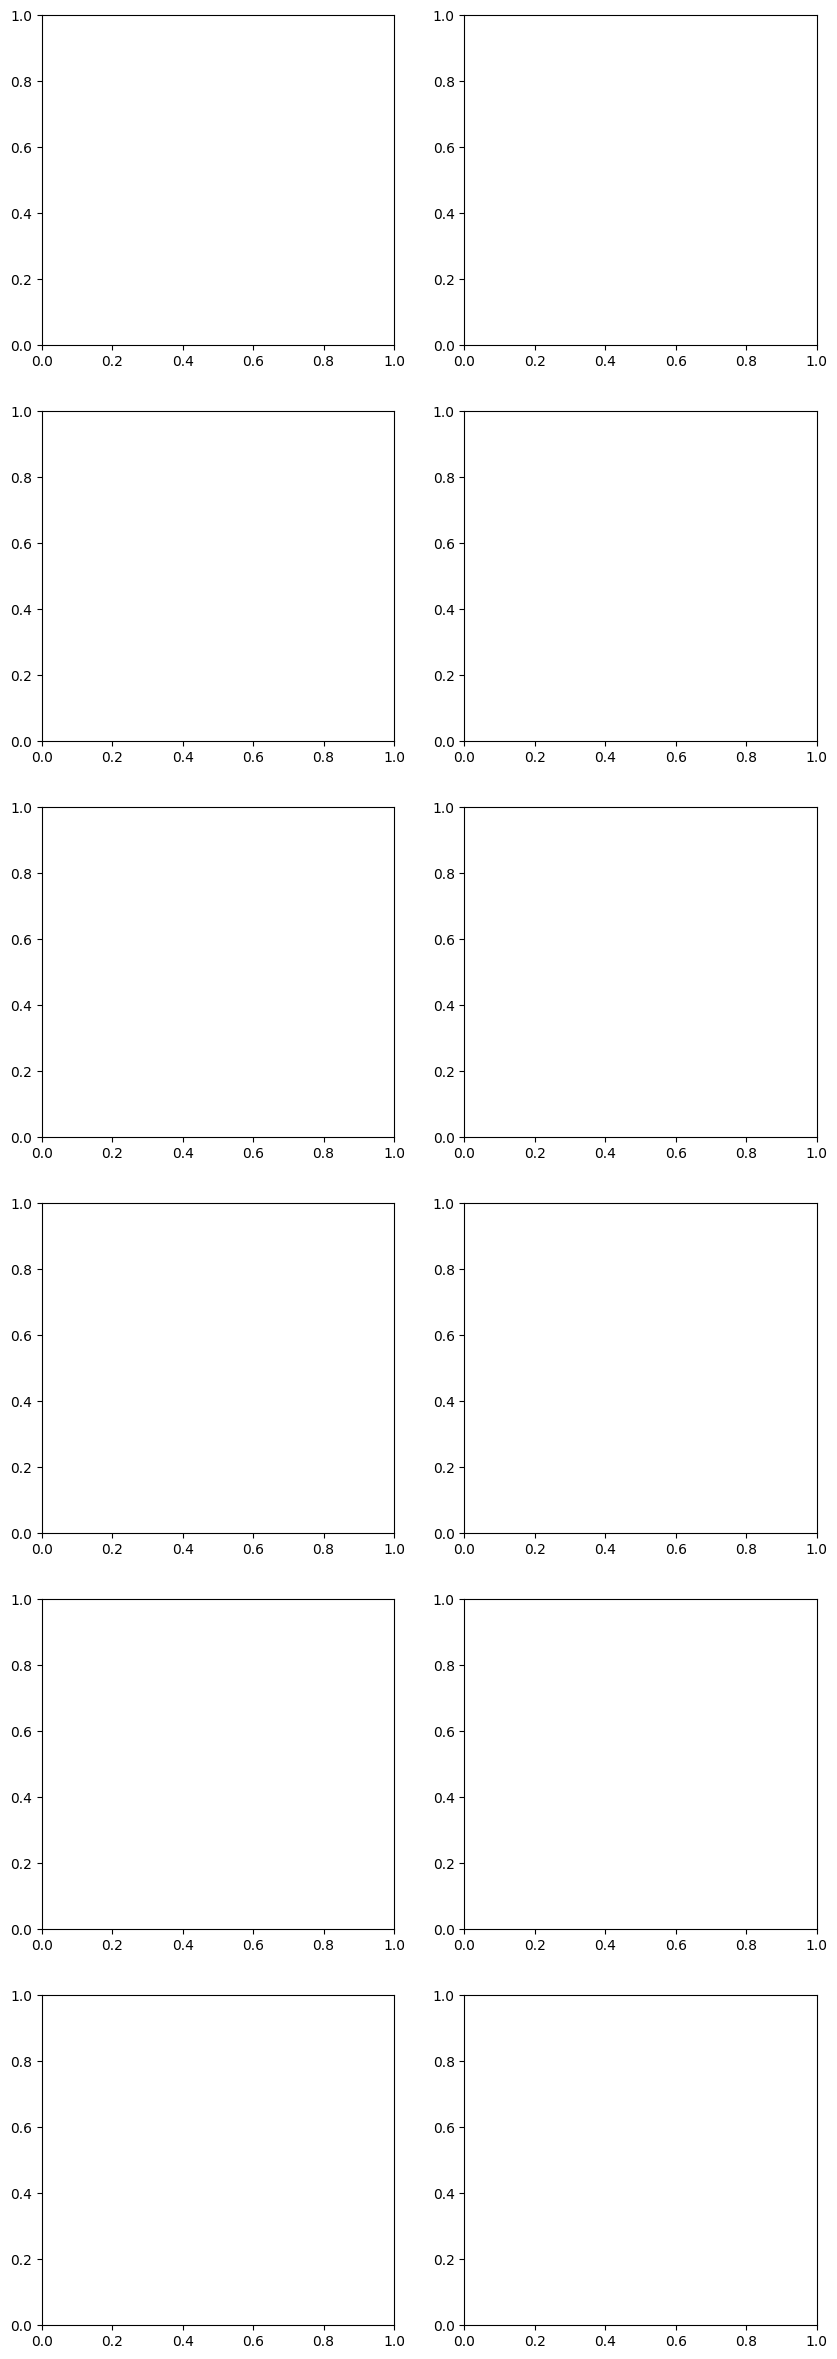

In [ ]:
# model: Temporal PointWise Convolutional Network
'''
TempPointConv(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (hardtanh): Hardtanh(min_val=0.020833333333333332, max_val=100)
  (msle_loss): MSLELoss(
    (squared_error): MSELoss()
  )
  (mse_loss): MSELoss(
    (squared_error): MSELoss()
  )
  (bce_loss): BCELoss()
  (main_dropout): Dropout(p=0.45, inplace=False)
  (temp_dropout): Dropout(p=0.05, inplace=False)
  (empty_module): EmptyModule()
  (diagnosis_encoder): Linear(in_features=1, out_features=64, bias=True)
  (bn_diagnosis_encoder): MyBatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_point_last_los): MyBatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_point_last_mort): MyBatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (point_final_los): Linear(in_features=17, out_features=1, bias=True)
  (point_final_mort): Linear(in_features=17, out_features=1, bias=True)
  (layer_modules): ModuleDict(
    (0): ModuleDict(
      (temp): Conv1d(202, 1212, kernel_size=(4,), stride=(1,), groups=101)
      (bn_temp): MyBatchNorm1d(1212, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (point): Linear(in_features=237, out_features=13, bias=True)
      (bn_point): MyBatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ModuleDict(
      (temp): Conv1d(1482, 1368, kernel_size=(4,), stride=(1,), dilation=(3,), groups=114)
      (bn_temp): MyBatchNorm1d(1368, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (point): Linear(in_features=1462, out_features=13, bias=True)
      (bn_point): MyBatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ModuleDict(
      (temp): Conv1d(1651, 1524, kernel_size=(4,), stride=(1,), dilation=(6,), groups=127)
      (bn_temp): MyBatchNorm1d(1524, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (point): Linear(in_features=1618, out_features=13, bias=True)
      (bn_point): MyBatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ModuleDict(
      (temp): Conv1d(1820, 1680, kernel_size=(4,), stride=(1,), dilation=(9,), groups=140)
      (bn_temp): MyBatchNorm1d(1680, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (point): Linear(in_features=1774, out_features=13, bias=True)
      (bn_point): MyBatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): ModuleDict(
      (temp): Conv1d(1989, 1836, kernel_size=(4,), stride=(1,), dilation=(12,), groups=153)
      (bn_temp): MyBatchNorm1d(1836, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (point): Linear(in_features=1930, out_features=13, bias=True)
      (bn_point): MyBatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): ModuleDict(
      (temp): Conv1d(2158, 1992, kernel_size=(4,), stride=(1,), dilation=(15,), groups=166)
      (bn_temp): MyBatchNorm1d(1992, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (point): Linear(in_features=2086, out_features=13, bias=True)
      (bn_point): MyBatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (6): ModuleDict(
      (temp): Conv1d(2327, 2148, kernel_size=(4,), stride=(1,), dilation=(18,), groups=179)
      (bn_temp): MyBatchNorm1d(2148, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (point): Linear(in_features=2242, out_features=13, bias=True)
      (bn_point): MyBatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (7): ModuleDict(
      (temp): Conv1d(2496, 2304, kernel_size=(4,), stride=(1,), dilation=(21,), groups=192)
      (bn_temp): MyBatchNorm1d(2304, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (point): Linear(in_features=2398, out_features=13, bias=True)
      (bn_point): MyBatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (8): ModuleDict(
      (temp): Conv1d(2665, 2460, kernel_size=(4,), stride=(1,), dilation=(24,), groups=205)
      (bn_temp): MyBatchNorm1d(2460, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (point): Linear(in_features=2554, out_features=13, bias=True)
      (bn_point): MyBatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (point_last_los): Linear(in_features=2867, out_features=17, bias=True)
  (point_last_mort): Linear(in_features=2867, out_features=17, bias=True)
)
'''

# from eICU_preprocessing.split_train_test import create_folder
# from torch.optim import Adam
# from models.tpc_model import TempPointConv
# from models.experiment_template import ExperimentTemplate
# from models.initialise_arguments import initialise_tpc_arguments


# class TPC(ExperimentTemplate):
#     def setup(self):
#         self.setup_template()
#         self.model = TempPointConv(
#             config=self.config,
#             F=self.train_datareader.F,
#             D=self.train_datareader.D,
#             no_flat_features=self.train_datareader.no_flat_features,
#         ).to(device=self.device)
#         self.elog.print(self.model)
#         self.optimiser = Adam(
#             self.model.parameters(),
#             lr=self.config.learning_rate,
#             weight_decay=self.config.L2_regularisation,
#         )
#         return


# if __name__ == "__main__":
#     c = initialise_tpc_arguments(mode='train',dataset='MIMIC',task='LoS')
#     c["exp_name"] = "TPC"
#     # c['dataset'] = 'MIMIC'

#     log_folder_path = create_folder(
#         "models/experiments/{}/{}".format(c.dataset, c.task), c.exp_name
#     )

#     tpc = TPC(
#         config=c,
#         n_epochs=c.n_epochs,
#         name=c.exp_name,
#         base_dir=log_folder_path,
#         explogger_kwargs={"folder_format": "%Y-%m-%d_%H%M%S{run_number}"},
#     )
#     tpc.run()
# import matplotlib.pyplot as plt
# import os


# def plot_metric_images(metrics, base_dir="path_to_your_images"):
#     """
#     Plots images for each specified metric.

#     Args:
#     metrics (list): List of metric names to plot.
#     base_dir (str): Base directory where images are stored.
#     """
#     num_metrics = len(metrics)
#     fig, axes = plt.subplots(nrows=num_metrics, ncols=2, figsize=(10, 5 * num_metrics))

#     if num_metrics == 1:
#         axes = [axes]

#     for i, metric in enumerate(metrics):
#         train_img_path = os.path.join(base_dir, f"train_{metric}.png")
#         val_img_path = os.path.join(base_dir, f"val_{metric}.png")

#         # Load and plot training metric
#         train_img = plt.imread(train_img_path)
#         axes[i][0].imshow(train_img)
#         axes[i][0].set_title(f"Training {metric}")
#         axes[i][0].axis("off")  # Hide axes

#         # Load and plot validation metric
#         val_img = plt.imread(val_img_path)
#         axes[i][1].imshow(val_img)
#         axes[i][1].set_title(f"Validation {metric}")
#         axes[i][1].axis("off")  # Hide axes


#     plt.tight_layout()
#     plt.show()


# List of metrics to plot
metrics_list = ["kappa", "mad", "mape", "mse", "msle", "r2"]

print("TPC Model Training Graphs for Length of Stay Prediction Task")
# Call the function with the path to your images
plot_metric_images(
    metrics_list, base_dir="/content/drive/MyDrive/TPC-LoS-prediction/models/experiments/MIMIC/LoS/TPC/2024-04-12_1311511/plot"
)



In [ ]:
# model: BaseLSTM
'''
ARCHITECTURE:
BaseLSTM(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (hardtanh): Hardtanh(min_val=0.020833333333333332, max_val=100)
  (lstm_dropout): Dropout(p=0.2, inplace=False)
  (main_dropout): Dropout(p=0.45, inplace=False)
  (msle_loss): MSLELoss(
    (squared_error): MSELoss()
  )
  (mse_loss): MSELoss(
    (squared_error): MSELoss()
  )
  (bce_loss): BCELoss()
  (empty_module): EmptyModule()
  (lstm): LSTM(204, 128, num_layers=2, dropout=0.2)
  (diagnosis_encoder): Linear(in_features=1, out_features=64, bias=True)
  (bn_diagnosis_encoder): MyBatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (point_los): Linear(in_features=161, out_features=17, bias=True)
  (point_mort): Linear(in_features=161, out_features=17, bias=True)
  (bn_point_last_los): MyBatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_point_last_mort): MyBatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (point_final_los): Linear(in_features=17, out_features=1, bias=True)
  (point_final_mort): Linear(in_features=17, out_features=1, bias=True)
)
'''
# Optimizer is Adam with learning rate  0.00129
# mean squared log error is the loss function
# model is imported from the paper's code

Model LSTM training graphs \
![train_kappa.png](https://drive.google.com/uc?export=view&id=1Dt2AwPcW1qUBzDhcFvKio7lhyw14w4SU)
![train_mad.png](https://drive.google.com/uc?export=view&id=17mQDtHBYNA2_LOYVcrAqIgdUKwKG5_jL)
![train_mape.png](https://drive.google.com/uc?export=view&id=1z8XN64cxitMy1fH9WPK7vx7ExSFh2u9M)
![train_mse.png](https://drive.google.com/uc?export=view&id=1dk8eGDgeWaBUZeTgdzzDrgtA51ZTwQ0H)
![train_msle.png](https://drive.google.com/uc?export=view&id=1Qy4zsjVWULaVLbJtq-XX5JmKeKDB5nGK)
![train_r2.png](https://drive.google.com/uc?export=view&id=1PaU-l7GJ03w5CNX5ytCuWpv_0BH-2j1U)

In [ ]:
# model: transformer
'''
ARCHITECTURE:
Transformer(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (hardtanh): Hardtanh(min_val=0.020833333333333332, max_val=100)
  (trans_dropout): Dropout(p=0, inplace=False)
  (main_dropout): Dropout(p=0.45, inplace=False)
  (msle_loss): MSLELoss(
    (squared_error): MSELoss()
  )
  (mse_loss): MSELoss(
    (squared_error): MSELoss()
  )
  (bce_loss): BCELoss()
  (empty_module): EmptyModule()
  (transformer): TransformerEncoder(
    (input_embedding): Conv1d(204, 16, kernel_size=(1,), stride=(1,))
    (pos_encoder): PositionalEncoding()
    (trans_encoder_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
      )
      (linear1): Linear(in_features=16, out_features=256, bias=True)
      (dropout): Dropout(p=0, inplace=False)
      (linear2): Linear(in_features=256, out_features=16, bias=True)
      (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0, inplace=False)
      (dropout2): Dropout(p=0, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
          )
          (linear1): Linear(in_features=16, out_features=256, bias=True)
          (dropout): Dropout(p=0, inplace=False)
          (linear2): Linear(in_features=256, out_features=16, bias=True)
          (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0, inplace=False)
          (dropout2): Dropout(p=0, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
          )
          (linear1): Linear(in_features=16, out_features=256, bias=True)
          (dropout): Dropout(p=0, inplace=False)
          (linear2): Linear(in_features=256, out_features=16, bias=True)
          (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0, inplace=False)
          (dropout2): Dropout(p=0, inplace=False)
        )
        (2): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
          )
          (linear1): Linear(in_features=16, out_features=256, bias=True)
          (dropout): Dropout(p=0, inplace=False)
          (linear2): Linear(in_features=256, out_features=16, bias=True)
          (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0, inplace=False)
          (dropout2): Dropout(p=0, inplace=False)
        )
        (3): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
          )
          (linear1): Linear(in_features=16, out_features=256, bias=True)
          (dropout): Dropout(p=0, inplace=False)
          (linear2): Linear(in_features=256, out_features=16, bias=True)
          (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0, inplace=False)
          (dropout2): Dropout(p=0, inplace=False)
        )
        (4): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
          )
          (linear1): Linear(in_features=16, out_features=256, bias=True)
          (dropout): Dropout(p=0, inplace=False)
          (linear2): Linear(in_features=256, out_features=16, bias=True)
          (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0, inplace=False)
          (dropout2): Dropout(p=0, inplace=False)
        )
        (5): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
          )
          (linear1): Linear(in_features=16, out_features=256, bias=True)
          (dropout): Dropout(p=0, inplace=False)
          (linear2): Linear(in_features=256, out_features=16, bias=True)
          (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0, inplace=False)
          (dropout2): Dropout(p=0, inplace=False)
        )
      )
    )
  )
  (diagnosis_encoder): Linear(in_features=1, out_features=64, bias=True)
  (bn_diagnosis_encoder): MyBatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (point_los): Linear(in_features=49, out_features=17, bias=True)
  (point_mort): Linear(in_features=49, out_features=17, bias=True)
  (bn_point_last_los): MyBatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_point_last_mort): MyBatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (point_final_los): Linear(in_features=17, out_features=1, bias=True)
  (point_final_mort): Linear(in_features=17, out_features=1, bias=True)
)
'''
# Optimizer is Adam with learning rate  0.00017
# mean squared log error is the loss function
# model is imported from the paper's code

Model Transformer training graphs \
![train_kappa.png](https://drive.google.com/uc?export=view&id=1e0j_T6I2W-K67lORDri-Fuhwie_YP7Kn)
![train_mad.png](https://drive.google.com/uc?export=view&id=1ImT5DY6kRcc725JXtssC-uIOeq0Tf1vP)
![train_mape.png](https://drive.google.com/uc?export=view&id=1ocQQ-Qml3oVdMJVzMupQYUIyaWchVIdK)
![train_mse.png](https://drive.google.com/uc?export=view&id=1QsbE7zqog6wV3cEEvhfaxny4TfmbWUk4)
![train_msle.png](https://drive.google.com/uc?export=view&id=1lcgdO12XInUlaDD2FSaEHlR3momSXqqc)
![train_r2.png](https://drive.google.com/uc?export=view&id=1cxZKyo2qdvVIm7IfbQGyQafpggpRHUc0)

###Task: Multitask

TPC Model Training Graphs for Multitask


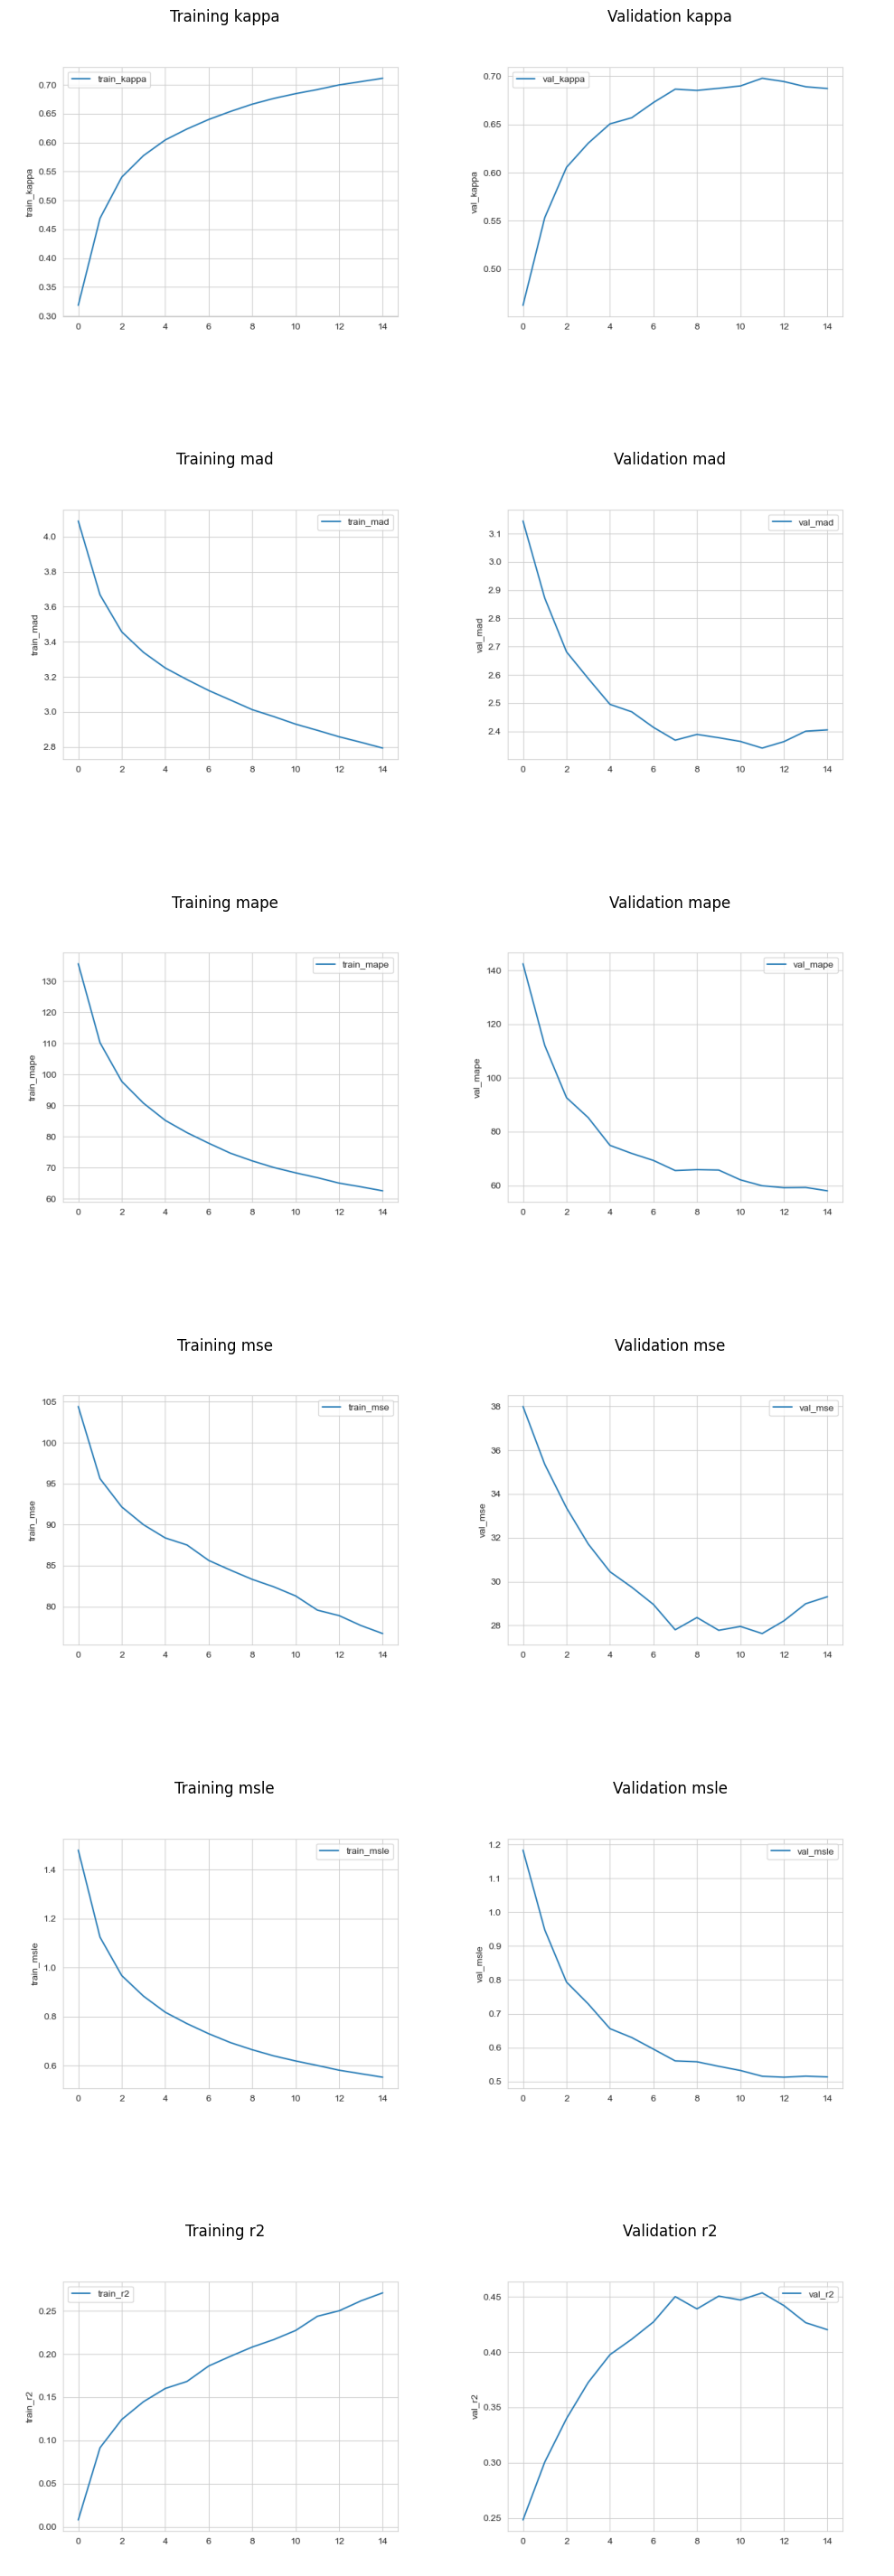

In [ ]:
# model: TPC
'''
TempPointConv(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (hardtanh): Hardtanh(min_val=0.020833333333333332, max_val=100)
  (msle_loss): MSLELoss(
    (squared_error): MSELoss()
  )
  (mse_loss): MSELoss(
    (squared_error): MSELoss()
  )
  (bce_loss): BCELoss()
  (main_dropout): Dropout(p=0.45, inplace=False)
  (temp_dropout): Dropout(p=0.05, inplace=False)
  (empty_module): EmptyModule()
  (diagnosis_encoder): Linear(in_features=1, out_features=64, bias=True)
  (bn_diagnosis_encoder): MyBatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_point_last_los): MyBatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_point_last_mort): MyBatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (point_final_los): Linear(in_features=17, out_features=1, bias=True)
  (point_final_mort): Linear(in_features=17, out_features=1, bias=True)
  (layer_modules): ModuleDict(
    (0): ModuleDict(
      (temp): Conv1d(202, 1212, kernel_size=(4,), stride=(1,), groups=101)
      (bn_temp): MyBatchNorm1d(1212, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (point): Linear(in_features=237, out_features=13, bias=True)
      (bn_point): MyBatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ModuleDict(
      (temp): Conv1d(1482, 1368, kernel_size=(4,), stride=(1,), dilation=(3,), groups=114)
      (bn_temp): MyBatchNorm1d(1368, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (point): Linear(in_features=1462, out_features=13, bias=True)
      (bn_point): MyBatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ModuleDict(
      (temp): Conv1d(1651, 1524, kernel_size=(4,), stride=(1,), dilation=(6,), groups=127)
      (bn_temp): MyBatchNorm1d(1524, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (point): Linear(in_features=1618, out_features=13, bias=True)
      (bn_point): MyBatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ModuleDict(
      (temp): Conv1d(1820, 1680, kernel_size=(4,), stride=(1,), dilation=(9,), groups=140)
      (bn_temp): MyBatchNorm1d(1680, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (point): Linear(in_features=1774, out_features=13, bias=True)
      (bn_point): MyBatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): ModuleDict(
      (temp): Conv1d(1989, 1836, kernel_size=(4,), stride=(1,), dilation=(12,), groups=153)
      (bn_temp): MyBatchNorm1d(1836, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (point): Linear(in_features=1930, out_features=13, bias=True)
      (bn_point): MyBatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): ModuleDict(
      (temp): Conv1d(2158, 1992, kernel_size=(4,), stride=(1,), dilation=(15,), groups=166)
      (bn_temp): MyBatchNorm1d(1992, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (point): Linear(in_features=2086, out_features=13, bias=True)
      (bn_point): MyBatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (6): ModuleDict(
      (temp): Conv1d(2327, 2148, kernel_size=(4,), stride=(1,), dilation=(18,), groups=179)
      (bn_temp): MyBatchNorm1d(2148, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (point): Linear(in_features=2242, out_features=13, bias=True)
      (bn_point): MyBatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (7): ModuleDict(
      (temp): Conv1d(2496, 2304, kernel_size=(4,), stride=(1,), dilation=(21,), groups=192)
      (bn_temp): MyBatchNorm1d(2304, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (point): Linear(in_features=2398, out_features=13, bias=True)
      (bn_point): MyBatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (8): ModuleDict(
      (temp): Conv1d(2665, 2460, kernel_size=(4,), stride=(1,), dilation=(24,), groups=205)
      (bn_temp): MyBatchNorm1d(2460, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (point): Linear(in_features=2554, out_features=13, bias=True)
      (bn_point): MyBatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (point_last_los): Linear(in_features=2867, out_features=17, bias=True)
  (point_last_mort): Linear(in_features=2867, out_features=17, bias=True)
)
'''
# from eICU_preprocessing.split_train_test import create_folder
# from torch.optim import Adam
# from models.tpc_model import TempPointConv
# from models.experiment_template import ExperimentTemplate
# from models.initialise_arguments import initialise_tpc_arguments


# class TPC(ExperimentTemplate):
#     def setup(self):
#         self.setup_template()
#         self.model = TempPointConv(
#             config=self.config,
#             F=self.train_datareader.F,
#             D=self.train_datareader.D,
#             no_flat_features=self.train_datareader.no_flat_features,
#         ).to(device=self.device)
#         self.elog.print(self.model)
#         self.optimiser = Adam(
#             self.model.parameters(),
#             lr=self.config.learning_rate,
#             weight_decay=self.config.L2_regularisation,
#         )
#         return


# if __name__ == "__main__":
#     sys.argv = sys.argv[:1]
#     c = initialise_tpc_arguments(mode="train", dataset="MIMIC", task="multitask")
#     c["exp_name"] = "TPC"

#     log_folder_path = create_folder(
#         "models/experiments/{}/{}".format(c.dataset, c.task), c.exp_name
#     )

#     tpc = TPC(
#         config=c,
#         n_epochs=c.n_epochs,
#         name=c.exp_name,
#         base_dir=log_folder_path,
#         explogger_kwargs={"folder_format": "%Y-%m-%d_%H%M%S{run_number}"},
#     )
#     tpc.run()
import matplotlib.pyplot as plt
import os


def plot_metric_images(metrics, base_dir="path_to_your_images"):
    """
    Plots images for each specified metric.

    Args:
    metrics (list): List of metric names to plot.
    base_dir (str): Base directory where images are stored.
    """
    num_metrics = len(metrics)
    fig, axes = plt.subplots(nrows=num_metrics, ncols=2, figsize=(10, 5 * num_metrics))

    if num_metrics == 1:
        axes = [axes]

    for i, metric in enumerate(metrics):
        train_img_path = os.path.join(base_dir, f"train_{metric}.png")
        val_img_path = os.path.join(base_dir, f"val_{metric}.png")

        # Load and plot training metric
        train_img = plt.imread(train_img_path)
        axes[i][0].imshow(train_img)
        axes[i][0].set_title(f"Training {metric}")
        axes[i][0].axis("off")  # Hide axes

        # Load and plot validation metric
        val_img = plt.imread(val_img_path)
        axes[i][1].imshow(val_img)
        axes[i][1].set_title(f"Validation {metric}")
        axes[i][1].axis("off")  # Hide axes


    plt.tight_layout()
    plt.show()


# List of metrics to plot
metrics_list = ["kappa", "mad", "mape", "mse", "msle", "r2"]

print("TPC Model Training Graphs for Multitask")
# Call the function with the path to your images
plot_metric_images(
    metrics_list, base_dir="/content/drive/MyDrive/TPC-LoS-prediction/models/experiments/MIMIC/multitask/TPC/2024-04-14_0938401/plot"
)


# Results
In this section, you should finish training your model training or loading your trained model. That is a great experiment! You should share the results with others with necessary metrics and figures.

Please test and report results for all experiments that you run with:

*   specific numbers (accuracy, AUC, RMSE, etc)
*   figures (loss shrinkage, outputs from GAN, annotation or label of sample pictures, etc)


**Best Hyperparameters**

To get the best hyperparameters for our TPC model, you can run the below code snippet that searches the Hyperparameter space for the

In [ ]:
# import random
# import sys

# def get_hyperparam_config(dataset):

#     c = initialise_tpc_arguments()
#     c['mode'] = 'train'
#     c['exp_name'] = 'TPC'
#     if dataset == 'MIMIC':
#         c['no_diag'] = True
#     c['dataset'] = dataset
#     c['model_type'] = 'tpc'

#     # hyper-parameter grid
#     param_grid = {
#         #'batchnorm': ['mybatchnorm', 'pointonly', 'temponly', 'low_momentum', 'none', 'default'],
#         'main_dropout_rate': [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
#         'last_linear_size': list(int(x) for x in np.logspace(np.log2(16), np.log2(64), base=2, num=16)),
#         'diagnosis_size': list(int(x) for x in np.logspace(np.log2(16), np.log2(64), base=2, num=16)),
#     }

#     #c['batchnorm'] = random.choice(param_grid['batchnorm'])
#     c['main_dropout_rate'] = random.choice(param_grid['main_dropout_rate'])
#     c['last_linear_size'] = random.choice(param_grid['last_linear_size'])
#     c['diagnosis_size'] = random.choice(param_grid['diagnosis_size'])

#     return c

# if __name__=='__main__':
#     sys.argv = sys.argv[:1]
#     for i in range(25):
#         try:
#             c = get_hyperparam_config('MIMIC')
#             log_folder_path = create_folder('models/experiments/hyperparameters/MIMIC', c.exp_name)
#             tpc = TPC(config=c,
#                       n_epochs=c.n_epochs,
#                       name=c.exp_name,
#                       base_dir=log_folder_path,
#                       explogger_kwargs={'folder_format': '%Y-%m-%d_%H%M%S{run_number}'})
#             tpc.run()

#         except RuntimeError:
#             continue

In [ ]:
def best_global(c):
    c["alpha"] = 100
    if c["dataset"] == "eICU":
        c["main_dropout_rate"] = 0.45
        c["last_linear_size"] = 17
        c["diagnosis_size"] = 64
        c["batch_norm"] = "mybatchnorm"
    elif c["dataset"] == "MIMIC":
        # diagnosis size does not apply for MIMIC since we don't have diagnoses
        c["main_dropout_rate"] = 0
        c["last_linear_size"] = 36
        c["batch_norm"] = "mybatchnorm"
    return c


def best_tpc(c):
    c = best_global(c)
    c["mode"] = "test"
    c["model_type"] = "tpc"
    if c["dataset"] == "eICU":
        if c["percentage_data"] == 6.25:
            c["n_epochs"] = 8
        elif c["task"] == "mortality":
            c["n_epochs"] = 6
        else:
            c["n_epochs"] = 15
        c["batch_size"] = 32
        c["n_layers"] = 9
        c["kernel_size"] = 4
        c["no_temp_kernels"] = 12
        c["point_size"] = 13
        c["learning_rate"] = 0.00226
        c["temp_dropout_rate"] = 0.05
        c["temp_kernels"] = [12] * 9 if not c["share_weights"] else [32] * 9
        c["point_sizes"] = [13] * 9
    elif c["dataset"] == "MIMIC":
        c["no_diag"] = True
        c["n_epochs"] = 10 if c["task"] != "mortality" else 6
        c["batch_size"] = 8
        c["batch_size_test"] = (
            8  # purely to keep experiment size small so we can run many in parallel
        )
        c["n_layers"] = 8
        c["kernel_size"] = 5
        c["no_temp_kernels"] = 11
        c["point_size"] = 5
        c["learning_rate"] = 0.00221
        c["temp_dropout_rate"] = 0.05
        c["temp_kernels"] = [11] * 8
        c["point_sizes"] = [5] * 8
    return c


In [ ]:
# import sys

# if __name__ == "__main__":
#     # Remove the Jupyter notebook specific arguments
#     sys.argv = sys.argv[:1]
#     c = initialise_tpc_arguments(mode="test", dataset="MIMIC", task="LoS")
#     c["exp_name"] = "TPC"
#     c = best_tpc(c)

#     log_folder_path = create_folder("models/experiments/MIMIC/LoS", c.exp_name)
#     tpc = TPC(
#         config=c,
#         n_epochs=c.n_epochs,
#         name=c.exp_name,
#         base_dir=log_folder_path,
#         explogger_kwargs={"folder_format": "%Y-%m-%d_%H%M%S{run_number}"},
#     )
#     tpc.run()

## Model comparison

In [ ]:
# TPC model multitask
!python -m models.run_tpc_MT_bdeleon2 # this command runs multitask if in the bdeleon2 directory with env setup as readme states
# the model is fairly slow and cannot run in under 8 minutes, was run locally

^C


Multitask results \
==> Length of Stay:\
Mean absolute deviation (MAD) = 2.3412155816966442\
Mean squared error (MSE) = 42.15413822196319\
Mean absolute percentage error (MAPE) = 32.78972757346567\
Mean squared logarithmic error (MSLE) = 0.19729110881960077\
R^2 Score = 0.4577782456639441\
Cohen kappa score = 0.8475428590430585\
==> Mortality:\
Accuracy = 0.9195449948310852\
Precision Survived = 0.9403578639030457\
Precision Died = 0.7164179086685181\
Recall Survived = 0.9700267910957336\
Recall Died = 0.5517241358757019\
Area Under the Receiver Operating Characteristic curve (AUROC) = 0.91344695218253\
Area Under the Precision Recall curve (AUPRC) = 0.7044674961709643\
F1 score (macro averaged) = 0.7891692869950363\
Test Loss: 32.9196

In [ ]:
# TPC model LoS
!python -m models.run_tpc_LoS_bdeleon2
# colab is buggy and the results won't show in the print. Model was run locally

Config:
{
    "L2_regularisation": 0,
    "alpha": 100,
    "base_dir": "models/experiments/MIMIC/LoS/TPC",
    "batch_norm": "mybatchnorm",
    "batch_size": 8,
    "batch_size_test": 8,
    "batchnorm": "mybatchnorm",
    "dataset": "MIMIC",
    "diagnosis_size": 64,
    "disable_cuda": false,
    "exp_name": "TPC",
    "intermediate_reporting": false,
    "kernel_size": 5,
    "labs_only": false,
    "last_linear_size": 36,
    "learning_rate": 0.00221,
    "loss": "msle",
    "main_dropout_rate": 0,
    "mode": "test",
    "model_type": "tpc",
    "n_epochs": 10,
    "n_layers": 8,
    "name": "TPC",
    "no_diag": true,
    "no_exp": false,
    "no_labs": false,
    "no_mask": false,
    "no_skip_connections": false,
    "no_temp_kernels": 11,
    "percentage_data": 100.0,
    "point_size": 5,
    "point_sizes": [
        5,
        5,
        5,
        5,
        5,
        5,
        5,
        5
    ],
    "save_results_csv": false,
    "seed": 3366627998,
    "share_weights":

LoS results \
==> Length of Stay: \
Mean absolute deviation (MAD) = 2.4498319070431718 \
Mean squared error (MSE) = 44.0630471154297 \
Mean absolute percentage error (MAPE) = 34.7473941625261\
Mean squared logarithmic error (MSLE) = 0.19507889244464616\
R^2 Score = 0.4332242641868935\
Cohen kappa score = 0.8485135033932776\
Test Loss: 15.4553

In [ ]:
# LSTM model LoS
from models.run_lstm_bdeleon2 import loadRunLSTMMIMICTest # this function loads in the model from weights and runs test data on it
loadRunLSTMMIMICTest()

c:\users\brend\appdata\local\programs\python\python36\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Config:
{
    "L2_regularisation": 0,
    "alpha": 100,
    "base_dir": "models\\experiments\\MIMIC\\LoS/LSTM",
    "batch_size": 512,
    "batch_size_test": 32,
    "batchnorm": "mybatchnorm",
    "bidirectional": false,
    "channelwise": false,
    "dataset": "MIMIC",
    "diagnosis_size": 64,
    "disable_cuda": false,
    "exp_name": "LSTM",
    "hidden_size": 128,
    "intermediate_reporting": false,
    "labs_only": false,
    "last_linear_size": 17,
    "learning_rate": 0.00129,
    "loss": "msle",
    "lstm_dropout_rate": 0.2,
    "main_dropout_rate": 0.45,
    "mode": "train",
    "n_epochs": 8,
    "n_layers": 2,
    "name": "LSTM",
    "no_diag": true,
    "no_exp": false,
    "no_labs": false,
    "no_mask": false,
    "percentage_data": 100.0,
    "save_results_csv": false,
    "seed": 2365996660,
    "shuffle_train": false,
    "sum_losses": true,
    "task": "LoS"
}
Experiment set up.
BaseLSTM(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (hardtanh): Hardtanh(min_val=0.020

Mean absolute deviation (MAD) = 3.9279052974109874

Mean squared error (MSE) = 73.00246524994785

Mean absolute percentage error (MAPE) = 119.08524696852673

Mean squared logarithmic error (MSLE) = 1.3744521915666426

R^2 Score = 0.06098128325489438

Cohen kappa score = 0.3546261801386087

Test Loss: 108.8938

In [ ]:
# Transformer model LoS
from models.run_transformer_bdeleon2 import loadRunTransformerMIMICTest # this function loads in the model from weights and runs test data on it
loadRunTransformerMIMICTest()

c:\users\brend\appdata\local\programs\python\python36\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Config:
{
    "L2_regularisation": 0,
    "alpha": 100,
    "base_dir": "models/experiments/MIMIC/LoS/Transformer",
    "batch_size": 32,
    "batch_size_test": 32,
    "batchnorm": "mybatchnorm",
    "d_model": 16,
    "dataset": "MIMIC",
    "diagnosis_size": 64,
    "disable_cuda": false,
    "exp_name": "Transformer",
    "feedforward_size": 256,
    "intermediate_reporting": false,
    "labs_only": false,
    "last_linear_size": 17,
    "learning_rate": 0.00017,
    "loss": "msle",
    "main_dropout_rate": 0.45,
    "mode": "train",
    "n_epochs": 15,
    "n_heads": 2,
    "n_layers": 6,
    "name": "Transformer",
    "no_diag": true,
    "no_exp": false,
    "no_labs": false,
    "no_mask": false,
    "percentage_data": 100.0,
    "positional_encoding": false,
    "save_results_csv": false,
    "seed": 3556417034,
    "shuffle_train": false,
    "sum_losses": true,
    "task": "LoS",
    "trans_dropout_rate": 0
}
Experiment set up.
Transformer(
  (relu): ReLU()
  (sigmoid): Sigm

Mean absolute deviation (MAD) = 3.772209367473864 \
Mean squared error (MSE) = 69.33166640651174 \
Mean absolute percentage error (MAPE) = 119.518935338074\
Mean squared logarithmic error (MSLE) = 1.2899925640981809\
R^2 Score = 0.10819816569291929\
Cohen kappa score = 0.396732749358359\
Test Loss: 102.2016

# Discussion

In this section,you should discuss your work and make future plan. The discussion should address the following questions:
  * Make assessment that the paper is reproducible or not.
  * Explain why it is not reproducible if your results are kind negative.
  * Describe “What was easy” and “What was difficult” during the reproduction.
  * Make suggestions to the author or other reproducers on how to improve the reproducibility.
  * What will you do in next phase.



In [ ]:
# no code is required for this section
'''
if you want to use an image outside this notebook for explanaition,
you can read and plot it here like the Scope of Reproducibility
'''

The paper is reproducible as TPC shows a significant improval over LSTM/Transformer for LoS task only and TPC trained on multitask has a modest improvement over TPC on just LoS. It was difficult finding the resources to run training for the models. It was also difficult downgrading to python 3.6 along with the libraries. It was difficult to load the model since the author's used a library to run experiments that is outdated. The model needs to be loaded with the libraries custom loader and their custom test runner. There were also a few bugs with their code and completely missing sections that they claimed to have in their code but did not. Pre-processing was relatively easy, but storage and time were issues. It was relatively easy to run training once everything else was figured out. Loading and running TPC in the notebook was buggy and slow.
The authors would need to update to newer version of python, simplify their pipeline, and fully implement what they claim to implement.
In the next phase, we will focus on running ablations.

# References

1.   Emma Rocheteau, Pietro Liò, and Stephanie Hyland. 2021. Temporal pointwise convolutional networks for length of stay prediction in the intensive care unit. In Proceedings of the Conference on Health, Inference, and Learning (CHIL '21). Association for Computing Machinery, New York, NY, USA, 58–68. https://doi.org/10.1145/3450439.3451860

2. Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

3. Johnson, A., Bulgarelli, L., Pollard, T., Horng, S., Celi, L. A., & Mark, R. (2020). MIMIC-IV (version 0.4). PhysioNet. https://doi.org/10.13026/a3wn-hq05.

4. Pollard, T., Johnson, A., Raffa, J., Celi, L. A., Badawi, O., & Mark, R. (2019). eICU Collaborative Research Database (version 2.0). PhysioNet. https://doi.org/10.13026/C2WM1R.

5. Pollard, T., Johnson, A., Raffa, J. et al. The eICU Collaborative Research Database, a freely available multi-center database for critical care research. Sci Data 5, 180178 (2018). https://doi.org/10.1038/sdata.2018.178

# Feel free to add new sections